In [36]:
import os
import glob
import pandas as pd
import math
import json
from collections import Counter, defaultdict

# CMV comments

## Load data, link to relevant fields from posts data

In [106]:
posts_df = pd.read_csv('pmaw_output/submissions/changemyview/1-1-2010_to_09-22-2021.csv',
                  index_col=0)
post_id2title = dict(zip(posts_df['id'],posts_df['title']))

In [117]:
df = pd.read_csv('comments_output/changemyview/from_posts_1-1-2010_to_9-22-2021.csv')
df['parent_post_title'] = df['parent_id'].apply(
    lambda x: post_id2title[x.split('_')[-1]]
)
df.to_csv('comments_output/changemyview/from_posts_1-1-2010_to_9-22-2021.csv',index=False)

In [119]:
df.shape

(37234, 60)

## Filter to comments on posts w/ keyword in title

In [164]:
with open('../keywords_high_precision.txt','r') as f:
    KEYWORDS_HI_PREC = set(f.read().splitlines())
KEYWORDS_SHORT = set(["climate change","global warming","carbon","co2","methane",
                  "green","environment","fossil fuel"])

In [165]:
KEYWORDS_HI_PREC

{'EPA',
 'IPCC',
 'cap and trade',
 'carbon dioxide',
 'clean energy',
 'climate change',
 'climate crisis',
 'climate emergency',
 'co2',
 'deforestation',
 'environmentalism',
 'extreme weather',
 'fossil fuel',
 'global warming',
 'green new deal',
 'greenhouse effect',
 'greenhouse gas',
 'methane',
 'permafrost',
 'renewable energy',
 'sea level rise'}

In [162]:
import re
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set):
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

In [163]:
contains_keyword('This is a test ot see if $5green new deal appears and EPA.',set(KEYWORDS_HI_PREC))

True

In [173]:
df_small = df.loc[df['parent_post_title'].apply(lambda x: contains_keyword(x,KEYWORDS_HI_PREC))].copy()
df_small.shape

(6403, 60)

## Examine basics

In [59]:
df['author_fullname'].apply(lambda x: type(x)).value_counts() # 429 [deleted]

<class 'str'>      3435
<class 'float'>     931
Name: author_fullname, dtype: int64

In [60]:
df['changed_view'].value_counts()

False    3153
True     1213
Name: changed_view, dtype: int64

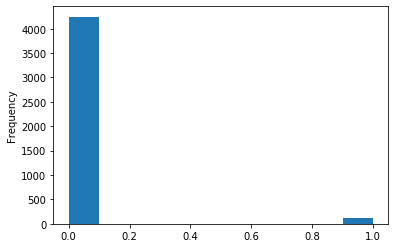

In [61]:
df['controversiality'].plot.hist()

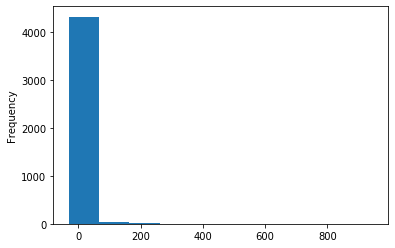

In [62]:
df['ups'].plot.hist()

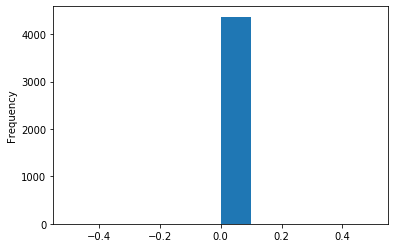

In [63]:
df['downs'].plot.hist()

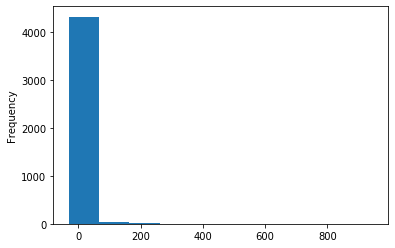

In [64]:
df['score'].plot.hist()

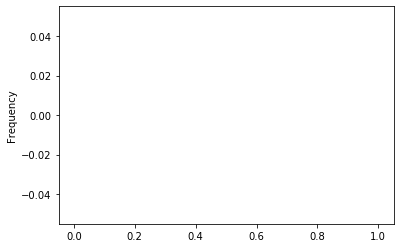

In [65]:
df['likes'].plot.hist()

In [66]:
df['distinguished'].value_counts()

moderator    33
Name: distinguished, dtype: int64

In [67]:
df['is_submitter'].value_counts()

False    4359
True        7
Name: is_submitter, dtype: int64

## Read successful comments in-situ

In [120]:
df.loc[df['changed_view']].shape

(15630, 60)

In [108]:
# for x in df.loc[df['changed_view']]['permalink'].values:
#     print('https://reddit.com'+x)

In [109]:
pd.set_option('display.max_colwidth', None)
df.loc[df['changed_view']][['parent_post_title','body']]

parent_post_title  \
3                                                                                                                                                                                I believe that fracking in the UK is a necessity for the short term and protesters are deluded. CMV   
8                                                                                                                                                                                                                                                I am an 18 year old Republican. CMV   
15                                                                                                                                                                                                         I believe that Global Warming, while real, is not an important issue. CMV   
18    I believe that if you are not an expert in a field, you should form your beliefs based on the consensus and common beliefs of experts in that field. This applies to global warming, GMOs, and even social ideas like institutional oppression, patriarchy and privilege. CMV.   
21    I believe that if you are not an expert in a field, you should form your beliefs based on the consensus and common beliefs of experts in that field. This applies to global warming, GMOs, and even social ideas like institutional oppression, patriarchy and privilege. CMV.   
...                                                                                                                                                                                                                                                                              ...   
8622                                                                                                                                                    CMV: Even if climate change is not real or man-caused, all of the acts being recommended to counter it should happen anyway.   
8626                                                                                                                                                    CMV: Even if climate change is not real or man-caused, all of the acts being recommended to counter it should happen anyway.   
8627                                                                                                                                                    CMV: Even if climate change is not real or man-caused, all of the acts being recommended to counter it should happen anyway.   
8631                                                                                                                                                                                                                     CMV: There's no advantage in living in a developing country   
8636                                                                                                                                                                                                                     CMV: There's no advantage in living in a developing country   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
- examples of serious consequences down the road that may not be evident yet
- "serious pollution issues"
- being graphic about ecological devastation
- metaphor of building walls to stop car from falling off cliff rather than to stop 
pushing car
- appealing to (scientific) evidence; "the data"
- equivalency frames with intuitive examples in other domains that are widely accepted
    - e.g. "CMV 'global warming crisis' is deceptive" > 
    "it's like how we call them 'heart attacks'"
- grounding in examples of other policies/actions throughout history 
that have been successful
- grounding in technological developments
- centering on "you"
- counterexamples
- asking questions; turning the tables on them
    - e.g. https://www.reddit.com/r/changemyview/comments/29j84f/cmv_i_fear_that_the_political_left_is_using/cilhoyf/

In [174]:
df_small['full_permalink'] = df_small['permalink'].apply(lambda x: 'https://reddit.com'+x)

In [177]:
# Write keyword-in-title subset to csv for Nik etc.
df_small.loc[df_small['changed_view']][['parent_post_title','body','full_permalink']].to_csv(
    'successful_cmv_comments.tsv',sep='\t',index=False,header=True
)

## LOR comments receiving delta vs. not ""

In [34]:
# spaCy preprocessing of body
import spacy
nlp = spacy.load("en_core_web_sm")

# save each comment's output as 
# `'comments_output/changemyview/spacy_processed/{}.json'.format(comment_id)`
save_dir = os.path.join('comments_output','changemyview','spacy_processed')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [133]:
processed = set(glob.glob(os.path.join(save_dir,'*.json')))
print(len(processed))

# for ix_row,row in df.iterrows():
#     c_id = row['id']
#     save_file = '{}.json'.format(c_id)
#     if os.path.join(save_dir,save_file) not in processed:
#         text = row['body']
#         if type(text) == str:
#             json_out = defaultdict(list)
#             doc = nlp(text)
#             for token in doc:
#                 json_out['token'].append(token.text)
#                 json_out['lemma'].append(token.lemma_)
#                 json_out['pos'].append(token.pos_)
#                 json_out['dep'].append(token.dep_)
#                 json_out['head'].append(token.head.text)
#                 json_out['children'].append([child.text for child in token.children])

#             with open(os.path.join(save_dir,save_file), 'w') as outfile:
#                 json.dump(json_out, outfile)
            
#     if ix_row % 500 == 0:
#         print(ix_row)

37233


In [127]:
# group into 2 sets:
# words in comments receiving deltas; words in comments NOT ""

df['changed_view'].value_counts()

False    21604
True     15630
Name: changed_view, dtype: int64

In [140]:
#b_change, b_no_change, prior_lemmas = [], [], []
prior_lemmas = []

# for c_id in df.loc[df['changed_view']]['id'].values:
#     try:
#         json_obj = pd.read_json(os.path.join(save_dir,'{}.json'.format(c_id)))
#         lemmas = json_obj['lemma'].values
#         b_change.extend(lemmas)
#     except ValueError:
#         continue
    
    
# for c_id in df.loc[~df['changed_view']]['id'].values:
#     try:
#         json_obj = pd.read_json(os.path.join(save_dir,'{}.json'.format(c_id)))
#         lemmas = json_obj['lemma'].values
#         b_no_change.extend(lemmas)
#     except ValueError:
#         continue
        
for fname in glob.glob('pushshift_output/pushshift_output_background/spacy_processed/'+\
                      '*.json'):
    try:
        json_obj = pd.read_json(fname)
        lemmas = json_obj['lemma'].values
        prior_lemmas.extend(lemmas)
    except ValueError:
        continue
    
print(len(b_change),len(b_no_change),len(prior_lemmas))

2880822 3242926 1838539


In [ ]:
25651

In [141]:
len(glob.glob('pushshift_output/pushshift_output_background/spacy_processed/'+\
                      '*.json'))

58361

In [142]:
counts_change, counts_no_change, counts_prior = Counter(b_change), Counter(b_no_change), \
                                                    Counter(prior_lemmas)
print(len(counts_change), len(counts_no_change), len(counts_prior))

prior = counts_change + counts_no_change + counts_prior

sigmasquared = defaultdict(float)
sigma = defaultdict(float)
delta = defaultdict(float)

for word in prior.keys():
    prior[word] = int(prior[word] + 0.5)

for word in counts_no_change.keys():
    counts_change[word] = int(counts_change[word] + 0.5)
    if prior[word] == 0:
        prior[word] = 1

for word in counts_change.keys():
    counts_no_change[word] = int(counts_no_change[word] + 0.5)
    if prior[word] == 0:
        prior[word] = 1

n1  = sum(counts_change.values())
n2  = sum(counts_no_change.values())
nprior = sum(prior.values())

for word in prior.keys():
    if prior[word] > 0:
        l1 = float(counts_change[word] + prior[word]) /\
                  (( n1 + nprior ) - (counts_change[word] + prior[word]))
        l2 = float(counts_no_change[word] + prior[word]) /\
                  (( n2 + nprior ) - (counts_no_change[word] + prior[word]))
        sigmasquared[word] =  1/(float(counts_change[word]) + float(prior[word])) + \
                              1/(float(counts_no_change[word]) + float(prior[word]))
        sigma[word] =  math.sqrt(sigmasquared[word])
        delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

for word in sorted(delta, key=delta.get):
    print(word)
    print("%.3f" % delta[word])

45687 51650 59578
  

-25.451
]
-18.706
/u
-17.648


-13.254
   

-12.779
delete
-10.603
-PRON-
-10.156
remove
-7.309
XXXXXX
-6.911
XXXXXXXXXXX
-6.492
XX
-6.462
XXXXXXX
-6.356
XXXXXXXXXXXX
-6.356
America
-6.314
XXXXXXXX
-6.100
XXXXXXXXXXXXX
-6.052
and
-5.830
XXXXXXXXXX
-5.807
think
-5.792
XXXXXXXXX
-5.706
X
-5.436
XXXXXXXXXXXXXX
-5.391
   
 
-5.366
XXX
-5.319
XXXX
-5.310
the
-5.269
XXXXX
-5.255
XXXXXXXXXXXXXXX
-5.171
XXXXXXXXXXXXXXXX
-5.143
XXXXXXXXXXXXXXXXX
-5.086
 
  

-5.073
religion
-4.841
bag
-4.547
XXXXXXXXXXXXXXXXXX
-4.543
STEM
-4.491
world
-4.401
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
-4.245
XXXXXXXXXXXXXXXXXXX
-4.211
country
-4.184
Histogram
-4.176
XXXXXXXXXXXXXXXXXXXX
-4.176
XXXXXXXXXXXXXXXXXXXXXX
-3.998
believe
-3.906
huadpe
-3.850
be
-3.834
XXXXXXXXXXXXXXXXXXXXXXX
-3.812
waste
-3.808
vote
-3.807
TED
-3.795
liberal
-3.761
XXXXXXXXXXXXXXXXXXXXX
-3.735
:
-3.731
Hillary
-3.728
should
-3.719
debate
-3.698
Karma
-3.648
Regards
-3.617
Clinton
-3.561
fusion
-3

-1.355
sane
-1.354
apartheid
-1.354
gov't
-1.353
topsoil
-1.353
substantiate
-1.353
pseudoscience
-1.350
fortune
-1.349
endanger
-1.348
dwindle
-1.348
incremental
-1.348
wasteful
-1.346
loan
-1.346
robot
-1.344
riot
-1.340
hoax
-1.339
at
-1.339
testing
-1.338
study
-1.338
Buddhism
-1.338
Anyway
-1.337
forefront
-1.335
Paul
-1.334
iq
-1.334
arrow
-1.334
delegate
-1.334
x
-1.334
father
-1.333
130
-1.332
NAP
-1.332
shoehorn
-1.332
seed
-1.331
peer
-1.329
min
-1.328
B.
-1.328
portrayal
-1.328
unfairness
-1.328
yada
-1.328
litmus
-1.328
fixable
-1.328
region
-1.324
Harvard
-1.324
broadband
-1.321
cuisine
-1.321








-1.321
shockingly
-1.321
beacon
-1.321
Summary
-1.321
election.|[link](http://www.reddit.com
-1.321
comments/2h4dzg
-1.321
cmv_i_dont_want_to_vote_in_the_upcoming_election
-1.321
|132|/u
-1.321
|112|/u
-1.321
|80|/u
-1.321
|74|/u
-1.321
|64|/u
-1.321
FeloniousMonk94
-1.321
peacekitty
-1.321
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
-1.321
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX

seasonal
-1.203
slack
-1.203
criminal
-1.203
dart
-1.201
alarmingly
-1.201
«
-1.201
»
-1.201
colder
-1.201
kkk
-1.201
136
-1.201
LIFE
-1.201
competitiveness
-1.201
armed
-1.199
assertion
-1.199
chamber
-1.198
shit
-1.197
wonderful
-1.194
pollinator
-1.194
interim
-1.194
noisy
-1.194
valuation
-1.194
POC
-1.194
Plant
-1.194
revolve
-1.193
which
-1.192
rightful
-1.191
affluent
-1.191
University
-1.191
Europeans
-1.190
concerning
-1.189
behead
-1.189
termination
-1.189
Dyson
-1.189
Wallace
-1.189
strap
-1.189
dress
-1.189
desecrate
-1.189
embargo
-1.189
Klein
-1.189
approx
-1.189
Tampa
-1.189
thr
-1.189
Holidays
-1.189
stool
-1.189
Player
-1.189
Soylent
-1.189
unlocked
-1.189
intersectional
-1.189
falsifiable
-1.188
toward
-1.186
drug
-1.184
declare
-1.184
poach
-1.184
53
-1.184
hometown
-1.184
species
-1.184
pH
-1.183
complacency
-1.183
theist
-1.183
thread
-1.182
veggie
-1.181
64
-1.180
sustainably
-1.180
Media
-1.179
use
-1.178
far
-1.178
lie
-1.176
negotiate
-1.176
issue
-1.174
overbl

Gitmo
-0.995
commissioner
-0.995
dicey
-0.995
7.7
-0.995
looney
-0.995
analog
-0.995
Kaine
-0.995
Wikileaks
-0.995
SOS
-0.995
piecemeal
-0.995
Paula
-0.995
Fidel
-0.995
retweete
-0.995
ethnical
-0.995
Pat
-0.995
1944
-0.995
quad
-0.995
copious
-0.995
curvature
-0.995
plutocratic
-0.995
Ned
-0.995
js
-0.995
fa
-0.995
2s
-0.995
Pu
-0.995
picker
-0.995
Pooh
-0.995
Marriott
-0.995
Farrakhan
-0.995
degredation
-0.995
Krispy
-0.995
Kreme
-0.995
hardworke
-0.995
VRE
-0.995
facemask
-0.995
TikTok
-0.995
mor
-0.995
can
-0.995
african
-0.994
supply
-0.994
revolution
-0.993
maintain
-0.993
overseas
-0.991
rebuttal
-0.990
spew
-0.990
mutually
-0.989
russia
-0.989
amplify
-0.989
account
-0.988
Quality
-0.988
boo
-0.988
depopulation
-0.988
Alexander
-0.988
te
-0.988
globalisation
-0.988
corona
-0.988
marine
-0.988
faculty
-0.988
upon
-0.987
hostility
-0.985
Roosevelt
-0.985
transcend
-0.985
potent
-0.985
Sanders
-0.985
gore
-0.984
wwii
-0.984
philanthropic
-0.984
Rubin
-0.984
Noah
-0.984
televise
-0

-0.934
Partnership
-0.934
farmed
-0.934
otherness"|[link](http://www.reddit.com
-0.934
comments/2tpl0x
-0.934
cmv_lgbtonly_schools_are_not_a_step_in_the_right
-0.934
Waze
-0.934
Tracking
-0.934
on.|[link](http://www.reddit.com
-0.934
comments/2tyrr5/cmv_police_unions_and_sheriff_associations_asking
-0.934
alive|[link](http://www.reddit.com
-0.934
comments/2u2fpm
-0.934
cmvwe_live_in_the_best_of_all_times_to_be_alive
-0.934
general.|[link](http://www.reddit.com
-0.934
comments/2tnwvc
-0.934
cmv_rubber_bullets_are_a_good_thing_and_are
-0.934
|60|/u
-0.934
whyfrenchcooke
-0.934
283
-0.934
speed3_freak
-0.934
call_it_art
-0.934
ricebasket
-0.934
nwf839
-0.934
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
-0.934
a_soporific
-0.934
sarcasmandsocialism
-0.934
4.10
-0.934
3.52
-0.934
3.30
-0.934
/u/5510
-0.934
Andes
-0.934
Republicanism
-0.934
fta
-0.934
Econ
-0.934
pinker
-0.934
ranting
-0.934
masquerading
-0.934
Policymakers
-0.934
/pol/
-0.934
magnification
-0.934
drying
-0.934
shinkouhyou|c

uncolonized
-0.934
Gundams
-0.934
RCP
-0.934
Moonlight
-0.934
colusion
-0.934
doesn‘t
-0.934
Morgenthau
-0.934
millionare
-0.934
80/20
-0.934
envrionment
-0.934
HOV
-0.934
bigwig
-0.934
\>is
-0.934
EROI
-0.934
Adama
-0.934
Traoré
-0.934
 
     
-0.934

     
-0.934
gnostic
-0.934
integrative
-0.934
racquet
-0.934
numbering
-0.934
alwyas
-0.934
shrub
-0.934
sandwhiche
-0.934
ampullae
-0.934
Bloke
-0.934
Pfizer
-0.934
stirrer
-0.934
unfavorability
-0.934





-0.934
-pro
-0.934







-0.934








-0.934
Icke
-0.934
Grievance_studies_affair
-0.934
decendant
-0.934
Boca
-0.934
Raton
-0.934
2,600
-0.934
stratigraphy
-0.934
''
-0.934
presidential
-0.933
figure
-0.932
Law
-0.932
inject
-0.932
wolf
-0.931
disingenuous
-0.931
nut
-0.931
bias
-0.931
shame
-0.930
Case
-0.930
teleportation
-0.930
overstep
-0.930
truthfully
-0.930
aptitude
-0.930
sensory
-0.930
reenactment
-0.930
omission
-0.930
quibble
-0.930
iphone
-0.930
scientific
-0.930
quick
-0.930
2nd
-0.930
Index
-0.929
Fairness
-0.929
t

innovation
-0.778
EDIT
-0.778
anywhere
-0.777
accident
-0.777
ignorant
-0.777
probably
-0.776
Electoral
-0.774
Nobody
-0.774
constantly
-0.774
victimless
-0.774
stigmatize
-0.774
rebellious
-0.774
Speaking
-0.774
upstream
-0.774
TIE
-0.774
SE
-0.774
enforcer
-0.774
optimally
-0.774
biomedical
-0.774
nutritionally
-0.774
Pole
-0.774
unchangeable
-0.774
Earthers
-0.774
saharan
-0.774
fodder
-0.774
nonrenewable
-0.774
miscarriage
-0.774
abrahamic
-0.774
installment
-0.774
DiCaprio
-0.774
Sources
-0.774
scooter
-0.774
keynesian
-0.774
bob
-0.774
boiling
-0.774
dominant
-0.774
sexuality
-0.774
legitimize
-0.774
Philippines
-0.774
shoot
-0.773
honestly
-0.773
treatment
-0.773
role
-0.773
brainwash
-0.773
v.
-0.773
25
-0.773
override
-0.773
funnel
-0.773
prompt
-0.773
unintelligent
-0.773
bam
-0.772
shitless
-0.772
SINGLE
-0.772
raindrop
-0.772
SAT
-0.772
Tide
-0.772
wold
-0.772
earned
-0.772
puritan
-0.772
6.6
-0.772
WRONG
-0.772
161
-0.772
rube
-0.772
Beck
-0.772
ag
-0.772
kowtow
-0.772
Mad

clouded
-0.762
wilmore
-0.762
http://nca2014.globalchange.gov/
-0.762
interconnection
-0.762
overfeed
-0.762
eskimo
-0.762
smartphone.|[link](http://www.reddit.com
-0.762
comments/2qtklt
-0.762
cmv_mobile_websites_are_a_relic_of_the_early
-0.762
|273|/u
-0.762
Mehmed_EI
-0.762
thefury500|cmv
-0.762
IAmAN00bie|CMV
-0.762
|131|/u
-0.762
|111|/u
-0.762
yes_no_pudding|cmv
-0.762
us.|[link](http://www.reddit.com
-0.762
Otherkin
-0.762
736
-0.762
kelleythefox
-0.762
EwokHugz
-0.762
385
-0.762
skilliard4
-0.762
krysis43ll
-0.762
Rippsonite
-0.762
jelatinman
-0.762
ArchitectofAges
-0.762
Microbrewlogic
-0.762
EwanWhoseArmy
-0.762
spappletrap
-0.762
322
-0.762
277
-0.762
216
-0.762
dewprisms
-0.762
201
-0.762
196
-0.762
yes_no_pudde
-0.762
Gigawatts
-0.762
sailorbrendan
-0.762
Black_Gay_Man
-0.762
raychilloh
-0.762
slf1452
-0.762
8.15
-0.762
6.08
-0.762
5.53
-0.762
5.07
-0.762
4.66
-0.762
4.55
-0.762
3.74
-0.762
3.56
-0.762
3.40
-0.762
3.39
-0.762
3.27
-0.762
2.32
-0.762
2.17
-0.762
1.78
-0.762

-0.762
undescriptive
-0.762
Sarbanes
-0.762
Oxley
-0.762
ECPA
-0.762
25k
-0.762
Sisyphus
-0.762
zimbabwe
-0.762
~330
-0.762
boron
-0.762
Socialized
-0.762
Interest
-0.762
1,000,000,000
-0.762
50.1
-0.762
INSTEAD
-0.762
abut
-0.762
humbler
-0.762
genus
-0.762
reclassification
-0.762
verizon
-0.762
under-21
-0.762
clubbing
-0.762
CHOOSE
-0.762
endorser
-0.762
Accidental
-0.762
revolution-1.html
-0.762
Makes
-0.762
dauhter
-0.762
Mazlow
-0.762
golly
-0.762
profane
-0.762
extremest
-0.762
318.9
-0.762
J.K
-0.762
32billion
-0.762
Carrot
-0.762
~6
-0.762
unignorable
-0.762
Winthrop
-0.762
ar5
-0.762
ºc
-0.762
exercising
-0.762
yxoque|cmv
-0.762
soda|[link](https://www.reddit.com
-0.762
comments/3f1ch5/cmv_food_stamps_should_not_cover_soda
-0.762
mrgoodnighthairdo|cmv
-0.762
technology.|[link](https://www.reddit.com
-0.762
comments/3f0uzz
-0.762
cmv_amazon_echo_is_an_incredibly_harmful_piece_of
-0.762
joalr0|cmv
-0.762
being.|[link](https://www.reddit.com
-0.762
comments/3fakft
-0.762
cmv_i_b

unrecognised
-0.762
opression
-0.762
awereness
-0.762
strenght
-0.762
61st
-0.762
article/11393.19.0.0/world
-0.762
blog/2009/10/irelands
-0.762
lisbon
-0.762
Imperator
-0.762
favored
-0.762
clumsily
-0.762
unisex
-0.762
wordpress
-0.762
days*.
-0.762
policy.org
-0.762
Lying
-0.762
33,000
-0.762
cartoonishly
-0.762
distortionary
-0.762
Source-
-0.762
suckle
-0.762
2].
-0.762
Schilling
-0.762
genderqueer
-0.762
assult
-0.762
Cameras
-0.762
imbalence
-0.762
Ubermensch
-0.762
news/2011
-0.762
05-nuclear
-0.762
8,000,000
-0.762
.13
-0.762
900deg
-0.762
aday
-0.762
29,000
-0.762
WIPP
-0.762
Onkalo
-0.762
superstructure
-0.762
lt;i
-0.762
povery
-0.762
EXPERIENCE
-0.762
wagyu
-0.762
babystep
-0.762
westernise
-0.762
rember
-0.762
29.1
-0.762
computerized
-0.762
studdy
-0.762
Conservitive
-0.762
Plaid
-0.762
1814
-0.762
Britanica
-0.762
unobstructed
-0.762
about_our_earth
-0.762
Corybn
-0.762
Sparknotes
-0.762
FTFY
-0.762
Sodium
-0.762
Hester
-0.762
Caulfield
-0.762
masturbatory
-0.762
tought

-0.762
rise-16094
-0.762
greener](https://climate.nasa.gov
-0.762
percent](http://english.chinatibetnews.com
-0.762
hb
-0.762
News/201507/t20150713_693852.html
-0.762
increasing](http://thebritishgeographer.weebly.com
-0.762
fostering
-0.762
MPAA
-0.762
DMCA
-0.762
indivisible
-0.762
1/8th
-0.762
Situation
-0.762
Gifford
-0.762
delivering
-0.762
delta'd
-0.762
Romantic
-0.762
Femininity
-0.762
Fault
-0.762
Backbone
-0.762
Ethnostate
-0.762
Provlems
-0.762
Result
-0.762
Fulfilled
-0.762
acceptability
-0.762
Deplatforming
-0.762
Axenar
-0.762
lexicon
-0.762
clarifying
-0.762
NSFL
-0.762
Volunteer
-0.762
MSBR
-0.762
Mansonobu
-0.762
U.K
-0.762
uninviting
-0.762
chiller
-0.762
cork
-0.762
Pests
-0.762
Durham
-0.762
headfirst
-0.762
early/2017/01/30/1609244114
-0.762
SCC
-0.762
NQAPIA
-0.762
NAPAWF
-0.762
Mazie
-0.762
Hirono
-0.762
Duckworth
-0.762
Taiwanese
-0.762
trumpster
-0.762
globaly
-0.762
https://climate.nasa.gov/evidence/](https://climate.nasa.gov/evidence/
-0.762
maxamize
-0.762
s

reports/2014/jun
-0.762
|$998
-0.762
|$861
-0.762
unmarked
-0.762
reperation
-0.762
Secession
-0.762
1D
-0.762
nosedive
-0.762
SOCIAL
-0.762

            
-0.762
BLUE
-0.762
kff
-0.762
november-2019/
-0.762
artandhistory
-0.762
Origins_Development.htm
-0.762
Rightward
-0.762
Kramer
-0.762
lgbt+/supposed
-0.762
rwer
-0.762
multitiered
-0.762
extremization
-0.762
——-ultimately
-0.762
boardroom
-0.762
torn
-0.762
telomere
-0.762
senselessly
-0.762
            



-0.762
944.3
-0.762
129.9
-0.762
kindof
-0.762
Blokes
-0.762
https://cei.org/blog/wrong-again-50-years-of-failed-eco-pocalyptic-predictions/
-0.762
  
  
  

-0.762
Remindme
-0.762
sideffect
-0.762
berth
-0.762
comite
-0.762
ERCOT
-0.762
tx
-0.762
therfore
-0.762
takeyourpickwhatever
-0.762
militiant
-0.762
intermixture
-0.762
-Free
-0.762
-Pro
-0.762
centralisation
-0.762
adrenachrome
-0.762
Pedos
-0.762
P.s
-0.762
Hugenots
-0.762
sufferring
-0.762
Fwiw
-0.762
Capita
-0.762
LGBTQI+
-0.762
LT
-0.762
perihelion
-0.762
Denzel
-0.76

285
-0.654
Smalls
-0.654
Approval
-0.654
obscurity
-0.654
M.D.
-0.654
scrounge
-0.654
physiologically
-0.654
crossfire
-0.654
pro-
-0.654
~~I
-0.654
1925
-0.654
immaculate
-0.654
Questions
-0.654
insipid
-0.654
Marches
-0.654
segue
-0.654
Dropbox
-0.654
unexplainable
-0.654
pasteurization
-0.654
accomodate
-0.654
engorge
-0.654
278
-0.654
Submarine
-0.654
duress
-0.654
Banking
-0.654
begrudge
-0.654
decadence
-0.654
Jonestown
-0.654
OKC
-0.654
blissfully
-0.654
880
-0.654
halting
-0.654
~15
-0.654
usury
-0.654
canopy
-0.654
SG
-0.654
AFL
-0.654
Zoe
-0.654
theydidthemath
-0.654
358
-0.654
butting
-0.654
facilitator
-0.654
Hockey
-0.654
absolutley
-0.654
Essential
-0.654
micromanage
-0.654
287
-0.654
247
-0.654
Academies
-0.654
Wharton
-0.654
Seven
-0.654
Gavin
-0.654
paddock
-0.654
434
-0.654
solder
-0.654
conscription
-0.654
458
-0.654
consecutively
-0.654
scraper
-0.654
AOL
-0.654
fke
-0.654
divisional
-0.654
371
-0.654
tommorow
-0.654
unnoticeable
-0.654
headscarf
-0.654
182
-0.654
4

vault
-0.578
Suicide
-0.578
L
-0.578
migrate
-0.578
corporeal
-0.577
materialise
-0.577
LMAO
-0.577
unfathomably
-0.577
penance
-0.577
gong
-0.577
pax
-0.577
lookin
-0.577
Challenger
-0.577
albino
-0.577
Carol
-0.577
worryingly
-0.577
Zeus
-0.577
MBA
-0.577
res
-0.577
urn
-0.577
spawning
-0.577
unsecured
-0.577
loin
-0.577
amtrak
-0.577
guitarist
-0.577
plaything
-0.577
Table
-0.577
Apes
-0.577
skydive
-0.577
deface
-0.577
Powell
-0.577
bravery
-0.577
GCC
-0.577
Course
-0.577
Omnibus
-0.577
Hatch
-0.577
Darth
-0.577
Sith
-0.577
directory
-0.577
tubing
-0.577
Concrete
-0.577
brittle
-0.577
Bradley
-0.577
greece
-0.577
Asimov
-0.577
Byzantine
-0.577
perverted
-0.577
commiserate
-0.577
realtor
-0.577
Avenue
-0.577
Fri
-0.577
tardigrade
-0.577
Juan
-0.577
oy
-0.577
vapour
-0.577
lecturer
-0.577
blackboard
-0.577
alkaline
-0.577
scifi
-0.577
freed
-0.577
Treat
-0.577
maize
-0.577
eff
-0.577
Logan
-0.577
Firearms
-0.577
leaked
-0.577
naught
-0.577
repulse
-0.577
bumbling
-0.577
leopard
-0.57

-0.539
asksocialscience
-0.539
60-year
-0.539
http://scrippsco2.ucsd.edu/faq/faq.html#faq3
-0.539
Agrarian
-0.539
gastrointestinologist
-0.539
radiocarbon
-0.539
discovering
-0.539
icepack
-0.539
presented
-0.539
Thogut
-0.539
Thermonuclear
-0.539
Reactor)](http://www.newyorker.com
-0.539
reporting/2014/03/03/140303fa_fact_khatchadourian?currentpage
-0.539
Venus](https://www.youtube.com
-0.539
watch?feature
-0.539
player_detailpage&v
-0.539
DUy2QXAt3Kc#t=145
-0.539
http://www.theguardian.com/science/2013/aug/05/synthetic-meat-burger-stem-cell
-0.539
Colonies
-0.539
controversies].
-0.539
G7/8
-0.539
Indices
-0.539
Metrification
-0.539
openess
-0.539
free(er
-0.539
disinfranchise
-0.539
sytem
-0.539
MMP
-0.539
Military/
-0.539
Number1
-0.539
makr
-0.539
decidely
-0.539
realisyic
-0.539
urbano
-0.539
lutheran
-0.539
headinf
-0.539
HFMD
-0.539
~a.
-0.539
~a
-0.539
malleability
-0.539
ukip
-0.539
quantifier
-0.539
redditer
-0.539
Passersby
-0.539
gread
-0.539
POST
-0.539
waverer
-0.539
/r/

http://www.youtube.com/watch?v=ds3okttewus
-0.539
abstruse
-0.539
zentral
-0.539
equaliy
-0.539
else?what
-0.539
Quotas
-0.539
paper](http://psp.sagepub.com
-0.539
early/2007/04/17/0146167206292689.short
-0.539
Machiavellianism
-0.539
hyperstimulate
-0.539
extinction?](http://www.ted.com
-0.539
stewart_brand_the_dawn_of_de_extinction_are_you_ready
-0.539
study](http://pss.sagepub.com
-0.539
content/8/5/379.short
-0.539
documentary](http://v.youku.com
-0.539
v_show
-0.539
id_xntu5mzi2ntq0.html
-0.539
brochure](http://ipcc
-0.539
brochure
-0.539
http://mahb.stanford.edu/library-item/what-if-we-burn-all-the-fossil-fuels/
-0.539
1790s
-0.539
Presernt
-0.539
underinformed
-0.539
overinforme
-0.539
averagely
-0.539
signification
-0.539
condorcet
-0.539
extremize
-0.539
Ivans
-0.539
O'Bummer
-0.539
O'Bama
-0.539
Pritzkers
-0.539
trounce
-0.539
Bargain
-0.539
http://m.youtube.com/watch?v=s7tWHJfhiyo
-0.539
Ministerial
-0.539
6bn
-0.539
50p
-0.539
sensationalization
-0.539
Vbbr0fWkIx8
-0.539
re

-0.539
GWy
-0.539
.0021GW
-0.539
servos
-0.539
401(k)s
-0.539
http://www.eccos.us/what-is-oil-used-for
-0.539
unit/$
-0.539
Keywords
-0.539
Salmond
-0.539
iScotland
-0.539
sterlingisation
-0.539
UBS
-0.539
googleable
-0.539
externalise
-0.539
uncompeititive
-0.539
-Upton
-0.539
WTI
-0.539
pecker
-0.539
creamy
-0.539
nougat
-0.539
Mesopatamians
-0.539
sg
-0.539
Wiggin
-0.539
preseason
-0.539
comptetitive
-0.539
Pacers
-0.539
hyperathletic
-0.539
Wizards
-0.539
possessions(the
-0.539
so)
-0.539
timberwolve
-0.539
diddnt
-0.539
universities-
-0.539
Athletics
-0.539
to.field
-0.539
tam
-0.539
0.007
-0.539
diguste
-0.539
PROOF
-0.539
excercising
-0.539
lies*.
-0.539
|786|/u
-0.539
wahtisthisidonteven|cmv
-0.539
cjz60m3)|
-0.539
|336|/u
-0.539
ck3qvi6)|
-0.539
|260|/u
-0.539
ck2tky4)|
-0.539
|259|/u
-0.539
ck22hzv)|
-0.539
|215|/u
-0.539
Pensky|CMV
-0.539
ck3olnv)|
-0.539
|208|/u
-0.539
timetravellersmith|cmv
-0.539
cjz6nsl)|
-0.539
|173|/u
-0.539
syd_malicious|CMV
-0.539
age|[link](http://w

Alterego9
-0.539
2.08
-0.539
Raborn
-0.539
1.73
-0.539
klw|cmv
-0.539
salvation|[link](http://www.reddit.com
-0.539
comments/2qjyfh
-0.539
cmv_the_bible_does_not_clearly_explain_the
-0.539
cn6s47w)|
-0.539
|4|/u
-0.539
h76ch36|cmv
-0.539
cnc6m4n)|
-0.539
NRDC](http://www.nrdc.org
-0.539
f101.asp
-0.539
WeatherUnderground
-0.539
here](http://www.wunderground.com
-0.539
negative_impacts.asp
-0.539
ago.](http://www.rc.swls.org
-0.539
www.old
-0.539
climatechange2007.pdf
-0.539
http://youtu.be/zorv8wwiadq
-0.539
Edmond
-0.539
Halley](http://en.wikipedia.org
-0.539
halley%27s_comet#computation_of_orbit
-0.539
Venus](http://en.wikipedia.org
-0.539
convex
-0.539
http://imgur.com/dkgpyfs
-0.539
http://en.wikipedia.org/wiki/Caning_of_Charles_Sumner
-0.539
zeus450
-0.539
zeus450+would+like+to+appeal+the+removal+of+[his
-0.539
comments/2y0vuy
-0.539
cmv_a_family_member_thinks_global_warming_is_a/\
-0.539
thatnproduce
-0.539
useed
-0.539
populistic
-0.539
threats(like
-0.539
ones(like
-0.539
XXth


708
-0.539
verumininani
-0.539
669
-0.539
AlexTheOgre
-0.539
417
-0.539
348
-0.539
throwaway56168148406
-0.539
highvemind
-0.539
pmbasehore
-0.539
SebasTheBass
-0.539
ElfKid
-0.539
LogicKennedy
-0.539
realsingingishard
-0.539
rand486
-0.539
combobmoc
-0.539
jimbo_sweets
-0.539
geoflause88
-0.539
Uneje
-0.539
TaylorSwiftDid911
-0.539
vortex_thunderr
-0.539
keanex
-0.539
HalfBurntToast
-0.539
grandfather_clock
-0.539
sarde
-0.539
BurntLeftovers
-0.539
ping111
-0.539
uranus
-0.539
Duckman0121
-0.539
dyschromatopsie
-0.539
hooploopdoop
-0.539
13.70
-0.539
822
-0.539
awesomedan24
-0.539
306
-0.539
281
-0.539
Shorkan
-0.539
245
-0.539
defiance42
-0.539
dopplerdilemma
-0.539
/u/1mfa0
-0.539
CanadianBoson
-0.539
InerasableStain
-0.539
Darkstrategy
-0.539
BrellK
-0.539
hippiechan
-0.539
verumininanis
-0.539
JurijFedorov
-0.539
Vorpal_Smilodon
-0.539
morebeansplease
-0.539
/u/5imba
-0.539
cablebent1988
-0.539
/u/29384092384098
-0.539
reallly
-0.539
lollerkeet
-0.539
aevaa
-0.539
/u/---N
-0.539
K

-0.539
divvye
-0.539
chlorinate
-0.539
biphenyl
-0.539
states)
-0.539
setups?HMOs
-0.539
TexIcare
-0.539
invasiveness
-0.539
judical
-0.539
shoddily
-0.539
oppressive](http://nymag.com
-0.539
intelligencer/2014/09/ferguson
-0.539
governments.html
-0.539
co5tsja)|
-0.539
|308|/u
-0.539
crustalmighty|cmv
-0.539
co2dgn1)|
-0.539
bigjo66|cmv
-0.539
cnzc8i8)|
-0.539
ricebasket|cmv
-0.539
co2fk1u)|
-0.539
whitmans_ghost|cmv
-0.539
co2d9jv)|
-0.539
SexualPie|CMV
-0.539
co2f90n)|
-0.539
|167|/u
-0.539
aussiecass|cmv
-0.539
co165zn)|
-0.539
talamor|cmv
-0.539
co3jsjb)|
-0.539
|146|/u
-0.539
whiteddit|cmv
-0.539
co4ntui)|
-0.539
dukeppuk|cmv
-0.539
co18ahm)|
-0.539
co0p81y)|
-0.539
PM_Urquhart|CMV
-0.539
cnzi0m9)|
-0.539
mlbontbs87|CMV
-0.539
co5x1vy)|
-0.539
TheNicestMonkey|CMV
-0.539
co4nsb0)|
-0.539
co2dul3)|
-0.539
objectivism|[link](http://www.reddit.com
-0.539
comments/2u38jq
-0.539
cmv_about_ayn_rand_and_her_theories_of_objectivism
-0.539
co4pu7y)|
-0.539
rez|cmv
-0.539
co16cpb)|
-0.539
c

darthvalium
-0.539
diyaww
-0.539
GheistWalker
-0.539
BenInIndy
-0.539
am_i_here
-0.539
ScottClam
-0.539
uscmissinglink
-0.539
zeldarocks2
-0.539
UrAccountabilibuddy
-0.539
Ghost51
-0.539
HeartyBeast
-0.539
DerGrifter
-0.539
SuzFallow
-0.539
supergingerlol
-0.539
vocabularian
-0.539
TenshiS
-0.539
thisflirtybirdy
-0.539
Troppin
-0.539
anonymous8577
-0.539
communikay
-0.539
16.23
-0.539
974
-0.539
this_makes_no_sense
-0.539
JFIZZLE
-0.539
395
-0.539
stravadarius
-0.539
joerobo
-0.539
takua108
-0.539
JonVictoryPlace
-0.539
liberalterryn
-0.539
LiterallyBismarck
-0.539
Falernum
-0.539
reggaejunkyjew
-0.539
VeryPrivate
-0.539
Jimmypickles
-0.539
rtechie1
-0.539
mwrargrh
-0.539
/u/212000
-0.539
studdbeefpile
-0.539
redbrassdart
-0.539
thedancinghamster
-0.539
0.27
-0.539
16.00
-0.539
12.23
-0.539
10.15
-0.539
8.79
-0.539
8.73
-0.539
7.17
-0.539
7.08
-0.539
7.06
-0.539
6.45
-0.539
6.44
-0.539
5.80
-0.539
5.33
-0.539
5.32
-0.539
5.24
-0.539
4.54
-0.539
Amadacius
-0.539
Trevor1680
-0.539
3.34
-

irregularshow
-0.539
EagenVegham
-0.539
FitzDizzyspells
-0.539
HeelBatman
-0.539
setfiretotherane
-0.539
Thaos_Ix_Arkannon
-0.539
ACarelessRoaster
-0.539
nashvortex
-0.539
PrinceHarming
-0.539
kaztrator
-0.539
Japenglo
-0.539
LemonG34R
-0.539
davbrowdid
-0.539
Stadics
-0.539
StannisGrindsTeeth
-0.539
zeptimius
-0.539
imtiredoftheinternet
-0.539
Teamkilleryo
-0.539
zi
-0.539
WarringBrood
-0.539
blumberparty
-0.539
altsallday
-0.539
sleuthysteve
-0.539
wanttorent06
-0.539
godeatscock
-0.539
8.97
-0.539
356
-0.539
333
-0.539
hearse
-0.539
249
-0.539
arcosapphire
-0.539
pstrdp
-0.539
The_Hoopla
-0.539
BolshevikMuppet
-0.539
limukala
-0.539
chudaism
-0.539
flait7
-0.539
sarcasm24
-0.539
moosekayak
-0.539
DoodleVnTaintschtain
-0.539
beast561
-0.539
ztsmart
-0.539
heli_elo
-0.539
throwdownperu
-0.539
southernpuppygirl
-0.539
/u/2074red2074
-0.539
smelllikespleensyrup
-0.539
noluv4uhoes
-0.539
LeighmurBJJ
-0.539
ganjlord
-0.539
jctennis123
-0.539
Bezant
-0.539
0.16
-0.539
8.00
-0.539
7.84
-0.5

uploads/2012/04/roi.jpg
-0.539
decade.](http://en.wikipedia.org
-0.539
History_of_lobbying_in_the_United_States
-0.539
optunitie
-0.539
Evolve
-0.539
http://www.codeforamerica.org/about/
-0.539
jerrymandering
-0.539
Refute
-0.539
http://www.kpfa.org/archive/id/108384
-0.539
https://www.youtube.com/watch?v=s7tWHJfhiyo
-0.539
https://www.youtube.com/watch?v=3y3je3b8hse
-0.539
slaves/'illegal
-0.539
gestapo
-0.539
Mathematicians
-0.539
dislodge
-0.539
MIS
-0.539
irrifutable
-0.539
http://spectator.org/articles/39326/americas-ruling-class-and-perils-revolution
-0.539
https://en.wikipedia.org/wiki/concentration_of_media_ownership
-0.539
https://www.youtube.com/watch?v=YXlWiTPn7pQ#t=12
-0.539
https://www.youtube.com/watch?v=cpdCEPFdu3I
-0.539
http://worldtruth.tv/11-tactics-used-by-the-mainstream-media-to-manufacture-consent-for-the-oligarchy-2/
-0.539
https://en.wikipedia.org/wiki/Propaganda_model
-0.539
plutarchy
-0.539
http://www.washingtonpost.com
-0.539
http://www.globalresearch.ca/the-

-0.539
SomeKindWords
-0.539
kodemage
-0.539
~~10~~
-0.539
NOAA.](http://www.ncdc.noaa.gov
-0.539
sotc
-0.539
global/201506
-0.539
0.88
-0.539
0.22
-0.539
1.26
-0.539
0.74
-0.539
350,000
-0.539
1981–2010
-0.539
europe](http://s.ngm.com/2013/09/rise
-0.539
gatefold
-0.539
RS_Web_EU_8M_v3.jpg
-0.539
  
       

-0.539
USA](http://2.bp.blogspot.com/-D7co
-0.539
J4Naus
-0.539
Ujj2OrUtmLI
-0.539
AAAAAAAAdDc
-0.539
bBPdhFkOslI
-0.539
s1600/screen+shot+2013
-0.539
17+at+6.47.06+pm.png
-0.539
  
    

    

-0.539
elev
-0.539
345
-0.539
level](https://encrypted
-0.539
tbn0.gstatic.com
-0.539
images?q
-0.539
tbn
-0.539
ANd9GcTzoGM5SCCz_Sp8sO8ecBLyjxxY8Gs0BvElTfIGPLphR8nWdfLD6
-0.539
area](http://d35brb9zkkbdsd.cloudfront.net
-0.539
uploads/2013/11/216a.jpg
-0.539
   
        

-0.539
 
       
    

-0.539
  
     

-0.539
~~should~~
-0.539
~~too
-0.539
Astronomers
-0.539
comments/3ekjom
-0.539
cmv_climate_change_isnt_an_issue_we_should_care
-0.539
ctftkkj
-0.539
this.](http://www.slate.com
-0.5

-0.539
cmv_i_think_calisthenics_parks_and_out_door
-0.539
cty2yo5)|
-0.539
cty7vci)|
-0.539
elimc|cmv
-0.539
restablishment
-0.539
state|[link](https://www.reddit.com
-0.539
comments/3gckff
-0.539
cmv_in_a_truly_libertarian_economy_unions_would
-0.539
ctwwd85)|
-0.539
legislated.|[link](https://www.reddit.com
-0.539
comments/3gu6gx
-0.539
cmv_all_party_consent_rule_for_phone_recorde
-0.539
cu1hbtz)|
-0.539
gpunotpsu|cmv
-0.539
expression.|[link](https://www.reddit.com
-0.539
comments/3galiq
-0.539
cmv_the_rise_of_political_correctness_has_been
-0.539
ctwcyo3)|
-0.539
minor?|[link](https://www.reddit.com
-0.539
comments/3g8u72/cmv_shouldnt_anyone_under_18_or_at_least_some_set
-0.539
ctvyztq)|
-0.539
spivak|cmv
-0.539
cu2z0b4)|
-0.539
gregbrahe|cmv
-0.539
ctvidaz)|
-0.539
pretendent|cmv
-0.539
ctyw8cv)|
-0.539
otter_pop_n_lock|cmv
-0.539
ctyx1or)|
-0.539
urnbabyurn|cmv
-0.539
cu2rdme)|
-0.539
britainfan234|CMV
-0.539
cu0h535)|
-0.539
PlacidPlatypus|CMV
-0.539
abandoned.|[link](https://ww

-0.539
treycook|cmv
-0.539
crm1srv)|
-0.539
|154|/u
-0.539
donuil23|cmv
-0.539
crmtkg8)|
-0.539
crn0oag)|
-0.539
june_oyster|cmv
-0.539
critpj7)|
-0.539
MageZero|CMV
-0.539
bicycle|[link](http://www.reddit.com
-0.539
comments/37e6il
-0.539
cmv_there_are_no_good_reasons_to_not_wear_a
-0.539
crlxhoh)|
-0.539
twosmalldeaths|cmv
-0.539
crmz0r3)|
-0.539
crmybh3)|
-0.539
crn0dd4)|
-0.539
cases)|[link](http://www.reddit.com
-0.539
comments/37flfu
-0.539
cmv_with_the_drought_in_california_i_should_no
-0.539
crma1oe)|
-0.539
crmyg8h)|
-0.539
ncr_comm_ofc_tango|cmv
-0.539
crm354w)|
-0.539
hypnofed|cmv
-0.539
crn1dwy)|
-0.539
nikoberg|cmv
-0.539
crmx0hq)|
-0.539
it.|[link](http://www.reddit.com
-0.539
comments/37fpzj
-0.539
cmv_i_believe_the_sixth_mass_extinction_has_begun
-0.539
crmcdb6)|
-0.539
IrresistablyWrong|CMV
-0.539
crmypoq)|
-0.539
quizzical|cmv
-0.539
crm9d5l)|
-0.539
bennnnnnnnnnnn|cmv
-0.539
crmxsil)|
-0.539
TSOD|CMV
-0.539
Act|[link](http://www.reddit.com
-0.539
comments/37m3cl
-0.5

warplane
-0.539
source)](http://www.businessinsider.com
-0.539
country-2015
-0.539
list_of_aircraft_carriers_by_country
-0.539
combined~~
-0.539
List_of_states_with_nuclear_weapons
-0.539
List_of_countries_with_overseas_military_bases
-0.539
Exceptionalism
-0.539
USuses
-0.539
Demo=
-0.539
Cratic=
-0.539
powe
-0.539
world](http://www.forbes.com/2008/12/24/america
-0.539
cx_ee_1226eaves.html
-0.539
ELF
-0.539
fire*.
-0.539
CERCLA
-0.539
Superfund
-0.539
wheatgrass
-0.539
ludditism
-0.539
budget](https://www.cbo.gov
-0.539
massive(even
-0.539
PBT
-0.539
ptr
-0.539
10:25
-0.539
our[sic
-0.539
saying,"Maybe
-0.539
Commenters
-0.539
http://piketty.pse.ens.fr/files/capital21c/en/pdf/f8.5.pdf
-0.539
vassal
-0.539
study](https://www.karger.com
-0.539
FullText/398787
-0.539
HF
-0.539
supercenter
-0.539
superhumanly
-0.539
earth2100](https://m.youtube.com
-0.539
LUWyDWEXH8U
-0.539
margin.](http://pdf.wri.org
-0.539
navigating_numbers_chapter6.pdf
-0.539
rigerously
-0.539
mechamism
-0.539
aborb
-

-0.539
organiser
-0.539
apocalyptically
-0.539
Yousefsvai
-0.539
tomput
-0.539
http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3092984/
-0.539
CMv
-0.539
viste
-0.539
pol/
-0.539
province](https://en.wikipedia.org
-0.539
wiki/2016_fort_mcmurray_wildfire
-0.539
megafire
-0.539
Christmases
-0.539
GMOS](http://www.politico.com
-0.539
story/2014/06/democrats
-0.539
too-107270
-0.539
chakra
-0.539
ESP
-0.539
-http://rationalwiki.org
-0.539
lists_of_creationist_scientist
-0.539
-conservative
-0.539
-vaccines
-0.539
-birther
-0.539
-gun
-0.539
-economics
-0.539
abhorrence
-0.539
analasys
-0.539
reaon
-0.539
whithout
-0.539
equal_pay_act_of_1963
-0.539
marxists](http://econlog.econlib.org
-0.539
archives/2015/03/the_prevalence_1.html
-0.539
Partiers](http://www.politico.com
-0.539
story/2013/10/tea
-0.539
science-098488
-0.539
wkman
-0.539
https://playdevilsadvocate.wordpress.com/2016/06/06/a-letter-to-neil-degrasse-tyson-some-statistics-on-political-ideology-and-anti-science-views/
-0.539
sociobi

https://www.youtube.com/watch?v=ig9ce55wbty
-0.539
effete
-0.539
whole-
-0.539
1](http://www.dailymail.co.uk
-0.539
article-1323458/mexican
-0.539
tame.html
-0.539
2](http://listverse.com/2013/08/22/ten
-0.539
cartels/
-0.539
absurd.](http://www.pgpf.org
-0.539
archive/0053_defense
-0.539
does.](http://www.nationalreview.com
-0.539
article/265171/donald
-0.539
verbruggen
-0.539
Concerning
-0.539
Life](https://en.wikipedia.org
-0.539
Operation_New_Life
-0.539
Abrahamic
-0.539
FOX-
-0.539
website](https://www.donaldjtrump.com
-0.539
aupport
-0.539
Sq
-0.539
Destabilising
-0.539
contributary
-0.539
tarif
-0.539
https://en.wikipedia.org/wiki/Gains_from_trade
-0.539
Nations*](https://en.wikipedia.org
-0.539
The_Wealth_of_Nations
-0.539
1700s
-0.539
snowglobe
-0.539
Levis-9
-0.539
scoreboard
-0.539
advntage](https://en.wikipedia.org
-0.539
Levi
-0.539
ENGINEERING
-0.539
MANUFACTURING
-0.539
combined**.
-0.539
kimosabe
-0.539
Carlos
-0.539
allies.](http://www.cnn.com/2015/12/11/politic
-0.539

affiliations.](http://www.telegraph.co.uk
-0.539
africaandindianocean
-0.539
libya/8407047/libyan
-0.539
links.html
-0.539
jihadi
-0.539
http://www.judicialwatch.org/wp-content/uploads/2015/05/Pg.-291-Pgs.-287-293-JW-v-DOD-and-State-14-812-DOD-Release-2015-04-10-final-version11.pdf
-0.539
undercount
-0.539
disinforme
-0.539
https://www.youtube.com/watch?v=rZHO1vo762c
-0.539
Definition
-0.539
unempathic
-0.539
^^^^^^^^^^^^^^^^0.2900
-0.539
fcrfs94k/45048
-0.539
WallStreet
-0.539
Dalio
-0.539
manufactuer
-0.539
Silverback
-0.539
ralke
-0.539
Continued
-0.539
Clintonianism
-0.539
noty
-0.539
somethingf
-0.539
ourselveswith
-0.539
simpaty
-0.539
ne3d
-0.539
Sided
-0.539
Whuch
-0.539
Raddatz
-0.539
equilibrate
-0.539
affordance
-0.539
anthem](http://www.si.com
-0.539
nfl/2016/08/29/colin
-0.539
kaepernick
-0.539
mahmoud
-0.539
abdul
-0.539
rauf
-0.539
Barnette
-0.539
unprecedented](https://en.wikipedia.org
-0.539
wiki/1968_Olympics_Black_Power_salute
-0.539
pucky
-0.539
Blaine
-0.539
Gabber

-0.539
barrell
-0.539
manufactorer
-0.539
Hybrids
-0.539
decommison
-0.539
http://www.energypost.eu/will-new-nuclear-power-plants-built/
-0.539
Traumatized
-0.539
inerently
-0.539
source](http://szb.org.br
-0.539
conteudos
-0.539
bibliografias/01-conservacao
-0.539
biodiversity.pdf
-0.539
Breeding
-0.539
species](http://journals.plos.org
-0.539
article?id=10.1371/journal.pone.0080311
-0.539
this.](http://www.waza.org
-0.539
webcontent/1.public_site/5.conservation
-0.539
conservation_strategies
-0.539
committing_to_conservation
-0.539
WAZA%20Conservation%20Strategy%202015_Portrait.pdf
-0.539
http://www.scientificamerican.com/article/how-do-zoos-help-endangered-animals/
-0.539
Plans
-0.539
SSPs
-0.539
footed
-0.539
ferret
-0.539
repopulation
-0.539
watch?v=95xits6ac_s&feature
-0.539
youtu.be&t=40
-0.539
initative
-0.539
Shamu
-0.539
Sounds
-0.539
foods](https://sites.google.com
-0.539
selectivebreedingofplants/
-0.539
rootworm
-0.539
rotation](https://news.illinois.edu
-0.539
view/6367/2

-0.539
uninspiring
-0.539
stien
-0.539
globally](http://www.worldfooddayusa.org
-0.539
food_waste_the_facts
-0.539
nonorganic
-0.539
herbicides](http://www.ncbi.nlm.nih.gov
-0.539
PMC2984095/
-0.539
pesticides.](http://blogs.discovermagazine.com
-0.539
brief/2016/08/16/18-year
-0.539
decline/#.V7SgJPkrJQI
-0.539
ecosystems](http://www.scientificamerican.com
-0.539
overwhelms
-0.539
streams/
-0.539
collapse](http://www.independent.co.uk
-0.539
farmers
-0.539
oilseed
-0.539
a7193951.html
-0.539
hand](https://www.chinadialogue.net
-0.539
en/5193-decline
-0.539
anarchosyndicalist
-0.539
bushmeat
-0.539
Africa](http://www.fao.org
-0.539
eim
-0.539
upload/298764/an322e00.pdf
-0.539
1](http://www.sciencedirect.com
-0.539
S1389934113000567
-0.539
2](http://wwf.panda.org
-0.539
irrelvant
-0.539
levels](http://wwf.panda.org
-0.539
Haze
-0.539
Crises
-0.539
suitably
-0.539
http://butternutrition.com/10-vegan
-0.539
dangers/
-0.539
http://www.telegraph.co.uk/men/active/mens-health/11172519/vegetar

-0.539
Parliaments
-0.539
legisaltor
-0.539
Brusseles
-0.539
Commision
-0.539
Parlaiment
-0.539
refernda
-0.539
tribalism](https://www.psychologytoday.com
-0.539
Experiment](https://www.simplypsychology.org
-0.539
fistfight
-0.539
create*.
-0.539
athleticism
-0.539
iOS
-0.539
Enlightened
-0.539
Condorcet](https://en.wikipedia.org
-0.539
marquis_de_condorcet
-0.539
Rawls](https://en.wikipedia.org
-0.539
John_Rawls
-0.539
humanitarianism
-0.539
Rights](http://www.un.org
-0.539
Commission](http://www.ohrc.on.ca
-0.539
poststructuralism
-0.539
Progressive_stack
-0.539
intersectionalism
-0.539
privileging
-0.539
tremendously](https://www.ted.com
-0.539
steven_pinker_on_the_myth_of_violence
-0.539
themselves](https://www.washingtonpost.com
-0.539
wp/2015/06/19/a
-0.539
limbaugh/?utm_term=.96abf5da5520
-0.539
exposing](https://en.wikipedia.org
-0.539
Ku_Klux_Klan#Resistance_and_decline
-0.539
misanthropic](https://en.wikipedia.org
-0.539
Misanthropy
-0.539
counteractive
-0.539
Watchmen
-0.539

-0.539
godwin
-0.539
greedier
-0.539
him](https://www.washingtonpost.com
-0.539
decision2012/binder
-0.539
trail/2012/10/18/39bfbab8
-0.539
11e2-b97b-3ae53cdeaf69_story.html?utm_term=.b117bbca4919
-0.539
articles](https://www.nytimes.com/2016/09/01/opinion
-0.539
trump.html?_r=0
-0.539
tanked
-0.539
dying](https://www.theguardian.com
-0.539
world/2016/oct/04/yemen
-0.539
Yemenites
-0.539
stiff-
-0.539
pitiably
-0.539
Hillarys
-0.539
vegitation
-0.539
desease
-0.539
ridiciously
-0.539
arctis
-0.539
tundra](http://earthobservatory.nasa.gov
-0.539
MethaneMatters/
-0.539
released.[According
-0.539
https://www.epa.gov/ghgemissions/overview-greenhouse-gases#methane
-0.539
rediversify
-0.539
https://www.scientificamerican.com/article/ominous-story-of-syria-climate-refugees/
-0.539
http://www3.weforum.org/docs/grr/wef_grr16.pdf
-0.539
tumult
-0.539
Earth-
-0.539
YOU-
-0.539
thereof-
-0.539
blowin
-0.539
purvey
-0.539
kudzu
-0.539
documentary.](https://www.youtube.com
-0.539
mmyrbKBZ6SU
-0.539


-0.539
dryland
-0.539
becmoe
-0.539
Mammoths
-0.539
https://www.theguardian.com/business/2017/jan/05/china-invest-renewable-fuel-2020-energy
-0.539
HelpKimba
-0.539
rule+e+appeal+helpkimba&message
-0.539
HelpKimba+would+like+to+appeal+the+removal+of+[his
-0.539
comments/5slhzu
-0.539
cmv_its_too_late_to_mitigate_the_effects_of/\
-0.539
Bioengineered
-0.539
biowarfare
-0.539
surpase
-0.539
intelgeince
-0.539
source](http://sethbaum.com
-0.539
ac/2011_AI
-0.539
Experts.pdf
-0.539
earth.](http://www.usatoday.com
-0.539
tech/2013/10/18/asteroid
-0.539
earth-2032/3007757/
-0.539
misses.](http://nymag.com
-0.539
intelligencer/2017/02/an
-0.539
today.html
-0.539
population.](http://www.rwjf.org
-0.539
health/2013/12/the_five_deadliesto.html
-0.539
bioterrorist
-0.539
dangeous
-0.539
ago.](http://www.livescience.com/49040-gamma
-0.539
mistake.](https://en.wikipedia.org
-0.539
retaliation.](http://phenomena.nationalgeographic.com/2016/03/25/you
-0.539
man/
-0.539
hand.](http://www.businessinsid

11.000.000.000
-0.539
anthill
-0.539
Leefbaar
-0.539
visitable
-0.539
pika
-0.539
Sugarmann
-0.539
Deborah
-0.539
Prothrow
-0.539
Stith
-0.539
muhconstitution
-0.539
feek
-0.539
Pennywise
-0.539
Kingsmen
-0.539
Statesmen
-0.539
spike](http://archive.boston.com
-0.539
crime_punishment/2011/10/the_halloween_crime_spike.html
-0.539
total](https://cdn.americanprogress.org
-0.539
issues/2012/06/img
-0.539
violentcrime_fig1.jpg
-0.539
Department](https://www.bjs.gov
-0.539
spcvt.pdf
-0.539
https://www.theguardian.com/environment/2012/jan/16/greenhouse-gases-remain-air
-0.539
Centigrade
-0.539
anachronism
-0.539
Unite
-0.539
here](https://www.cnbc.com/2016/05/28/are
-0.539
villains.html
-0.539
Benson
-0.539
Dinesh
-0.539
D'Souza
-0.539
brainwahed
-0.539
decentivize
-0.539
2017,we
-0.539
http://www2.gov.bc.ca/gov/content/environment/climate-change/planning-and-action/carbon-tax
-0.539
https://www.nytimes.com/2016/03/02/business/does-a-carbon-tax-work-ask-british-columbia.html?mcubz=3
-0.539
fo

spent-2800-iowa_us_56b03adee4b0b8d7c2306ec2?section
-0.539
donations](http://money.cnn.com
-0.539
cnnmoney
-0.539
donors/
-0.539
Tribalism
-0.539
4:th
-0.539
reactors](https://en.wikipedia.org
-0.539
relevent
-0.539
http://www.world-nuclear.org/information-library/nuclear-fuel-cycle/nuclear-wastes/radioactive-waste-management.aspx
-0.539
24000
-0.539
deceifere
-0.539
aloof
-0.539
descipate
-0.539
surveyor
-0.539
GROUNDBREAKING
-0.539
Understanding
-0.539
humans(particularly
-0.539
fricition
-0.539
delemna
-0.539
slim(fortunate
-0.539
Summing
-0.539
https://www.energy.eu/stats/energy-coal-consumption.html
-0.539
peoblem
-0.539
kost
-0.539
cappacity
-0.539
https://www.nytimes.com/interactive/2017/06/15/sunday-review/overpopulated-and-underfed-countries-near-a-breaking-point.html
-0.539
Malthusian](https://en.wikipedia.org
-0.539
informatino
-0.539
towers.](http://time.com/4746348/donald
-0.539
interest/
-0.539
recidivist
-0.539
homeopath
-0.539
supercargo
-0.539
https://www.vox.com/energ

7.1
-0.539
Nixon](https://www.cnn.com/2016/03/23/politics
-0.539
authoritaran
-0.539
Confirm
-0.539
Banned
-0.539
Chemicals](https://e360.yale.edu
-0.539
Victims
-0.539
waste](https://www.scmp.com
-0.539
article/2140294/scandal
-0.539
citizens?](https://www.livemint.com
-0.539
Opinion/5EEG1i5hbM8LtPYtG1Z2oN
-0.539
beg.html
-0.539
world?](https://indianexpress.com
-0.539
kolkata
-0.539
level-5452459/
-0.539
Geniocracy](https://en.wikipedia.org
-0.539
Geniocracy
-0.539
us.](https://areomagazine.com/2018/10/02/academic
-0.539
scholarship/
-0.539
Constructivism
-0.539
http://www.grida.no/publications/264
-0.539
https://study.com/academy/lesson/energy-consumption-of-the-world-the-differences-in-consumption-between-developing-and-developed-nations.html
-0.539
people(random
-0.539
yo're
-0.539
environment-29150917/ozone
-0.539
website](http://www.environment.gov.au
-0.539
foodwaste
-0.539
50%--
-0.539
assload
-0.539
winter'-type
-0.539
contributer
-0.539
recycleable
-0.539
coursera
-0.539
EdX

pravda
-0.539
parabolic
-0.539
unceremonious
-0.539
itslef
-0.539
documentary](http://www.dailymotion.com
-0.539
x6fq9ho
-0.539
demphasize
-0.539
not***.
-0.539
music*.
-0.539
unbecome
-0.539
governament
-0.539
morsel
-0.539
apt--
-0.539
Pyongyang
-0.539
privledge
-0.539
wrong](https://www.minnpost.com
-0.539
journal/2016/02/all
-0.539
lakes
-0.539
bluemoon979
-0.539
rule+e+appeal+bluemoon979&message
-0.539
bluemoon979+would+like+to+appeal+the+removal+of+[his
-0.539
comments/8evbs1/cmv_i_feel_like_our_world_is_doomed/\)+because
-0.539
Concerns
-0.539
https://www.wilderness.net/NWPS/documents/publiclaws/PDF/The_Wilderness_Act.pdf
-0.539
untrammele
-0.539
primeval
-0.539
unconfined
-0.539
unimpaired
-0.539
https://umontana.maps.arcgis.com/apps/webappviewer/index.html?id=a415bca07f0a4bee9f0e894b0db5c3b6
-0.539
roadless
-0.539
unmotorized
-0.539
Sierras
-0.539
Cascades-
-0.539
2-lane
-0.539
Owyhee
-0.539
Canyonlands
-0.539
rota
-0.539
flatmate
-0.539
Mould
-0.539
trying*.
-0.539
effluent
-

-0.539
intellegent
-0.539
Scottsman
-0.539
darkening
-0.539
colt
-0.539
blaster
-0.539
Meanings
-0.539
directly--
-0.539
solely--
-0.539
2014(maybe
-0.539
bcuz
-0.539
Stammets
-0.539
conspiracy](https://en.wikipedia.org
-0.539
General_Motors_streetcar_conspiracy
-0.539
report](http://moltensalt.org
-0.539
WASH-1222.pdf
-0.539
LWR
-0.539
HTGR
-0.539
LMFBR
-0.539
mover_advantage
-0.539
here](https://whatisnuclear.com
-0.539
myths.html
-0.539
Drawdown](https://www.drawdown.org/
-0.539
predictions(25%-50
-0.539
places(Bangladesh
-0.539
fine.(The
-0.539
faustian
-0.539
1880ish
-0.539
phoshorus
-0.539
tempaccount920123
-0.539
laminated
-0.539
cellophane
-0.539
rayon
-0.539
varnish
-0.539
lacquer
-0.539
tannin
-0.539
UNEP
-0.539
catyclysm
-0.539
pests”—rat
-0.539
http://blog.victimsofcommunism.org/is-communism-good-for-the-environment/
-0.539
imbalanced
-0.539
fundmental
-0.539
speficic
-0.539
Guerrilla
-0.539
https://www.nature.com/articles/d41586-018-05247-1
-0.539
25-megawatt
-0.539
https:

-0.539
substance.(the
-0.539
effiecency
-0.539
unpractical
-0.539
enstablished
-0.539
Wind+Solar
-0.539
transmute
-0.539
http://www.bbc.co.uk/news/uk-england-cumbria-26124803
-0.539
http://www.bbc.co.uk/news/uk-england-cumbria-20228176
-0.539
lake_karachay
-0.539
Laureates](http://www.lindau
-0.539
repository.org
-0.539
permadocs
-0.539
MainauDeclaration2015EN.pdf
-0.539
studies](https://agwobserver.wordpress.com/2009/09/25/paper
-0.539
co2-absorption
-0.539
properties/
-0.539
IRIS
-0.539
IMG
-0.539
harrie
-0.539
2001](https://www.nature.com
-0.539
articles/35066553
-0.539
1751
-0.539
W.F.J.
-0.539
Climate](https://www.researchgate.net
-0.539
publication/287078051_Measurements_of_the_radiative_surface_forcing_of_climate
-0.539
190,260
-0.539
study](https://www.ipcc.ch
-0.539
ar5/wg1/wg1ar5_chapter10_final.pdf
-0.539
ninteenth
-0.539
GAMING**.
-0.539
easygoing
-0.539
offworld
-0.539
uncrowd
-0.539
economics-
-0.539
earth"--bob
-0.539
75k+
-0.539
Adviser
-0.539
diplomats](http://abcnews.

-0.539
Berkley
-0.539
conflictual
-0.539
McBath
-0.539
you'e
-0.539
rule+b+appeal+gardynostrich&message
-0.539
rule+e+appeal+gardynostrich&message
-0.539
shittonne
-0.539
S[ource.](https://www.project
-0.539
growth?barrier
-0.539
accesspaylog
-0.539
PRI
-0.539
andEurope
-0.539
triticale
-0.539
6.2bil
-0.539
15bil
-0.539
300k$
-0.539
5$/lb
-0.539
2021.wider
-0.539
https://www.fastcompany.com/40565582/lab-grown-meat-is-getting-cheap-enough-for-anyone-to-buy](https://www.fastcompany.com/40565582/lab-grown-meat-is-getting-cheap-enough-for-anyone-to-buy
-0.539
develop*e
-0.539
\~100
-0.539
Genderqueer
-0.539
Binary
-0.539
parlance
-0.539
topic--
-0.539
Johnlock
-0.539
yours--
-0.539
much--
-0.539
cool--
-0.539
marketing--
-0.539
monastic
-0.539
they--
-0.539
lot--
-0.539
develop--
-0.539
mearly
-0.539
selfsufficiency
-0.539
mycelium
-0.539
exploded](https://wattsupwiththat.com/2018/05/10/study
-0.539
warmer-500-million
-0.539
race/
-0.539
GHGs
-0.539
detrashe
-0.539
restoration_ecology
-0.5

independatly
-0.539
twitchy
-0.539
Stateless
-0.539
https://c4ss.org/](https://c4ss.org/
-0.539
C4SS
-0.539
psedo
-0.539
alligne
-0.539
Sge
-0.539
specticle
-0.539
elevare
-0.539
eXile
-0.539
Castle](https://www.opendemocracy.net
-0.539
opendemocracyuk
-0.539
castle/
-0.539
Punk](https://www.amazon.co.uk
-0.539
Unpublished
-0.539
dp/191224828X
-0.539
Communism](https://transmediale.de
-0.539
Pete_Buttigieg
-0.539
peteforamerica.com
-0.539
annoumcement
-0.539
Pod
-0.539
Preet
-0.539
Bararah
-0.539
minutea
-0.539
unabused
-0.539
unraped
-0.539
untortured
-0.539
https://www.un.org/en/sections/issues-depth/climate-change/
-0.539
https://royalsociety.org/topics-policy/projects/climate-change-evidence-causes/basics-of-climate-change/
-0.539
https://scholar.google.com/scholar?q=climate+change+evidence&hl=en&as_sdt=0&as_vis=1&oi=scholart
-0.539
source](https://xkcd.com/1732/
-0.539
AGAIN
-0.539
unfriendliness
-0.539
opensecrets.org
-0.539
lockhead
-0.539
Demcorats
-0.539
https://www.16personal

ejght
-0.539
internalized
-0.539
else(from
-0.539
entrapped
-0.539
neigh
-0.539
programmatic
-0.539
chromium
-0.539
Brokovich
-0.539
microprocessor
-0.539
second*.
-0.539
Followed
-0.539
government_.
-0.539
crime](https://thefederalist.com/2015/07/28/how
-0.539
communi
-0.539
attempts](https://en.wikipedia.org
-0.539
project_cybersyn
-0.539
https://www.purdue.edu/newsroom/releases/2015/q3/study-raising-wages-to-15-an-hour-for-limited-service-restaurant-employees-would-raise-prices-4.3-percent.html
-0.539
au$18
-0.539
AU$30
-0.539
11.70
-0.539
14.00
-0.539
•My
-0.539
.99
-0.539
•my
-0.539
•The
-0.539
3.25/lb
-0.539
higg
-0.539
perctange
-0.539
breadbringer
-0.539
principles*.
-0.539
odB1wWPqSlE
-0.539
sleight
-0.539
b1kyvz7ffre
-0.539
https://en.wikipedia.org/wiki/Climate\_change](https://en.wikipedia.org/wiki/Climate_change
-0.539
~700
-0.539
socialdemokrat
-0.539
spammy
-0.539
conservacuck
-0.539
pcmasterrace
-0.539
concentric
-0.539
hooliganism
-0.539
E.U
-0.539
resurging
-0.539
Musl

voters-
-0.539
Accord](https://en.wikipedia.org
-0.539
it.](http://climatemayors.org
-0.539
costs.[what
-0.539
term.](https://www.forbes.com
-0.539
fuels-2020/#7345c7a94ff2
-0.539
gradeschool
-0.539
lout
-0.539
REQUIRES
-0.539
nicaragua
-0.539
studies.](https://www.scientificamerican.com
-0.539
misinformation.](https://www.opensecrets.org
-0.539
indus.php?ind
-0.539
e01
-0.539
secured
-0.539
gilet
-0.539
making_.
-0.539
Chuck"](https://hillreporter.com
-0.539
cornyn
-0.539
savaged
-0.539
tweet-43721
-0.539
there](https://www.campaigncc.org
-0.539
hall_of_shame
-0.539
dillemma
-0.539
https://www.youtube.com/watch?v=sinzqjt0ey4&t=14s](https://www.youtube.com/watch?v=sinzqjt0ey4&t=14s
-0.539
https://www.cambridge.org/core/journals/du-bois-review-social-science-research-on-race/article/who-opposes-immigration/C7262768FF5E736C6A410E12E6AF4A3F
-0.539
https://www.barrons.com/articles/companies-dodge-u-s-tariffs-on-china-by-rerouting-goods-51561577359
-0.539
\(neede
-0.539
battery\
-0.539
good

11e7-a1d7
-0.539
9a32c91c6f40_story.html
-0.539
ruminate
-0.539
y2
-0.539
2012/mayan
-0.539
experimenter
-0.539
idealology
-0.539
transmedicalism
-0.539
truscum
-0.539
gatekept
-0.539
Mtfs
-0.539
Ftms
-0.539
Transphobes
-0.539
kthx
-0.539
https://sciencing.com/advantages-disadvantages-afforestation-8524481.html
-0.539
https://www.who.int/news-room/fact-sheets/detail/climate-change-and-health
-0.539
https://www.un.org/sustainabledevelopment/blog/2016/05/unep-report-cost-of-adapting-to-climate-change-could-hit-500b-per-year-by-2050/
-0.539
elodaine
-0.539
Rule+B+Appeal+Elodaine&message
-0.539
Elodaine+would+like+to+appeal+the+removal+of+[his
-0.539
ddqxvx/-/\)+because
-0.539
dischargeable
-0.539
worsen](https://www.nature.com
-0.539
02711
-0.539
4/index.html
-0.539
sculpting
-0.539
theologist
-0.539
underpriviledged
-0.539
litreture
-0.539
Kaplan
-0.539
mysterian
-0.539
perscribe
-0.539
alum
-0.539
ASL
-0.539
Cello
-0.539
ret
-0.539
musicality
-0.539
vibrato
-0.539
beluve
-0.539
Advocate

believers***.
-0.539
telepathically
-0.539
Narratives
-0.539
https://www.worldbank.org/en/topic/poverty/overview
-0.539
https://www.statista.com/topics/1750/violent-crime-in-the-us/
-0.539
Blitz
-0.539
light.](https://poets.org
-0.539
retroactive
-0.539
mobs
-0.539
actavist
-0.539
https://longreads.com/2017/04/13/in-1975-newsweek-predicted-a-new-ice-age-were-still-living-with-the-consequences/
-0.539
which'll
-0.539
Petro
-0.539
Founderism
-0.539
Guadalupe
-0.539
Hidalgo
-0.539
Chaffetz
-0.539
mututally
-0.539
Phages
-0.539
c1op
-0.539
rule+e+appeal+c1op&message
-0.539
c1op+would+like+to+appeal+the+removal+of+[his
-0.539
c6vshp/-/\)+because
-0.539
oleshotgundick
-0.539
rule+b+appeal+oleshotgundick&message
-0.539
oleshotgundick+would+like+to+appeal+the+removal+of+[his
-0.539
c5d6o2/-/\)+because
-0.539
https://www.rollcall.com/news/politics/poll-majority-republicans-want-legal-marijuana
-0.539
https://en.wikipedia.org/wiki/anti-war_movement
-0.539
6.25
-0.539
gridlocked
-0.539
partito
-0

QUOTE
-0.539
SLEEPY
-0.539
people](https://marvel.fandom.com
-0.539
roger_norvell_\(earth-616
-0.539
Hammer](https://en.wikipedia.org
-0.539
thunderstrike_\(eric_masterson\
-0.539
costume](https://en.wikipedia.org
-0.539
Beta_Ray_Bill
-0.539
Thunder](https://www.google.com
-0.539
i&source
-0.539
images&cd=&ved=2ahUKEwiY0rKijfzhAhXxnuAKHS4xD6UQjRx6BAgBEAU&url
-0.539
https%3a%2f%2fwww.grunge.com%2f33700%2fcharacter
-0.539
hammer%2f&psig
-0.539
AOvVaw0MHqAJlncZABTIwegGhoEa&ust=1556860983198705
-0.539
time.](https://marvel.fandom.com
-0.539
Cecil_McAdam_\(Earth-928\
-0.539
change](https://marvel.fandom.com
-0.539
thor_odinson_\(earth-9997\
-0.539
edit2
-0.539
Fou
-0.539
Ciri
-0.539
gooood
-0.539
GameTrailers
-0.539
Honoring
-0.539
originated
-0.539
Donar
-0.539
Hloridi
-0.539
Hemsworth
-0.539
reimagine
-0.539
B&B
-0.539
fantasy_.
-0.539
menbeast
-0.539
chandelier
-0.539
Caucasian
-0.539
Titus
-0.539
Kaphar
-0.539
controversey
-0.539
Missy
-0.539
Versaille
-0.539
Pompadour
-0.539
Rivendell


-0.539
India](https://www.pnas.org
-0.539
content/114/33/8746
-0.539
caputure
-0.539
pratically
-0.539
CO_2
-0.539
O_2
-0.539
decremental
-0.539
andy34p
-0.539
rule+b+appeal+andy34p&message
-0.539
andy34p+would+like+to+appeal+the+removal+of+[his
-0.539
eoblxj/-/\)+because
-0.539
people!](https://xkcd.com/1732/
-0.539
infare
-0.539
failing/
-0.539
beliefs/
-0.539
Josef
-0.539
Mengele
-0.539
ecclesiastical
-0.539
Credentials
-0.539
Fallacy](https://effectiviology.com
-0.539
http://news.mit.edu/2019/mit-engineers-develop-new-way-remove-carbon-dioxide-air-1025](http://news.mit.edu/2019/mit-engineers-develop-new-way-remove-carbon-dioxide-air-1025
-0.539
Mullins
-0.539
Professors
-0.539
https://www.aaup.org/article/why-academic-politics-are-so-vicious#.xhadkin7lhe
-0.539
quasi-4th
-0.539
IRC
-0.539
Commissions
-0.539
inconducive
-0.539
PRIMARY
-0.539
Service](https://en.m.wikipedia.org
-0.539
Congressional_Research_Service
-0.539
appointing
-0.539
94.1
-0.539
yammer
-0.539
3ach
-0.539
discra

-0.539
Disillusionment
-0.539
disinvestment
-0.539
capapult
-0.539
Aging
-0.539
wrinkly
-0.539
interfering
-0.539
unnormal
-0.539
centenarian
-0.539
undefinable
-0.539
https://research.un.org/en/climate-change/report
-0.539
unloved
-0.539
80yrs
-0.539
/large
-0.539
neglection
-0.539
pospone
-0.539
XXI
-0.539
exatly
-0.539
Corsair
-0.539
symbolizes
-0.539
Chernobyl-
-0.539
environment-
-0.539
used-
-0.539
Rigg
-0.539
witholde
-0.539
america?american
-0.539
injust
-0.539
Kurdisch
-0.539
events(and
-0.539
Puppet
-0.539
saudian
-0.539
trumpie
-0.539
country(israel
-0.539
hama
-0.539
rapport
-0.539
intendly
-0.539
uncivic
-0.539
englisch
-0.539
control--
-0.539
cull--
-0.539
historywise
-0.539
27k
-0.539
Indonesian
-0.539
torpor
-0.539
Custody
-0.539
English_law#Common_law
-0.539
tá
-0.539
brón
-0.539
orm
-0.539
Mainland
-0.539
mnay
-0.539
brrrrrrr
-0.539
brrrrrr
-0.539
sovereig
-0.539
Goerge
-0.539
stoopid"_.
-0.539
hegemonial
-0.539
Leary
-0.539
S.E.
-0.539
saunter
-0.539
influent
-0.539


anglerfish
-0.539
washpost
-0.539
washpost.s3.amazonaws.com
-0.539
public/3FG5DK4CBIZN7L5OBU4DPR7L5Y.jpg&w=916
-0.539
views](https://sullydish.files.wordpress.com/2014/05/roma.png
-0.539
countries?](https://www.mic.com
-0.539
articles/42729/where
-0.539
\*Edit
-0.539
line](https://www.investopedia.com
-0.539
finance/022615/can
-0.539
wage.asp
-0.539
page--60
-0.539
Timeliness
-0.539
Cost*.
-0.539
quickly*.
-0.539
Summation
-0.539
voluntarily*.
-0.539
runoff_voting
-0.539
stv](https://electowiki.org
-0.539
monotonicity
-0.539
Meek
-0.539
Australia](https://en.wikipedia.org
-0.539
parliament_of_australia
-0.539
ireland](https://en.wikipedia.org
-0.539
D%C3%A1il_%C3%89ireann
-0.539
Oireachtas
-0.539
Senead
-0.539
Féin
-0.539
Fianna
-0.539
Fáil
-0.539
malta](https://en.wikipedia.org
-0.539
parliament_of_malta
-0.539
downscaled
-0.539
duopolie
-0.539
score_voting
-0.539
monotonicity)](https://rangevoting.org
-0.539
cferlet.html
-0.539
proportional](https://en.wikipedia.org
-0.539
open_list#

-0.539
2%3famp
-0.539
pandemie
-0.539
scientific*.
-0.539
historical*.
-0.539
communism'/'socialism
-0.539
mischaracterizate
-0.539
Guadeluape
-0.539
Morrisey
-0.539
Berru
-0.539
ministerial
-0.539
abhorrently
-0.539
Strawman
-0.539
https://www.forbes.com/sites/adammillsap/2019/07/23/how-too-much-regulation-hurts-americas-poor/](https://www.forbes.com/sites/adammillsap/2019/07/23/how-too-much-regulation-hurts-americas-poor/
-0.539
https://www.pewresearch.org/science/2019/11/25/u-s-public-views-on-climate-and-energy/](https://www.pewresearch.org/science/2019/11/25/u-s-public-views-on-climate-and-energy/
-0.539
broadening
-0.539
performed
-0.539
none](https://www.armscontrol.org
-0.539
act/2003
-0.539
09/features
-0.539
saddam
-0.539
disproprtiinate
-0.539
7.6bn
-0.539
9.7bn(ish
-0.539
8.7bn(ish
-0.539
6.2bn
-0.539
sdg
-0.539
exhaustible
-0.539
https://ourworldindata.org/grapher/womens-educational-attainment-vs-fertility
-0.539
newsfee
-0.539
Phi
-0.539
Kappa
-0.539
2007.[11
-0.539
inher

-0.539
wiggler
-0.539
LESSER
-0.539
EVILS
-0.539
PNTR
-0.539
Bailout
-0.539
Canceling
-0.539
doppleganger
-0.539
 
      

-0.539
souly
-0.539
https://quillette.com/2019/02/27/why-renewables-cant-save-the-planet/
-0.539
https://www.google.com/amp/s/www.bbc.com/news/amp/science-environment-45967215
-0.539
https://www.aau.edu/research-scholarship/featured-research-topics/cheaper-way-suck-carbon-dioxide-air
-0.539
https://news.uchicago.edu/story/renewable-energy-mandates-reduce-carbon-dioxide-emissions-cost
-0.539
futureoligy
-0.539
HUUUUUGE
-0.539
refugees(in
-0.539
Krankenkassen
-0.539
must\`n
-0.539
64.3
-0.539
care](https://ajph.aphapublications.org
-0.539
11,072
-0.539
2019](https://www.cms.gov
-0.539
highlights.pdf
-0.539
7,119
-0.539
5,673](https://data.oecd.org
-0.539
3,620
-0.539
3,815
-0.539
3,919
-0.539
113,786
-0.539
Rankings](https://data.oecd.org
-0.539
|country|govt
-0.539
PPP)|Voluntary
-0.539
PPP)|Total
-0.539
PPP)|%&nbsp;GDP|[Lancet
-0.539
HAQ
-0.539
Ranking](https://www

2007](https://www.sciencedaily.com
-0.539
releases/2007/02/070218134322.htm
-0.539
research"/"see
-0.539
more*.
-0.539
experts*.
-0.539
antivaxx
-0.539
Cardinals
-0.539
thinkig
-0.539
Psychopaths
-0.539
simulationg
-0.539
coldhearted
-0.539
equasion
-0.539
emptyness
-0.539
womething
-0.539
illne
-0.539
endour
-0.539
nieche
-0.539
biographic
-0.539
psychotherapist
-0.539
Achieve
-0.539
nietzsche
-0.539
meaning*.
-0.539
end*.
-0.539
gor
-0.539
connecting
-0.539
J&J
-0.539
unreflective
-0.539
liscensing
-0.539
technocratically
-0.539
family.](https://time.com/3426225/domestic
-0.539
therapy/
-0.539
Paraphrase
-0.539
Usually
-0.539
Connectivity
-0.539
Address
-0.539
Donations
-0.539
  
  



-0.539
  

-0.539
Entertainment
-0.539
political/
-0.539
Cryptocurrency
-0.539
Terawatt
-0.539
Stake
-0.539
et.al
-0.539
Weds
-0.539
incredulously
-0.539
Subday
-0.539
understory
-0.539
Malvinas
-0.539
\*bad\
-0.539
ngdp
-0.539
2626
-0.539
stilthouse
-0.539
Hathaway
-0.539
https://heliogen.com/.
-0.539

https://news.mit.edu/2019/mit-engineers-develop-new-way-remove-carbon-dioxide-air-1025
-0.539
https://climeworks.com/co2-removal
-0.539
mopiness
-0.539
fasten
-0.539
brainstorming
-0.539
https://youtu.be/63s0t4k_glw
-0.539
🌳
-0.539
🌲
-0.539
🌴
-0.539
reaseach
-0.539
May](https://www.scmp.com
-0.539
article/3135510/chinas
-0.539
LA*.
-0.539
\-----
-0.539
economy+population
-0.539
be8
-0.539
itgo
-0.539
kids?(bit
-0.539
1,784,399,412
-0.539
1,784,399,413
-0.539
interview](https://www.youtube.com
-0.539
jJ5oHByFPU4
-0.539
paperboard
-0.539
environman
-0.539
pretry.spot
-0.539
where.im.at
-0.539
weeelllll
-0.539
kiney
-0.539
W.Ward
-0.539
gme
-0.539
DOA
-0.539
urbanize
-0.539
jt
-0.539
millennials](https://www.businessinsider.com
-0.539
builds-2021
-0.539
4#:~:text
-0.539
indeed%2c%20millennials%20led%20all%20generation
-0.539
ago%2c%20according%20to%20the%20report
-0.539
fuckered
-0.539
Airfare
-0.539
US.](https://www.pbs.org
-0.539
binging
-0.539
hyper)inflation
-0.539
Sacrifices
-0.539
R

McCoys](https://en.wikipedia.org
-0.539
hatfield%e2%80%93mccoy_feud
-0.539
freedom"--for
-0.539
perticular
-0.539
shold
-0.539
curve](https://policonomics.com
-0.539
curve/
-0.539
documentary](https://youtu.be
-0.539
mmyrbkbz6su
-0.539
Toilets
-0.539
Undeniably
-0.539
proccess
-0.539
gt;reliable
-0.539
]](https://www.resavr.com
-0.539
climate-16860433
-0.539
^The
-0.539
^username
-0.539
^has
-0.539
^been
-0.539
^hidden
-0.539
^their
-0.539
^own
-0.539
^privacy
-0.539
^If
-0.539
^are
-0.539
^want
-0.539
^please
-0.539
^[Send
-0.539
^pm]](http://np.reddit.com
-0.539
resavr_bot&subject
-0.539
remove&message=16860433
-0.539
Britannica
-0.539
Private_prison
-0.539
motive*.
-0.539
https://www.hsph.harvard.edu/means-matter/means-matter/survival/](https://www.hsph.harvard.edu/means-matter/means-matter/survival/
-0.539
Shits
-0.539
unequalled
-0.539
itsself
-0.539
technogy
-0.539
truest
-0.539
/miːm/
-0.539
MEEM)[1][2][3
-0.539
theme.[4
-0.539
imitable
-0.539
mimicked
-0.539
pressures.[5
-0.539

https://arstechnica.com/science/2018/06/liquid-air-energy-storage-the-latest-new-battery-on-the-uk-grid/
-0.539
megaliner
-0.539
https://www.cdc.gov/nceh/vsp/pub/norovirus/norovirus.htm
-0.539
norovirus
-0.539
rove
-0.539
easly
-0.539
thermokopf
-0.539
rule+b+appeal+thermokopf&message
-0.539
thermokopf+would+like+to+appeal+the+removal+of+[his
-0.539
mhcgfa/-/\)+because
-0.539
hydrometallurgical
-0.539
pyrometallurgical
-0.539
electrolyser
-0.539
60-ish
-0.539
thetechnology
-0.539
HempBatteries
-0.539
toxify
-0.539
Omnivores
-0.539
lanky
-0.539
e/
-0.539
~$2/W
-0.539
0.05/kWh
-0.539
mwh
-0.539
-an
-0.539
-existing
-0.539
https://www.cnbc.com/2021/04/08/bill-gates-terrapower-is-building-next-generation-nuclear-power.html
-0.539
20bn
-0.539
15bn
-0.539
10bn
-0.539
11bn
-0.539
foresting
-0.539
360tn
-0.539
48,000
-0.539
4,700
-0.539
families*.
-0.539
Underpopulation
-0.539
chronologicccc
-0.539
failures-
-0.539
Grids
-0.539
exportation
-0.539
https://www.eia.gov/energyexplained/nuclear/us-

discernible
-0.519
contemplative
-0.519
paragon
-0.519
abbreviate
-0.519
stopping
-0.519
juggernaut
-0.519
debatably
-0.519
List_of_countries_by_carbon_dioxide_emissions
-0.519
consistantly
-0.519
co_2
-0.519
P1
-0.519
proximate
-0.519
Examples
-0.519
100,000,000
-0.519
2.75
-0.519
diplomatically
-0.519
Necessity
-0.519
Handbook
-0.519
Tau
-0.519
deflate
-0.519
homicidal
-0.519
DrinkyDrank
-0.519
Lions
-0.519
scotsman
-0.519
sociopathy
-0.519
Dukakis
-0.519
MAYBE
-0.519
multidisciplinary
-0.519
Democracies
-0.519
Phillipines
-0.519
fora
-0.519
fractal
-0.519
Mesopotamia
-0.519
wealthier
-0.519
millitary
-0.519
480
-0.519
Niemöller
-0.519
issue-
-0.519
synagogue
-0.519
Religions
-0.519
disincentivise
-0.519
Bosnia
-0.519
tapestry
-0.519
shackle
-0.519
lockstep
-0.519
176
-0.519
repute
-0.519
------
-0.519
Theory](https://en.wikipedia.org
-0.519
Uygur
-0.519
seated
-0.519
jettison
-0.519
113
-0.519
228
-0.519
disillusion
-0.519
unhindered
-0.519
synthetically
-0.519
Additionally
-0.519
C

-0.445
coma
-0.445
IIRC
-0.445
hindsight
-0.445
vampire
-0.445
rip
-0.444
dedicate
-0.444
North
-0.444
homogeneous
-0.443
guidance
-0.443
business
-0.443
blast
-0.443
emerge
-0.443
Good
-0.442
runoff
-0.442
strive
-0.441
stress
-0.441
cosmic
-0.441
lord
-0.441
top
-0.440
drastic
-0.439
stone
-0.439
cook
-0.439
tonne
-0.439
livestock
-0.439
prevalent
-0.439
compete
-0.438
regardless
-0.438
toilet
-0.438
80
-0.438
openly
-0.438
technically
-0.438
approval
-0.437
USSR
-0.436
mindful
-0.436
skyscraper
-0.436
federally
-0.436
opera
-0.436
Culture
-0.436
1.6
-0.436
colored
-0.436
coordinated
-0.436
packet
-0.436
Kinda
-0.436
whisper
-0.436
judicial
-0.436
arrogance
-0.436
98
-0.436
meditation
-0.436
incidence
-0.436
truthful
-0.436
earner
-0.436
similarity
-0.435
secular
-0.435
strip
-0.435
NFL
-0.435
hog
-0.435
Easter
-0.435
helpless
-0.435
cardboard
-0.435
fraud
-0.434
guinea
-0.434
belonging
-0.434
gutter
-0.434
Voters
-0.434
Minority
-0.434
promulgate
-0.434
pandering
-0.434
childbeare
-

-0.408
youve
-0.408
Faire
-0.408
insolvent
-0.408
Britannia
-0.408
Nightcrawler
-0.408
x1
-0.408
nexus
-0.408
kardashian
-0.408
Shermer
-0.408
postulation
-0.408
Heisenberg
-0.408
coder
-0.408
Moth
-0.408
Emu
-0.408
Smooth
-0.408
carpal
-0.408
Obsolescence
-0.408
postcard
-0.408
seclude
-0.408
Kolkata
-0.408
delhi
-0.408
av
-0.408
tre
-0.408
3D
-0.408
palliative
-0.408
metastatic
-0.408
30s/40s
-0.408
100yrs
-0.408
stormy
-0.408
familly
-0.408
devistate
-0.408
jetpack
-0.408
Greenwood
-0.408
Contemporary
-0.408
Mer
-0.408
Peg
-0.408
corrugate
-0.408
Stetson
-0.408
fingering
-0.408
melodic
-0.408
sonata
-0.408
tempature
-0.408
lovingly
-0.408
pompous
-0.408
storybook
-0.408
Sabbath
-0.408
moore
-0.408
Burns
-0.408
link](https://www.reddit.com
-0.408
exoplanet
-0.408
OBVIOUSLY
-0.408
mmmm
-0.408
besmirch
-0.408
Tests
-0.408
system](https://en.wikipedia.org
-0.408
megachurche
-0.408
generative
-0.408
supervised
-0.408
minnesota
-0.408
conservatory
-0.408
Aye
-0.408
LE
-0.408
firefight
-0.

depart
-0.393
defeatist
-0.393
reframe
-0.393
tf
-0.393
zone
-0.393
refute
-0.393
heavily
-0.392
quantitative
-0.391
annihilation
-0.391
excessively
-0.391
Beijing
-0.391
definite
-0.391
ion
-0.391
harvest
-0.390
convenient
-0.390
finish
-0.390
rabbit
-0.390
username
-0.390
basis
-0.390
transportation
-0.390
philosophy
-0.389
Multiple
-0.389
trench
-0.389
MAD
-0.389
psyche
-0.389
230
-0.389
taco
-0.389
overtly
-0.389
Studies
-0.389
ACLU
-0.389
feudal
-0.389
smelly
-0.389
sip
-0.389
passing
-0.389
thankful
-0.389
optic
-0.389
liquor
-0.389
Apocalypse
-0.389
familiar
-0.389
Crow
-0.389
dioxide
-0.389
legitimately
-0.387
Should
-0.386
oppression
-0.385
bullet
-0.384
grandma
-0.384
dramatic
-0.383
eternity
-0.383
Future
-0.383
supernatural
-0.383
consensual
-0.383
FF
-0.383
along
-0.382
write
-0.382
infant
-0.381
son
-0.381
multi
-0.381
scheme
-0.380
hinge
-0.380
quota
-0.380
passage
-0.380
Taliban
-0.379
Mile
-0.379
Election
-0.379
careless
-0.379
10000
-0.379
Medicine
-0.379
regression
-

-0.334
TOS
-0.334
kickass
-0.334
cautiously
-0.334
tripping
-0.334
february
-0.334
securely
-0.334
speedrun
-0.334
Ezra
-0.334
nad
-0.334
asf
-0.334
Iphone
-0.334
slovenian
-0.334
slumber
-0.334
royale
-0.334
sanctimonious
-0.334
som
-0.334
EITHER
-0.334
dissapointed
-0.334
consentual
-0.334
shitposting
-0.334
Lauryn
-0.334
babylon
-0.334
placeholder
-0.334
bur
-0.334
humblebrag
-0.334
~16
-0.334
fck
-0.334
customization
-0.334
avatar
-0.334
Venmo
-0.334
enourmous
-0.334
Katherine
-0.334
grownup
-0.334
coal-
-0.334
au
-0.334
brazenly
-0.334
lyrical
-0.334
bo
-0.334
aspirin
-0.334
MasterCard
-0.334
wheeled
-0.334
cole
-0.334
Lorde
-0.334
Whales
-0.334
penalise
-0.334
nowdays
-0.334
influential
-0.333
infect
-0.333
million
-0.333
genuine
-0.333
Dem
-0.332
shorten
-0.332
such
-0.332
fishery
-0.332
TLDR
-0.332
monoculture
-0.332
meritocracy
-0.332
sizable
-0.332
railway
-0.332
rant
-0.332
secondary
-0.332
dirty
-0.331
brother
-0.330
for
-0.330
pull
-0.330
intensive
-0.329
extended
-0.328
b

-0.284
grotesquely
-0.284
Augustus
-0.284
Wilberforce
-0.284
Jesuit
-0.284
Paraguay
-0.284
deescalate
-0.284
Choose
-0.284
flay
-0.284
okcupid
-0.284
thunk
-0.284
nonpartisan
-0.284
Thousands
-0.284
Tens
-0.284
worthiness
-0.284
Nihilist
-0.284
chattel
-0.284
nomination](https://www.huffpost.com
-0.284
laughs_n_5df32430e4b0deb78b517322?guccounter=1&guce_referrer
-0.284
AQAAAI88DqE50bKSCi1nRR2OxCh5g_n5wwhEWQTWe8SZcenmhFk1KBTsf81C0_Q7SFkoystOeymFDgOG3A0zBGwY0XYg2zE_iKOG_BntswCwwubTEOKxlfd64HUEtrcrEvpYRxgUKIQNopeLs_Ihw5X5gtXmVsZFG5MF7ARdwf3GSC4k
-0.284
Hindsight
-0.284
z.
-0.284
true*.
-0.284
\*really\
-0.284
inkling
-0.284
Aerica
-0.284
periphery
-0.284
Armenia
-0.284
bosnian
-0.284
Industries
-0.284
500MW
-0.284
Privileged
-0.284
Cartels
-0.284
ostensible
-0.284
3.25
-0.284
Filibuster
-0.284
legislatively
-0.284
dissapeare
-0.284
 


 
-0.284
UAH
-0.284
WHY
-0.284
scurrilous
-0.284
Ignaz
-0.284
Semmelweis
-0.284
Syrian
-0.284
evolutionist
-0.284
1865
-0.284
wandering
-0.284
unarguable
-

-0.247
Jamie
-0.247
nato
-0.247
Block
-0.247
Victorian
-0.247
unneeded
-0.247
cannot
-0.247
voila
-0.247
Synthetic
-0.247
missle
-0.247
Dot
-0.247
neglectful
-0.247
categorise
-0.247
hysterectomy
-0.247
awry
-0.247
Jolie
-0.247
WORSE
-0.247
oscillation
-0.247
deGrasse
-0.247
aptly
-0.247
Neutral
-0.247
Stock
-0.247
Grid
-0.247
steamroll
-0.247
altough
-0.247
-there
-0.247
ethno
-0.247
meld
-0.247
benificial
-0.247
disprovable
-0.247
disgraceful
-0.247
predilection
-0.247
lantern
-0.247
vacant
-0.247
mas
-0.247
cumbersome
-0.247
motionless
-0.247
tw
-0.247
crass
-0.247
Kerosene
-0.247
simpson
-0.247
Jen
-0.247
smokescreen
-0.247
Tsunami
-0.247
Tajikistan
-0.247
unexplained
-0.247
Hardware
-0.247
privation
-0.247
heartland
-0.247
Pool
-0.247
datacenter
-0.247
Engine
-0.247
Values
-0.247
PRO
-0.247
deindustrialization
-0.247
MILLIONS
-0.247
varying
-0.247
GT
-0.247
Place
-0.247
Wiz
-0.247
larvae
-0.247
dormancy
-0.247
Northwestern
-0.247
ptsd
-0.247
rocker
-0.247
Celts
-0.247
Hey
-0.247
o

-0.195
2027
-0.195
Further
-0.195
asexual
-0.195
Racist
-0.195
occupant
-0.195
las
-0.195
tycoon
-0.195
Dictator
-0.195
Grammy
-0.195
oligarchic
-0.195
Corps
-0.195
dole
-0.195
164
-0.195
hamfiste
-0.195
faithfully
-0.195
idyllic
-0.195
2.78
-0.195
dandy
-0.195
beheading
-0.195
snort
-0.195
Billions
-0.195
tempurature
-0.195
Mesozoic
-0.195
Micheal
-0.195
Oscillation
-0.195
underpopulation
-0.195
boutique
-0.195
bonding
-0.195
progressiveness
-0.195
mudslinge
-0.195
malfeasance
-0.195
scrutinise
-0.195
crusader
-0.195
227
-0.195
honourable
-0.195
industrialism
-0.195
Monty
-0.195
Fukishima
-0.195
Living
-0.195
sweetheart
-0.195
paradoxically
-0.195
Paleo
-0.195
resourceful
-0.195
waitress
-0.195
doomer
-0.195
BETTER
-0.195
witchcraft
-0.195
redlining
-0.195
rooster
-0.195
chubby
-0.195
melted
-0.195
2k
-0.195
realisation
-0.195
1798
-0.195
seeing
-0.195
ultrasound
-0.195
overcast
-0.195
retardation
-0.195
Gt
-0.195
P.
-0.195
answerable
-0.195
crusty
-0.195
lavender
-0.195
G.
-0.195
Wil

J
-0.138
yoga
-0.138
succumb
-0.138
demolish
-0.138
2.2
-0.138
rife
-0.138
healing
-0.138
underfunded
-0.138
pirate
-0.138
Russian
-0.138
whine
-0.136
currently
-0.136
cherry
-0.136
bubble
-0.136
discovery
-0.135
tension
-0.135
stimulate
-0.135
endeavor
-0.135
favourite
-0.134
model
-0.134
burn
-0.134
calendar
-0.133
ecologically
-0.133
flare
-0.133
transparent
-0.133
africa
-0.133
rubber
-0.133
widen
-0.133
BBC
-0.133
organize
-0.133
macro
-0.133
800
-0.133
enjoyable
-0.133
wet
-0.133
sarcasm
-0.131
vp
-0.131
Main
-0.131
tease
-0.131
unthinkable
-0.131
\
-0.130
versa
-0.130
soda
-0.130
simultaneous
-0.130
unsavory
-0.130
gorge
-0.130
feast
-0.130
polo
-0.130
desolate
-0.130
nilly
-0.130
Watergate
-0.130
nutter
-0.130
spinoff
-0.130
longstanding
-0.130
unambiguous
-0.130
abiogenesis
-0.130
matrix
-0.130
HBO
-0.130
sic
-0.130
godfather
-0.130
baker
-0.130
generalise
-0.130
painlessly
-0.130
localized
-0.130
cliché
-0.130
stead
-0.130
cortex
-0.130
Hunting
-0.130
Steel
-0.130
breadbasket

Nothing
-0.059
geologic
-0.059
pretense
-0.059
handedly
-0.059
accidental
-0.059
powered
-0.059
tithe
-0.059
neighbor
-0.059
die
-0.059
forget
-0.058
hard
-0.058
genius
-0.058
universally
-0.058
nuance
-0.058
perform
-0.058
northern
-0.058
retain
-0.058
unfounded
-0.058
rebellion
-0.058
contraceptive
-0.058
castle
-0.058
spontaneous
-0.058
Cambridge
-0.058
Renaissance
-0.058
Blacks
-0.058
superficially
-0.058
Greed
-0.058
categorical
-0.058
laypeople
-0.058
bandwagon
-0.058
repress
-0.058
Southwest
-0.058
intrude
-0.058
ooh
-0.058
WHO
-0.058
redo
-0.058
roundabout
-0.058
intricate
-0.058
corresponding
-0.058
vertebrate
-0.058
selflessness
-0.058
gently
-0.058
farmable
-0.058
FOX
-0.058
gadget
-0.058
subservient
-0.058
Kelly
-0.058
jaw
-0.058
2060
-0.058
I.
-0.058
Jonathan
-0.058
Hunger
-0.058
publishing
-0.058
Mafia
-0.058
plainly
-0.058
uncontroversial
-0.058
XYZ
-0.058
Crowder
-0.058
dim
-0.058
york
-0.058
mil
-0.058
bruh
-0.058
underpaid
-0.058
percentile
-0.058
renounce
-0.058
ftl


0.023
feliz
0.023
espero
0.023
estés
0.023
pasando
0.023
comadre
0.023
brudda
0.023
incostitutional
0.023
suppressed.2
0.023
gt;boy
0.023
thedonaldconspiracy
0.023
coss
0.023
Clinton?Call
0.023
original](https://www.aljazeera.com
0.023
news/2019/01/saudi
0.023
bangkok
0.023
repatriated-190106134512357.html
0.023
Bangkok
0.023
repatriate
0.023
country.&gt
0.023
Rahaf
0.023
Alqunun
0.023
Kuwaiti
0.023
Suvarnabhumi
0.023
Watch.&gt
0.023
amp;quot;What
0.023
passengers?&amp;quot
0.023
amp;quot;Impunity&amp;quot
0.023
women.*****[**extende
0.023
adbmnu
0.023
saudi_woman_held_at_bangkok_airport_fears_death/
0.023
~375385
0.023
airport**^#2
0.023
rahaf**^#3
0.023
family**^#4
0.023
added**^#5
0.023
transsexuality
0.023
https://media.giphy.com/media/nlWGe7Q64zwQ0/giphy.gif
0.023
Mudvaynes
0.023
turican
0.023
b*tch
0.023
70-something
0.023
14:26
0.023
sequel](https://youtu.be
0.023
sbroxalu4
0.023
wernt
0.023
holstere
0.023
parrot"
0.023
Pfft
0.023
bait-
0.023
inactivate
0.023
RomanPort
0.023
twe

0.023
cubbyhouse
0.023
thanks!-she
0.023
-anyways
0.023
hullucenagen
0.023
deliriant
0.023
anticholinergic
0.023
Pcp
0.023
dxm
0.023
Vocational
0.023
link:[https://ekenews.blogspot.com/2019/11/how
0.023
visa.html](https://ekenews.blogspot.com/2019/11/how
0.023
visa.html
0.023
Adventire
0.023
youstand
0.023
retinologist
0.023
possibile
0.023
cents?Apple
0.023
profitable.&gt;I
0.023
0.000
0.023
revenue?You
0.023
anker
0.023
drawful
0.023
a714ir/250k_update_and_the_state_of_the_subreddit/?st
0.023
jqdlphj6&amp;sh
0.023
edcc5cc5
0.023
Wombats
0.023
subredditdrama
0.023
theoryofredditSee
0.023
https://www.reddit.com/gold/about/dec
0.023
system.https://www.reddit.com/r/announcements/comments/5gvd6b/scores_on_posts_are_about_to_start_going_up/**please
0.023
abgsdn
0.023
eli5_explain_reddits_karma_system/%0A%0AThe
0.023
loooooll
0.023
startersshut
0.023
nationshow
0.023
joint-
0.023
overhang
0.023
.hack
0.023
squelshing
0.023
Levee
0.023
oreos
0.023
gt;Joseph
0.023
scaredy
0.023
PC*I'm
0.023
m

0.023
bloop
0.023
subreddit!Goodbye
0.023
links).also
0.023
synonyms
0.023
一番聞いた音楽はなんですか
0.023
Malfeitor
0.023
Watain
0.023
screenshotting
0.023
reuploade
0.023
behaveappropriately
0.023
racistwhether
0.023
intent?if
0.023
Noisy
0.023
Rufus
0.023
Suit
0.023
Manchurians
0.023
Extended
0.023
gord
0.023
boneappleteaget
0.023
Stewie
0.023
Carew
0.023
WAIF
0.023
RingsGodfather
0.023
Pal
0.023
holocaust](https://youtu.be
0.023
kgeu_dkganw
0.023
disassociative
0.023
list](https://www.reddit.com
0.023
abh5jm/4_sears_mattress_firm_lead_retail_bankrupt_2018/)&amp;nbsp;*^(if
0.023
Rihanna
0.023
younger
0.023
Tortoise
0.023
Nyah
0.023
nyah!"really
0.023
https://ibb.co/v3fqnqz
0.023
fellowkid
0.023
lightheartedness
0.023
https://metro.co.uk/2019/02/04/boy-7-buried-alive-parents-not-knowing-bible-8434135/](https://metro.co.uk/2019/02/04/boy-7-buried-alive-parents-not-knowing-bible-8434135/
0.023
Pediatric
0.023
https://nyti.ms/2S9eTmQ
0.023
MOH
0.023
criticisms”ruthlessly
0.023
Planetshakers
0.023
L

0.023
iver
0.023
paramore
0.023
LIHOP.](https://www.urbandictionary.com
0.023
lihop
0.023
discomfited
0.023
here](https://www.universetoday.com/93494/is
0.023
down/
0.023
Gallipoli
0.023
IndianaClearly
0.023
automatically?&gt
0.023
Rizin
0.023
NYEs
0.023
Reinvent
0.023
TRUCK
0.023
TIRE
0.023
Jesus:“Therefore
0.023
Tiberius
0.023
”The
0.023
60-odd
0.023
Messiah
0.023
ftw?thrid
0.023
Pilate
0.023
Trajan
0.023
ad.serious
0.023
.***Honey
0.023
PsychoSee
0.023
2every
0.023
Destination
0.023
homelessness/
0.023
Slav
0.023
Celt
0.023
non-"european
0.023
Friends(who
0.023
Ta
0.023
Tas
0.023
conditions](https://en.wikipedia.org
0.023
Disorders_of_sex_development#Conditions
0.023
Shrute
0.023
though!I
0.023
411-PAIN
0.023
Pez
0.023
https://youtu.be/8TIAouFE3-IIt
0.023
Tump
0.023
acutane
0.023
riche
0.023
Oregonian
0.023
Sassiness
0.023
injurious
0.023
gt;one
0.023
farI
0.023
same.&gt;then
0.023
Maison
0.023
Magazine](http://time.com
0.023
money/5243649/meghan
0.023
markle
0.023
citizen/
0.023
RE

0.023
gelukkig
0.023
nieuwjaar
0.023
Evoland
0.023
nyan
0.023
Mansplaining
0.023
velma
0.023
Maury
0.023
ab1m8y
0.023
the_first_word_that_most_people_say_in_any_given/
0.023
ambientish
0.023
Leguizamo
0.023
Spawn
0.023
comparelike
0.023
Dempsy
0.023
hidey
0.023
Hep
0.023
nujabe
0.023
smarphone
0.023
Alayah
0.023
snes.i
0.023
gret
0.023
lt;3#maga
0.023
poc?denye
0.023
absolution
0.023
enabling
0.023
oshawott
0.023
privilege?you're
0.023
Mikey
0.023
Asriel
0.023
Slayer](https://www.brewhardware.com
0.023
steamslayer.htm
0.023
here's](https://imgur.com
0.023
bq55jwu
0.023
Blank](https://www.brewhardware.com
0.023
tc15bc.htm
0.023
Menards
0.023
BrewHardware
0.023
は違うデバイスと繋がること。それはまずいんでしょう？！毎月西洋音楽を聴くために、$10
0.023
を支払います。時々ネットワークスピーカーを使いたいんですけど、bluetooth
0.023
は間違って無線ヘッドホンと繋がってしまいます
0.023
joke](https://www.nytimes.com/2015/12/23/opinion
0.023
fed.html
0.023
aligning
0.023
GOP.I
0.023
DeMint
0.023
Reince
0.023
Priebus
0.023
movement.)the
0.023
philanderer
0.023
here](https://www.amazon.com
0.

0.023
House](https://www.nytimes.com/2019/04/18/us
0.023
investigations](https://www.nytimes.com/2019/02/19/us
0.023
investigations.html
0.023
here.](https://www.nytimes.com/2018/04/16/business
0.023
pulitzers.html
0.023
O’Reilly](https://www.nytimes.com/2017/04/01/business
0.023
news.html
0.023
out](https://www.nytimes.com/2017/04/19/business
0.023
allegations.html
0.023
weekly,”](https://www.nytimes.com/2019/10/25/the
0.023
mcgahn
0.023
courts.html
0.023
McGahn
0.023
maggie](https://www.nytimes.com
0.023
Michael](https://www.nytimes.com
0.023
schmidt
0.023
F.B.I.
0.023
doping
0.023
@maggienyt](https://twitter.com
0.023
maggieNYT
0.023
@nytmike](https://twitter.com
0.023
nytmike)proof
0.023
https://i.redd.it/e2kq4g58viv31.png
0.023
https://i.redd.it/xr2xkory3jv31.jpg
0.023
enough](https://en.m.wikipedia.org
0.023
list_of_countries_by_traffic
0.023
related_death_rate
0.023
though?i
0.023
Ether
0.023
zealots?i'm
0.023
atmospheres)I
0.023
surfacism
0.023
MK8
0.023
wondered
0.023
ODSTMart

0.023
Osiris
0.023
Rhonda
0.023
Byrne
0.023
Thete
0.023
https://i.redd.it/hgoahqo0pj921.jpg](https://i.redd.it/hgoahqo0pj921.jpg
0.023
4!honorable
0.023
gt;Yup
0.023
😴
0.023
💤
0.023
ethics“so
0.023
8/10
0.023
https://youtu.be/vblb8wsblscat
0.023
2:25
0.023
SATAII
0.023
WLAN
0.023
Penryn
0.023
stup
0.023
head-
0.023
DragonCurrently
0.023
t.v.,weare
0.023
booyah
0.023
iether
0.023
HOUSEIN
0.023
basball
0.023
Lorena
0.023
Mariners
0.023
Centrelink
0.023
YOS
0.023
SHIIIIIIT
0.023
life.[https://www.thepetitionsite.com/321/348/142/a
0.023
etc./](https://www.thepetitionsite.com/321/348/142/a
0.023
etc./
0.023
PETER
0.023
DINKELAGE
0.023
acitivite
0.023
bulling
0.023
KPH
0.023
Some1
0.023
sayd
0.023
seeder
0.023
sortI
0.023
votesIts
0.023
FALLOUTFALLOUT
0.023
summary.](https://www.businessinsider.com
0.023
vision-2017
0.023
Opthamology](https://www.aao.org
0.023
tips
0.023
it):&gt;however
0.023
eyes.&gt;"People
0.023
Rahul
0.023
Khurana
0.023
damage."&gt;The
0.023
jupiter
0.023
break](https://

0.023
Aristocrats
0.023
gue
0.023
zyfe9canqfa
0.023
COMMENT
0.023
sethastion
0.023
enlisting
0.023
Been](https://www.youtube.com
0.023
Kush
0.023
Schalas
0.023
dJtwEpQe6w0&amp;t=51s
0.023
SWTOR
0.023
Shadowman
0.023
DotA
0.023
deducible
0.023
12:01
0.023
11:01
0.023
putter
0.023
clunge
0.023
culture](https://www.slideshare.net
0.023
reed2001/culture-1798664/23-unlike_many_companieswe_practiceadequate_performance
0.023
episode](https://www.npr.org
0.023
money/2015/08/28/435583328/episode-647-hard
0.023
scored
0.023
succ
0.023
WJC
0.023
Nesbitt
0.023
Britanni2.0
0.023
index#wiki_be_civil).##State
0.023
PollingThere
0.023
poll](https://abrahamforgovernor.com
0.023
Statewide-2019-General
0.023
Survey-1.pdf
0.023
PollingPollster|Date|Race|Biden|Warren|Sanders|Buttigieg|Harris|O'Rourke|Booker|Yang|Klobuchar|Castro|Steyer:--|:--|:--|:--|:--|:--|:--|:--|:--|:--|:--|:--|:--|:--[DMR
0.023
Selzer](https://www.desmoinesregister.com
0.023
poll/2019/09/22/iowa
0.023
election-2020-iowa
0.023
candidat

0.023
brute](https://m.youtube.com
0.023
HjuSJkgmp1Q
0.023
monster](https://m.youtube.com
0.023
watch?v=-u
0.023
t7exzhhm
0.023
happen--*do
0.023
forest.'restore
0.023
macs
0.023
\[5\
0.023
Zooplankton](https://www.reddit.com
0.023
abi60h/5_zooplankton/)&amp;nbsp;*^(if
0.023
limnophila
0.023
aromatica
0.023
gt;*yeah
0.023
culture.*You
0.023
Hagia
0.023
necklace
0.023
valerian
0.023
Aimless
0.023
Israels
0.023
piñata
0.023
ageoh
0.023
Source](https://www.sciencedirect.com
0.023
S1557506315000269)What
0.023
Steamworld
0.023
HeistTransistorBastionGuild
0.023
2thomas
0.023
AloneMinecraft
0.023
2:23
0.023
Hunnit
0.023
cunts!Love
0.023
possesion
0.023
girlfriend."*in
0.023
MOUTH
0.023
could've
0.023
reliever
0.023
ethinic
0.023
cleansing".on
0.023
regions?&gt
0.023
Crew
0.023
bojack
0.023
horseman
0.023
toki
0.023
tomare
0.023
Fruity
0.023
Pebbles
0.023
Inshallah
0.023
wiiiiiild
0.023
kindsa
0.023
yung
0.023
0_-However
0.023
Alister
0.023
Reject
0.023
GODDAMMIT
0.023
Franshizco!Free
0.023
On

0.023
Truise
0.023
Cyanide
0.023
Amongst
0.023
amazonNot
0.023
MESSAGE**Your
0.023
abggt7/eli5_why_dont_i_sneeze_when_im_asleep/%0a%0athe
0.023
reviewed**.*I
0.023
HOWIE
0.023
grayish
0.023
Sharpsuckers
0.023
doubled
0.023
WTC1/2
0.023
lolno
0.023
whatever.)HEY
0.023
YOU'VE
0.023
rack!why
0.023
theu
0.023
Trumo
0.023
uo
0.023
oart
0.023
https://youtu.be/nfht7brehoc
0.023
SFW
0.023
3ppm
0.023
bogarte
0.023
️Then
0.023
precocious
0.023
mimitate
0.023
Dinklebot
0.023
gt;Well
0.023
Pound&amp;#x200B;Define
0.023
here?&gt
0.023
devop
0.023
wasthe
0.023
blee
0.023
blood?”the
0.023
berry?”“No
0.023
Barrak
0.023
/biased/
0.023
hydroxide
0.023
1962
0.023
transistor)&amp;#x200b;marty
0.023
salvatori
0.023
beutiful
0.023
techo
0.023
gt;65
0.023
balrog
0.023
UNATCO
0.023
Bagger
0.023
sensualidad
0.023
royce
0.023
balvin
0.023
siguelo
0.023
bailando
0.023
ozuna
0.023
Downer
0.023
Bombur
0.023
Suzi
0.023
Loongana
0.023
mugshot
0.023
collapsed
0.023
Mowgli
0.023
treehugger
0.023
question?are
0.023
Geh

furlonge
0.023
Sorow
0.023
Endemoniada
0.023
paysite
0.023
exactly?if
0.023
Airforce?They
0.023
DoD!!Its
0.023
somewhen
0.023
munchkin
0.023
things."&amp;#x200B;Scientific
0.023
Srry
0.023
https://youtu.be/92WHN-pAFCs
0.023
doublethink
0.023
WL
0.023
SHARK
0.023
Gloin
0.023
Durin
0.023
unyeilding
0.023
miscalculate
0.023
Yandary
0.023
Chatwin
0.023
therealhappygilmore
0.023
turnoff
0.023
AppleTV
0.023
preg
0.023
Nasal
0.023
Yor
0.023
swimmingly
0.023
meditating
0.023
kidnapp
0.023
https://youtu.be/HJvZWvecU4Q
0.023
BILLOWING
0.023
2favorite
0.023
Ryzen
0.023
hl
0.023
millstone
0.023
sportsball
0.023
donk.burst
0.023
everyonesometime
0.023
Erdoğan
0.023
Gahhhh
0.023
resubbe
0.023
quel'dana
0.023
philippines
0.023
Bbw
0.023
exist?why
0.023
Chap
0.023
shitweather
0.023
snorlax
0.023
wall.(if
0.023
Pincher
0.023
bfor
0.023
Samusng
0.023
cmiw
0.023
footy
0.023
Garry
0.023
sharpton
0.023
GAAAHHHDAMNNN
0.023
Pm'd
0.023
FF9
0.023
Foreman
0.023
debt(well
0.023
year)."IMHO
0.023
reader(who
0.023

0.023
Kanji
0.023
tree."I
0.023
what!If
0.023
wildland
0.023
Lassie
0.023
2-story
0.023
son.https://twitter.com/todfennell?lang=enproof
0.023
https://i.imgur.com/sawtstq.jpg
0.023
louise
0.023
nofx
0.023
Boys?I
0.023
Oooohhhh
0.023
shaaakaaa
0.023
walked.&amp;#x200B;P.S.
0.023
unflushed
0.023
LIVER
0.023
yawned
0.023
orientationthat
0.023
LINO
0.023
Aboriginals
0.023
location*Really
0.023
fly?and
0.023
3.5k
0.023
Wooo
0.023
https://thehill.com/policy/energy-environment/411766-dems-damp-down-hopes-for-climate-change-agenda
0.023
https://www.euractiv.com/wp-content/uploads/sites/2/2018/10/no2hotspots.png](https://www.euractiv.com/wp-content/uploads/sites/2/2018/10/no2hotspots.png
0.023
spacedog_at_home
0.023
https://www.handelsblatt.com/today/companies/grid-crisis-getting-paid-to-use-german-power/23580576.html?ticket=st-380096-wpdpbobfj3cf35kpxbmi-ap4](https://www.handelsblatt.com/today/companies/grid-crisis-getting-paid-to-use-german-power/23580576.html?ticket=st-380096-wpdpbobfj3cf35kp

0.023
yes.ok
0.023
...........
0.023
nohomo
0.023
symposium
0.023
overcontract
0.023
lupulin
0.023
roofy
0.023
roofie
0.023
presidency.[link
0.023
discussion_thread_day_four_of_house_public/&gt;)[link
0.023
statement](&lt;https://www.nytimes.com
0.023
ukraine.html&gt
0.023
insomuch
0.023
CAS9
0.023
Ws
0.023
SPY
0.023
THS
0.023
dontputyourdickinit
0.023
wooosh
0.023
spag
0.023
burgeois
0.023
ideaa
0.023
abgvo1/why_cant_i_post_to_rfunny_im_not_trying_to_raid/&gt
0.023
original](https://www.reuters.com
0.023
grim-2018-idUSKCN1OV1F1
0.023
HONG
0.023
clampdown
0.023
freedoms.&gt
0.023
amp;quot;there
0.023
stronger,&amp;quot
0.023
Baggio
0.023
amp;quot;Triads&amp;quot
0.023
march.&gt
0.023
grounds.*****[**extende
0.023
abhduc
0.023
thousands_march_in_hong_kong_against_china/
0.023
~374477
0.023
hong**^#1
0.023
KONG**^#2
0.023
year**^#3
0.023
march**^#4
0.023
independence**^#5
0.023
5mil
0.023
calipre
0.023
2016.and
0.023
EARN
0.023
Touche
0.023
Plinth
0.023
bushwalk
0.023
4:52
0.023
rain!](h

0.023
reentere
0.023
9.81m
0.023
490.5m
0.023
decelleration
0.023
\~490
0.023
scintillating
0.023
abgz4d
0.023
CDG
0.023
where).Nobody
0.023
awkwardboner
0.023
Barbies
0.023
wally
0.023
gt;Them
0.023
tier.excuse
0.023
idolice
0.023
Franklinit
0.023
12.pissed
0.023
Urination
0.023
sauage
0.023
gt;evidence
0.023
text&amp;#x200b;it
0.023
Fan
0.023
hit.i
0.023
wortsalat
0.023
fairing
0.023
maned
0.023
atmosphere.&gt
0.023
2mhz
0.023
RAM.I
0.023
ATtiny45V](http://ww1.microchip.com
0.023
devicedoc
0.023
atmel-2586-avr-8-bit
0.023
microcontroller
0.023
attiny25-attiny45-attiny85_datasheet.pdf
0.023
bulgogi
0.023
abstract:&gt;we
0.023
1991–2011
0.023
2,019
0.023
doingperhap
0.023
lifeor
0.023
reshoot
0.023
Mecha
0.023
RA3
0.023
PS+
0.023
Russia/
0.023
Tarpon
0.023
Chechen
0.023
valentine
0.023
cokeyou're
0.023
gt;"Numquam
0.023
pennas"i
0.023
home](https://www.youtube.com
0.023
cabaret
0.023
walls.enforce
0.023
laws
0.023
Roley
0.023
tubular
0.023
riguere
0.023
Youtube.[Hyakugojyuuichi!!!](htt

https://www.youtube.com/watch?v=cB9_9_TpdPo
0.023
month&amp;#x200b
0.023
Video](https://www.youtube.com
0.023
watch?v=8HOIQjILUBg
0.023
soyuz
0.023
nerushimy
0.023
respublik
0.023
Strange-
0.023
Classy
0.023
BOOM
0.023
t480/t470
0.023
Cava
0.023
sparge
0.023
RIS
0.023
drauflassen
0.023
rebuy
0.023
Menace
0.023
https://www.youtube.com/watch?v=3PEGDGxZdzA
0.023
gasket
0.023
350k
0.023
supercollider
0.023
Nobility
0.023
https://www.vice.com/en_au/article/7xkv7q/did-a-japanese-cult-detonate-a-nuclear-bomb-in-the-australian-desert
0.023
https://i.imgur.com/cayr1qk.gif
0.023
inentuonally
0.023
Shock
0.023
procastinative
0.023
around30
0.023
hours.&amp;#x200b;it
0.023
commodore
0.023
DiBlasio
0.023
Barbarossa
0.023
shaq
0.023
SquarePants
0.023
1cm^3
0.023
ODT
0.023
Palantir
0.023
gt;Or
0.023
gt;woman
0.023
Verify
0.023
paperwork?then
0.023
ringing
0.023
Alicks
0.023
Iscariot
0.023
me.https://youtu.be/fPQeMqiKqKs
0.023
lecherous
0.023
cypher
0.023
intrepid
0.023
article?gmo
0.023
sharps
0.023


\[0.52
0.023
0.95\
0.023
something.&amp;#x200b
0.023
retinas
0.023
yd3KYOei8o4
0.023
know)rediscovere
0.023
178.7
0.023
14,546,861,303
0.023
Priuses
0.023
roku
0.023
unskinny
0.023
Shania
0.023
BUN
0.023
SKRILLEX
0.023
decal
0.023
588
0.023
pepperit
0.023
Henrietta
0.023
Blasey
0.023
--but
0.023
homeworld.](https://www.youtube.com
0.023
watch?v=-7sAYbCTmPo
0.023
cappella
0.023
opie
0.023
muuuch
0.023
Bandwidth
0.023
appstore
0.023
99/yr
0.023
299/yr
0.023
Developer
0.023
here\]"."I'm
0.023
cold.""i'm
0.023
Finest
0.023
review](https://www.youtube.com
0.023
watch?v=8bhe1kmoeac
0.023
oldman
0.023
Bridget
0.023
Midget
0.023
romcom
0.023
cereal*
0.023
Frosted
0.023
Flakes
0.023
gambol
0.023
be.believe
0.023
Cub
0.023
APERTURE
0.023
GrEaT
0.023
PoST
0.023
cHaMp
0.023
is.one
0.023
parr
0.023
following:1
0.023
greenhouses.2
0.023
water.5
0.023
sea?i
0.023
giddily
0.023
it.*“and
0.023
Maoists
0.023
foreclosing
0.023
despawn
0.023
Hunny
0.023
case'.the
0.023
7up
0.023
Fo
0.023
Fidlar
0.023
Devi

Groton
0.023
Norfolk
0.023
butt?&gt
0.023
yeeeeeeeaaaaaarrrrrrrssssssss
0.023
nukem](https://youtu.be
0.023
bd3vjgdqphm
0.023
Thumper
0.023
clocktown
0.023
peerless
0.023
MST
0.023
Greenpeace](https://www.google.co.uk
0.023
environment/2014/oct/09/lego
0.023
Hate](https://www.independent.co.uk
0.023
a7413361.html).they're
0.023
genderisation
0.023
anatolian
0.023
constantinople
0.023
redeployment
0.023
PornHub
0.023
tonna
0.023
Knife
0.023
satanicopinion
0.023
tracks.[https://www.youtube.com
0.023
watch?v=3v9zxxn1rx0](https://www.youtube.com
0.023
watch?v=3V9zxXN1rx0)[https://www.youtube.com
0.023
kA614N3IHD4](https://www.youtube.com
0.023
kA614N3IHD4)[https://www.youtube.com
0.023
ikwgbtxibr4](https://www.youtube.com
0.023
ikWGbtXIBr4)And
0.023
pothos
0.023
Sloth
0.023
ranma
0.023
https://www.merriam-webster.com/dictionary/delete
0.023
Rugby
0.023
Monochrome
0.023
click:&gt;cement
0.023
Chatham
0.023
Ashenvale
0.023
https://youtu.be/vsoNY9UVr9E
0.023
0820
0.023
0905
0.023
directorie
0

https://www.quora.com/How-much-does-the-average-UK-person-in-full-time-employment-spend-each-year-in-taxes-on-the-NHS-compared-to-an-equivalent-private-health-plan
0.023
https://en.wikipedia.org/wiki/taxation_in_the_united_kingdom#national_insurance_contribution
0.023
that?and
0.023
soulsborne
0.023
geralt
0.023
crone
0.023
/the_donald
0.023
🌀
0.023
VISIT
0.023
riddet
0.023
refrigiderator
0.023
ab7pa2/iama_casualty_claims_adjuster_and_i_investigate
0.023
ecycl4a
0.023
Miraculous
0.023
Dreamworks
0.023
Adrenaline
0.023
https://www.fda.gov/downloads/biologicsbloodvaccines/ucm629109.pdf
0.023
prehospitally
0.023
ibuprofen
0.023
overheatedi
0.023
iphone**s
0.023
overheatedplural
0.023
selected!It
0.023
doof
0.023
🌸
0.023
Ventilation?](https://www.morebeer.com
0.023
Kettle_Ventilation_Benefits
0.023
cuckerberg
0.023
Creid
0.023
cce
0.023
slade797
0.023
Indeglow
0.023
timex
0.023
piping
0.023
love?i
0.023
Redout
0.023
try!&lt
0.023
irritating?I
0.023
HMmm
0.023
dollarv
0.023
saiman
0.023
Kal

day](https://i.imgur.com
0.023
alh6h13.jpg
0.023
Couchflyr
0.023
abgztw
0.023
yep_plants_are_smarter_than_that/
0.023
Shutter
0.023
uxfkgr
0.023
uxfkgr&amp;message
0.023
my_wife_finishing_off_her_last_beer_of_2018/ed0cn4n/?context=3?context=10\
0.023
down](https://en.wikipedia.org
0.023
Napster#Shutdown
0.023
07/11/01
0.023
Telepathy
0.023
ineloquent
0.023
bad'.so
0.023
unimaginative
0.023
lt;3&gt;main
0.023
are:&gt;50
0.023
user.[3]&gt;Sockpuppets
0.023
3]&gt;A
0.023
operation."[8]&gt;50
0.023
organization."[8]&gt;9
0.023
persona(s
0.023
world.[8]&gt;Virtual
0.023
software."[8][surely
0.023
propaganda!](https://en.wikipedia.org
0.023
operation_earnest_voice
0.023
Move
0.023
nwpkj5jxnra.
0.023
buulding
0.023
m/
0.023
200m
0.023
Genji
0.023
pedophiliac
0.023
pornographer
0.023
frak21
0.023
B%20nuclear%20shot%3F
0.023
b%20nuclear%20shot%3f
0.023
abggx4
0.023
Popo
0.023
EXERCISE
0.023
step/
0.023
Krwella
0.023
Alive
0.023
peeler
0.023
boriiiing
0.023
Cloudkicker
0.023
discs
0.023
dollars)

Fabulous
0.023
GI4iHTR_FUM
0.023
tithing
0.023
pcsx2
0.023
https://www.youtube.com/watch?v=DV_PzRb1pLk
0.023
Pharotek
0.023
fisting
0.023
officeworker
0.023
coworkwer
0.023
smells?](https://www.reddit.com
0.023
c0qpy6/office_workers_of_reddit_how_would_you_deal_with/)&amp;nbsp;*^(if
0.023
Abandoned
0.023
UNTAMED
0.023
Reasonable."You
0.023
gogurt
0.023
YEA
0.023
Frightened
0.023
dependsIf
0.023
exampleIf
0.023
Javier
0.023
Bardem
0.023
steamy
0.023
Angelina?Halle
0.023
Ball)Kristen
0.023
Cliffy
0.023
Gruber
0.023
group.&gt
0.023
for.&gt
0.023
mimick
0.023
Atomwaffen.&gt
0.023
decadesYes
0.023
strength.&gt
0.023
power.***exactly!***.
0.023
time.&gt
0.023
9/11.terrorism
0.023
https://www.google.com/amp/amp.newser.com/story/237442/bumble-bee-pleads-guilty-in-gruesome-death-of-worker.html
0.023
homebrew
0.023
Jus
0.023
douchery
0.023
repacke
0.023
bleach-
0.023
CALENDAR
0.023
TUESDAY
0.023
AFTERNOON
0.023
SQUEE
0.023
DRANK
0.023
Gaur
0.023
Mechonis
0.023
Stab
0.023
Guitaroo
0.023
shittysho

Orical
0.023
Seasons
0.023
pppplllleeeeaaaasssseeee&amp;#x200b
0.023
Likes
0.023
stem?if
0.023
Ultegra
0.023
di2
0.023
Soothing
0.023
https://www.opensecrets.org/industries/recips.php?ind=e01&amp;cycle=2016&amp;recipdetail=p&amp;mem=n&amp;sortorder=u
0.023
Skryrim
0.023
Noooooooo
0.023
mayday
0.023
symmetrically
0.023
Atlus
0.023
projector
0.023
5’3
0.023
sweety
0.023
mandate".so
0.023
notkenm
0.023
Flex
0.023
booger
0.023
AutomataSingle
0.023
abgod5/would_you_keep_one_eye_closed_all_the_time/&gt
0.023
COMMUNIst
0.023
ummmm
0.023
Yugen
0.023
Kaisha
0.023
SkyrimAnimal
0.023
Crossingcrusader
0.023
mercial
0.023
gt;!whoa
0.023
dope!&lt
0.023
FighterZ
0.023
gt;give
0.023
corporationsthere
0.023
leappad
0.023
tv(occasionally
0.023
Waqf
0.023
pool-
0.023
Flamin
0.023
game[Youtube
0.023
w1Oyk0BL1mU
0.023
JMG
0.023
7.50
0.023
gt;“i’m
0.023
3013,”**this
0.023
that.those
0.023
ALTO
0.023
ODYSSEY
0.023
ZEN
0.023
Origins](http://www.youtube.com
0.023
Zur](http://en.wikipedia.org
0.023
inon_zur).be

0.023
zan7ynntmyw&amp;index=4&amp;list
0.023
PL2A7C1D877D63D0E1
0.023
besties?The
0.023
emiya
0.023
FSN
0.023
Skuld
0.023
MERICAN
0.023
atcha
0.023
with?&gt
0.023
WODADAICHO
0.023
LIMA
0.023
better.](https://www.youtube.com
0.023
g2PtmtV8UMk
0.023
Quivers
0.023
hilarious](https://youtu.be
0.023
sPKsj7RBMCw
0.023
ko
0.023
hitlerstalinsatanpineapple
0.023
pizaamega
0.023
SatanOp
0.023
annul
0.023
abhb22/has_anyone_ever_turned_on_off_a_light_switch_with/&gt
0.023
greger
0.023
Gourmet
0.023
tattle
0.023
We'd
0.023
son"You
0.023
mirror*2019
0.023
crapy
0.023
sopprano
0.023
reed
0.023
clitoral
0.023
outofcontext
0.023
telemarketing
0.023
gt;College
0.023
graduatewhat
0.023
doughboy
0.023
Placido
0.023
Domingo
0.023
craftie
0.023
JENKINS
0.023
tourismo
0.023
Muppets
0.023
Feldman
0.023
Nostupidquestions
0.023
Comms
0.023
XBox
0.023
sane**male
0.023
ideas(when
0.023
that).as
0.023
murder(imo
0.023
nieve
0.023
Knight&amp;#x200B
0.023
HoTS
0.023
lies!https://thedailybanter.com/2018/12/04/david
0

masterstroke
0.023
competion
0.023
sure:-deference
0.023
Skyline
0.023
Saw
0.023
what?&gt
0.023
Lux
0.023
Aeterna
0.023
VNV
0.023
Pyke
0.023
mofooooooo
0.023
Gerry
0.023
int'l
0.023
4/hour
0.023
DK
0.023
Parlour
0.023
https://youtu.be/uc0rmo6ovke
0.023
passcode
0.023
increidbly
0.023
gt;few
0.023
noSo
0.023
zero?I
0.023
https://www.google.nl/search?q=trump+alcohol&amp;client=safari&amp;hl=nl-nl&amp;prmd=isnv&amp;source=lnms&amp;tbm=isch&amp;sa=x&amp;ved=2ahukewjk94cuqczfahwmyvakhu4qdroq_auoaxoecawqaq&amp;biw=768&amp;bih=922
0.023
Braille
0.023
refreshable
0.023
alcool
0.023
breaking_worst_person_you_know_made_a_probably/)[**click
0.023
breaking_worst_person_you_know_made_a_probably/]%0a%0aremindme
0.023
ed03tuj)_____|[^(FAQs)](http://np.reddit.com
0.023
TØP
0.023
inhabitant!anyone
0.023
Blackmail
0.023
Annihilate
0.023
captor
0.023
Depressedly
0.023
positonal
0.023
asphixia
0.023
downloader
0.023
syEvpHS5
0.023
7m&amp;list
0.023
PLKW8Zk74zg
0.023
nJmzd35F8csqI6LANN-
0.023
sparkly
0.023

https://www.bloomberg.com
0.023
23/energy
0.023
duller
0.023
utilities
0.023
evolveshttps://www.bloomberg.com
0.023
24/big
0.023
publichttps://www.bloomberg.com
0.023
20/saudi
0.023
enoughPROOF
0.023
https://twitter.com/liamdenning/status/1179496536138498048I’ll
0.023
et.looke
0.023
it!liam
0.023
Chandler
0.023
Bing
0.023
Prehistoric
0.023
about?https://www.marketwatch.com
0.023
djia
0.023
https://www.popsci.com/science/article/2013-01/science-says-adorable-animals-turn-us-aggressive](https://www.popsci.com/science/article/2013-01/science-says-adorable-animals-turn-us-aggressive
0.023
shhhh
0.023
Laid
0.023
Shoes
0.023
Boardies
0.023
archway
0.023
onesie
0.023
thoughdon’t
0.023
population.https://www.patheos.com/blogs/tippling/2017/06/30/catholic-clergy-likely-paedophiles-general-public/The
0.023
violence.https://www.ncbi.nlm.nih.gov/books/NBK493719/https://www.who.int/violence_injury_prevention/violence/norms.pdfThe
0.023
hoppydick
0.023
UMG
0.023
Paedophilia
0.023
](https://www.cnn.c

abhofc
0.023
is_there_a_right_time_to_ask_a_question_on_reddit/&gt
0.023
https://youtu.be/_jq_waks4rg
0.023
Jacki
0.023
girl?&gt
0.023
tonelico
0.023
colorblindness
0.023
x*,*y
0.023
Nalaar
0.023
metropolitain
0.023
x10000
0.023
cheatin
0.023
Timberlake
0.023
Grapevine
0.023
Tainted
0.023
\*rain
0.023
Castamere
0.023
distance\
0.023
punter
0.023
chill".he
0.023
sukeban
0.023
harms
0.023
huff
0.023
laze
0.023
racistswhat
0.023
AP)](&lt;https://apnews.com
0.023
ff8a0eed70d0451584a941eab7a5d15c&gt
0.023
favor.[AG
0.023
Statements
0.023
here](&lt;https://assets.documentcloud.org
0.023
documents/5984171/AG
0.023
record.pdf&gt;)live
0.023
video/?459922
0.023
1/william
0.023
Website](&lt;https://www.judiciary.senate.gov
0.023
the-2016-presidential
0.023
dad*.
0.023
like.](https://thumbs.gfycat.com
0.023
MinorAlienatedBasilisk
0.023
size_restricted.gif
0.023
Humidity
0.023
NEXT!!!Had
0.023
next!!!slippe
0.023
next!!!walke
0.023
maduro
0.023
venezuelan
0.023
~like
0.023
Hereditary
0.023
Schnood

0.023
Vistula
0.023
Suwałki
0.023
uncontroversially
0.023
emi'm
0.023
wyoming?^/s
0.023
Uhr
0.023
amp;#x200B;Good
0.023
watermill
0.023
one)a
0.023
Alec
0.023
Farland
0.023
integritysalestn
0.023
stupud
0.023
wedding!Of
0.023
spitballs?""no
0.023
thoso
0.023
silvertip
0.023
gawrsh
0.023
aaaa
0.023
aaaaaaa
0.023
6,000/month
0.023
McKenna
0.023
taxes
0.023
democuck
0.023
samebut
0.023
mantid
0.023
NOOOOOOO
0.023
assholes-
0.023
Joestar
0.023
Bloodline
0.023
desk).It
0.023
Frosties
0.023
great"*well
0.023
slandered
0.023
freshener
0.023
slant](https://m.youtube.com
0.023
o0zluMPcwrY
0.023
speek
0.023
https://www.reddit.com/r/whatsinthisthing/comments/1tkfr7/the_original_safe_has_finally_been_opened_xpost/?st=jqdnh27l&amp;sh=ea4580eb
0.023
hi!hi?hi
0.023
question)so
0.023
partical
0.023
standing).i
0.023
glorp
0.023
landmine
0.023
post](http://www.populartechnology.net/2013/05/97-study
0.023
al.](http://iopscience.iop.org
0.023
9326/8/2/024024
0.023
endorsement":&gt;explicit
0.023
quantifi

0.023
Mamoa
0.023
HOME-
0.023
RemindMe
0.023
Year]`Just
0.023
badi
0.023
gt;"activist
0.023
elections,"Sometimes
0.023
WOOOOOOOOSSSSSHHHHH
0.023
rabies'.The
0.023
DAN
0.023
GETINTHEFUCKINGVAN
0.023
SCHNEIDER
0.023
gt;!starte
0.023
inaccessible.!&lt
0.023
Spike
0.023
Poke
0.023
left.by
0.023
-martin
0.023
SalvatoriEpic
0.023
Smosh
0.023
songIt
0.023
\[28\
0.023
Barrels
0.023
forever](https://www.reddit.com
0.023
abh59v/28_another_year_another_36_billion_barrels_of_oil/)&amp;nbsp;*^(if
0.023
already?&gt
0.023
potatoe
0.023
triplestream
0.023
why!!And
0.023
suddenpedophilia
0.023
me?".but
0.023
fuuuuuuuuuuck
0.023
bnw
0.023
3-way
0.023
Neverwinter
0.023
everythingeven
0.023
youturn
0.023
sowwy
0.023
QwQ
0.023
following1
0.023
do2
0.023
it3
0.023
baaaaaa
0.023
1,965
0.023
+665
0.023
gt;12,000
0.023
Tis
0.023
/politics/
0.023
chambery
0.023
PLANAF
0.023
MoD
0.023
Prestige
0.023
rescrition
0.023
prices!From
0.023
waifu
0.023
Triage
0.023
69
0.023
Portal](https://media.ccc.de
0.023
v/35c3
0.0

xirperson
0.023
folie
0.023
deux
0.023
Pontiff
0.023
Sullivan
0.023
Princes
0.023
EEOC
0.023
Gaiden
0.023
Sasuke
0.023
mba
0.023
minigun
0.023
variables).You
0.023
Koichi
0.023
Sugiyama
0.023
o_O
0.023
Oml
0.023
max-
0.023
cissie
0.023
brimful
0.023
ChoudhryDarshan
0.023
abhq7h/7_stellar_facts_about_eclipses/
0.023
megabit
0.023
remebere
0.023
overwerk
0.023
Alakazam
0.023
Gengar
0.023
Torterra
0.023
Swampert
0.023
Raichu
0.023
Whiskey
0.023
daily?also
0.023
relistene
0.023
Nightvale
0.023
Podcasts
0.023
nc
0.023
Outlaw
0.023
blub
0.023
4,000.0
0.023
1,219.2
0.023
acceptable*.
0.023
Trubisky
0.023
Khalil
0.023
skippable
0.023
15s
0.023
nonskippable
0.023
lt;!testicles!&gt
0.023
non-starter.https://www.youtube.com/watch?v=9yzvamh8b0s
0.023
FURI
0.023
1077
0.023
Kitty
0.023
Creo
0.023
rotundifolia
0.023
maestrological
0.023
frohe
0.023
neue
0.023
Jahr
0.023
Österreich
0.023
iamatotalpieceofshit
0.023
napsturbation
0.023
pixie
0.023
00:01
0.023
1440p
0.023
Inagnusnah
0.023
—interpretation

chesa
0.023
da.html
0.023
Jacobin](https://www.jacobinmag.com/2019/05/chesa
0.023
Campos
0.023
Krasner
0.023
more](https://www.chesaboudin.com
0.023
page](https://www.facebook.com
0.023
boudinforda
0.023
website](https://www.chesaboudin.com
0.023
homevideo?splash=1
0.023
https://i.redd.it/30dq9zit07531.jpg
0.023
Karma?&gt
0.023
mifgt
0.023
dafuq
0.023
mathematik
0.023
baybee
0.023
creepyasterisk
0.023
20highteen
0.023
down!?awesome
0.023
Sethael
0.023
ZTE
0.023
Personnel
0.023
amber
0.023
Boondox
0.023
maaaatter
0.023
there?The
0.023
Insignia
0.023
stopdrinking
0.023
LORRI
0.023
Undersecretary
0.023
video/?466379
0.023
laura
0.023
day-4
0.023
special/?radioapp)for
0.023
Hearings](https://www.pbs.org
0.023
hearings)---today
0.023
dwv5gh
0.023
discussion_thread_day_two_of_house_public/?st
0.023
k34frmag&amp;sh
0.023
b85101f0)day
0.023
https://www.reddit.com/r/politics/comments/dymt9m/discussion_thread_day_three_of_house_public/)day
0.023
Afternoon
0.023
Vokler
0.023
video/?466377
0.023
k

confio
0.023
jovene
0.023
generacione
0.023
insistencia
0.023
ongs
0.023
acreditada
0.023
materia
0.023
GREENPEACE
0.023
sigan
0.023
avanzando
0.023
salvacion
0.023
nuestro
0.023
planeta
0.023
podere
0.023
economico
0.023
financiero
0.023
connivencias
0.023
poder
0.023
gobiernos
0.023
huesos
0.023
duros
0.023
roer
0.023
está
0.023
perdido
0.023
predador
0.023
adicto
0.023
vallas
0.023
puede
0.023
frenado
0.023
partido
0.023
democrata
0.023
norteamericano
0.023
ello
0.023
signo
0.023
esperanza
0.023
goosestep
0.023
INTENSIFIES
0.023
ooohh
0.023
moldova
0.023
Muricans
0.023
original).I
0.023
synthesiser
0.023
atm.i
0.023
UnexpectedThanos
0.023
grades.&amp;#x200b
0.023
centimetre
0.023
2.54cm)^(i'm
0.023
fc660c
0.023
DRUMS
0.023
https://gfycat.com/PerkyFavorableHammerkop
0.023
Cakes
0.023
https://i.imgur.com/njrypy3.gifv)and
0.023
nsfwblackpeoplegifs
0.023
chocolatemilf
0.023
afrodisiac(nsfw)•
0.023
ebonycutie
0.023
darkangle
0.023
BigBlackBootyGIFS
0.023
PinkChocolate
0.023
womenofcolorX

emil
0.023
origimal
0.023
grillbys
0.023
jazzed
0.023
Bolsanaro
0.023
cashews
0.023
Pac
0.023
Cluefinders
0.023
centuriesOP
0.023
Trayvon
0.023
westie
0.023
carseat
0.023
Subaru
0.023
gt;republican
0.023
malcom
0.023
everythingthere
0.023
Barge
0.023
Unsane
0.023
T.H.U.G.
0.023
https://www.youtube.com/watch?v=ybzdabdoabu
0.023
nutjobs
0.023
Brioche
0.023
Aummmmmmmmmmm
0.023
Cuphead?no
0.023
one?&amp;#x200b
0.023
overwriting
0.023
shre
0.023
Epistemology
0.023
godsmack
0.023
\&gt;are
0.023
war?&amp;#x200B;This
0.023
century.&amp;#x200b;and
0.023
levels.&amp;#x200b;the
0.023
poli
0.023
Natsume
0.023
Thorns
0.023
Tangle
0.023
Depths
0.023
Auric
0.023
Wilds
0.023
gt;even
0.023
agreesNot
0.023
imminent.&amp;#x200b
0.023
chirrup
0.023
meta"thread
0.023
------------------------#Recent
0.023
users**We
0.023
removals**We
0.023
subreddit.##why
0.023
changes?Due
0.023
Megathread
0.023
sorting**in
0.023
guidelines**If
0.023
index#wiki_no_trolling.2C_baiting_or_flaming
0.023
clear.-----------------

Mentall
0.023
ﾟ・
0.023
ヽ(
0.023
ヽ
0.023
highTo
0.023
sidedown
0.023
TDG
0.023
Ruse
0.023
CMT
0.023
Seether
0.023
sistine
0.023
asphyxiate
0.023
meSo
0.023
430am
0.023
gt;Underneath
0.023
possibleso
0.023
Mind*Blown
0.023
midstream
0.023
Caverns
0.023
Clem
0.023
Skelton
0.023
different."Oh
0.023
-give
0.023
optimus
0.023
chevy
0.023
whispering
0.023
AJR
0.023
birdy.good
0.023
Underage
0.023
boreage
0.023
psycosis
0.023
cul
0.023
BANGER
0.023
other**.
0.023
verbalisation
0.023
~~cunt~~
0.023
kantftfy*i
0.023
eviltake
0.023
broodwar
0.023
OST.One
0.023
Battletoads-
0.023
Combe
0.023
proskater
0.023
Manchus
0.023
villianization
0.023
droplet
0.023
REZ
0.023
mewtwo
0.023
worst”really
0.023
Ballarat
0.023
iscce
0.023
realte
0.023
Superbrothers
0.023
gt;democrats
0.023
always*blushes
0.023
sempai
0.023
cretinous
0.023
Birdbox
0.023
died?"that
0.023
hwhat
0.023
dbxii
0.023
abi08a
0.023
scientists_find_that_a_special_type_of_immune/
0.023
cells[that
0.023
fire!!!](https://www.youtube.com
0.023


fa6c9d6514bdab199fdcc699ddd4c5ac)[https://www.smh.com.au
0.023
1mju22.html](https://www.smh.com.au
0.023
1mju22.html)and
0.023
em[https://www.dailytelegraph.com.au
0.023
story/2828a5edfe78d3820b6c1f70dd55ec5d](https://www.dailytelegraph.com.au
0.023
story/2828a5edfe78d3820b6c1f70dd55ec5d)&amp;#x200B
0.023
https://www.imdb.com/title/tt5278506/
0.023
go?&gt
0.023
amble
0.023
everyoneYou
0.023
guess.&gt
0.023
losers](https://www.washingtonpost.com
0.023
wrong/?noredirect
0.023
on&amp;utm_term=.e77aed3654de)?in
0.023
dishonest.**you
0.023
definition.&gt
0.023
clinton](https://www.democraticunderground.com/1251442602).&gt
0.023
unnuanced
0.023
regulation.&gt
0.023
spaze
0.023
/¯\\_(ツ)_/¯\\
0.023
wuvs
0.023
intelligence](https://en.m.wikipedia.org
0.023
theory_of_multiple_intelligence
0.023
combini
0.023
Nooooo^o^^o^^^o^^^^o^^^^^o
0.023
s.o
0.023
yankee
0.023
westport
0.023
KC
0.023
metroplex
0.023
delute
0.023
sth
0.023
unattractiveness
0.023
Bakemono
0.023
Nisemono
0.023
Nekomono
0.023
Hor

0.023
Push
0.023
y’know
0.023
lol.&amp;#x200b
0.023
name."ded
0.023
heart?&gt
0.023
Westbro
0.023
persecuted
0.023
https://youtu.be/edygls8ocrk
0.023
hoursenjoy
0.023
have:-
0.023
e2e
0.023
encryption-
0.023
architecture-
0.023
phone-
0.023
processjust
0.023
8ish
0.023
60yr
0.023
million.5
0.023
MINOR
0.023
leak](http://www.cnn.com/2008/US/08/01/navy.sub.leak/
0.023
abha4q
0.023
men_of_reddit_why_do_so_many_of_you_take_so_long/&gt
0.023
hygienically
0.023
clancy
0.023
m.c
0.023
blackie
0.023
pinout
0.023
humansgettingintheway
0.023
09:15am
0.023
Wittgenstein
0.023
believerNot
0.023
mindi'm
0.023
it!source
0.023
methamphthfphetamine
0.023
Sips
0.023
Balamb
0.023
https://www.youtube.com/watch?v=fxnhhs6tivg](https://www.youtube.com/watch?v=fxnhhs6tivg
0.023
9:53am
0.023
https://countle.com/bi3m4h9k7---i'm
0.023
tron
0.023
doppelganger
0.023
babyyyy
0.023
regularly.https://en.wikipedia.org/wiki/Ship_breakingThe
0.023
11mile
0.023
scrapping
0.023
morrowindso
0.023
5-soundtrack
0.023
Neglect

0.023
improvished
0.023
gasmask
0.023
collabration
0.023
2.5~.
0.023
politucs
0.023
abhd21/eli5_why_do_farts_stink_or_sometimes_not_stink/%0a%0athe
0.023
buffoonish
0.023
Prairies
0.023
After
0.023
people."my
0.023
hahahahano
0.023
leaning"this
0.023
OPPRESSED
0.023
MURICA
0.023
NUMBA
0.023
buncha
0.023
triggered
0.023
avellone
0.023
acclaimed
0.023
Maqui
0.023
7o9
0.023
sad.nobody
0.023
neofascist
0.023
opposing?Let
0.023
neofash
0.023
CTRL
0.023
Monolith
0.023
hahahahahahahaha
0.023
Hildog
0.023
wheredidthesodago
0.023
Reny
0.023
10am
0.023
2pm
0.023
see."can
0.023
delima
0.023
Ibuprofen
0.023
abh30s
0.023
are_you_subscribed_to_pewdiepie_if_you_arent_just/&gt
0.023
today.”This
0.023
negative.​
0.023
gt;wouldn’t
0.023
again?!on
0.023
comments/96ywhn
0.023
to_fall_asleep_you_pretend_to_be_asleep/
0.023
boko
0.023
yihadist
0.023
feminisms
0.023
Touchpad
0.023
t420s
0.023
80$t420s
0.023
HDD
0.023
86$t440s
0.023
rotifer
0.023
asexually
0.023
yeeeet
0.023
Venezuelan
0.023
https://www.busin

Trigun
0.023
OHi
0.023
Vo
0.023
5.i
0.023
Jame
0.023
Segale
0.023
outbreakl
0.023
emasculate
0.023
Visigoths
0.023
examples?you're
0.023
LEFTISTS
0.023
3%ers
0.023
woow
0.023
iamverysmartbruh
0.023
WITCHER
0.023
ignorant?it
0.023
god.https://en.wikipedia.org/wiki/russell%27s_teapot
0.023
Downward
0.023
Spiral
0.023
VOOV
0.023
pok3r
0.023
19.1
0.023
objects.https://www.washingtonpost.com/business/economy/191-billion-in-nationwide-disaster-aid-stalls-in-house-after-single-republican-objects/2019/05/24/76a926ca-7e30-11e9-8ede-f4abf521ef17_story.html
0.023
in.hmmm
0.023
standup?Believe
0.023
BaDa
0.023
Sheila
0.023
grannie
0.023
out!”and
0.023
swiftrise
0.023
dragonsViva
0.023
coldplay
0.023
ab7a3a
0.023
til_that_nye_revelers_in_times_square_are_often/?ref
0.023
share&amp;ref_source
0.023
Whomever
0.023
scarier
0.023
tax!trudeau
0.023
underqualified
0.023
socialistI
0.023
door?Seems
0.023
http://imgur.com/*i
0.023
abhc7b
0.023
eli5_how_do_dogs_get_enough_sleep_even_though/%0a%0athe
0.023
S

OOTL
0.023
tomppabeat
0.023
Still-
0.023
eyedrop
0.023
gt;Thylane
0.023
BlondeauNow
0.023
dimethyl
0.023
pyrimidinol
0.023
bisulfite
0.023
Khai
0.023
Omnipotent
0.023
Omniscient
0.023
crockpot
0.023
Thicken
0.023
ideas](https://www.youtube.com
0.023
rGJseovT8ug
0.023
jovially
0.023
unenumerated
0.023
inclement
0.023
tiedye
0.023
rick_rolled_bot
0.023
community_rules).If
0.023
OPPO
0.023
300-$400
0.023
recolore
0.023
person”if
0.023
Smartphones
0.023
palestinina
0.023
oil.#Never
0.023
R]Jesus
0.023
d]i
0.023
Medford
0.023
noncontinental
0.023
freighter
0.023
CyberPunk
0.023
DisasterPeace
0.023
eateeeeeeeer
0.023
coming](https://youtube.com
0.023
il1sgQUtYs8
0.023
kissing
0.023
souvereign
0.023
Terabithia
0.023
lipka
0.023
tatar
0.023
Gefiltefish
0.023
kombombcha
0.023
birth?&gt
0.023
obamo
0.023
-30C
0.023
buddy.&gt;explain
0.023
weilde
0.023
ahistoric
0.023
Oden
0.023
\~karen
0.023
through.&lt;https://www.c
0.023
video/?464369
0.023
1/corey
0.023
lewandowski
0.023
sweetest
0.023
Weinba

0.023
Waterpoo
0.023
scp-3200](http://www.scp
0.023
scp-3200
0.023
mina_irl
0.023
it.[wanderlust](https://m.youtube.com
0.023
diY8xPwHLHQ
0.023
somnus](https://m.youtube.com
0.023
EMBRBXe7Qro
0.023
LUNA](https://m.youtube.com
0.023
qG71jshRVNs
0.023
Hydraean
0.023
Wrath](https://m.youtube.com
0.023
MlgQqlHF0kE
0.023
APOCALYPSIS
0.023
AQUARIUS](https://m.youtube.com
0.023
J-0TcwJT4go
0.023
pennant
0.023
Hawes
0.023
Dench
0.023
dadjoke
0.023
Yip
0.023
Machinarium](https://www.youtube.com
0.023
L0wzVdwgZ8w&amp;list
0.023
PLnhgzIVaeS7wpTKNESpFHL_GE1KlYIb7L&amp;index=1
0.023
Tomáš
0.023
Dvořák
0.023
floex).i
0.023
zither
0.023
lovesick
0.023
Quida
0.023
backstabbe
0.023
-billie
0.023
ilish
0.023
AndreasFarcry
0.023
DragonRidge
0.023
https://www.reddit.com/r/wholesomememes/comments/7tnaxg/death_and_the_dog/
0.023
Vicodin
0.023
couric
0.023
debate'.&amp;nbsp;further
0.023
yet.&amp;nbsp;and
0.023
shitface
0.023
Champloo
0.023
Queensbreaker
0.023
Gambit
0.023
Weekly
0.023
7.50au
0.023
Numbers?I

McVeigh](https://en.wikipedia.org
0.023
Timothy_McVeigh
0.023
Rudolf
0.023
identitatrian
0.023
Division](https://en.wikipedia.org
0.023
atomwaffen_division
0.023
expressedly
0.023
Movement](https://www.splcenter.org
0.023
contiuation
0.023
singificant
0.023
https://en.wikipedia.org/wiki/united_states_holocaust_memorial_museum_shoote
0.023
https://en.wikipedia.org/wiki/2017_Portland_train_attack
0.023
https://en.wikipedia.org/wiki/2017_olathe,_kansas_shooting
0.023
https://en.wikipedia.org/wiki/charleston_church_shoote
0.023
https://en.wikipedia.org/wiki/wisconsin_sikh_temple_shooting
0.023
https://en.wikipedia.org/wiki/quebec_city_mosque_shoote
0.023
https://en.wikipedia.org/wiki/colorado_springs_planned_parenthood_shooting
0.023
https://en.wikipedia.org/wiki/pittsburgh_synagogue_shooting
0.023
https://en.wikipedia.org/wiki/Death_of_Brandon_McClelland
0.023
https://en.wikipedia.org/wiki/murder_of_balbir_singh_sodhi
0.023
https://en.wikipedia.org/wiki/spokane_bombing_attempt
0.023
https

macaron
0.023
Bruma
0.023
watch?v=8_b8ekeztcm
0.023
m'lady
0.023
Potholer54
0.023
comments/93t8jh
0.023
your_birthday_is_your_actual_new_year/
0.023
info!It
0.023
http://peoplesenergygroup.com/fuel-pricing/](http://peoplesenergygroup.com/fuel-pricing/
0.023
Selkirk
0.023
aksis
0.023
afterparty
0.023
Nostradumbass
0.023
Autre
0.023
Temps
0.023
Alcest
0.023
Harakiri
0.023
Dreamed
0.023
Sikth
0.023
Trentemøller
0.023
Crushed
0.023
Hichens
0.023
Adolph
0.023
REEEEEEEEEEEE
0.023
sarc
0.023
1976*.sure
0.023
glider
0.023
Armagh
0.023
Alway
0.023
environ
0.023
Automatically
0.023
Law.](https://en.m.wikipedia.org
0.023
fair_labor_standards_act_of_1938
0.023
evident':The
0.023
commemorative
0.023
facey
0.023
Fauxahontas
0.023
Bollard
0.023
https://youtu.be/IITiB6Yrg4s
0.023
chopped
0.023
Shiela
0.023
KZN
0.023
pc_load_letter
0.023
300km
0.023
life?my
0.023
arty
0.023
dido
0.023
Bandito
0.023
LUMOS
0.023
Yam
0.023
YAM
0.023
POTATO
0.023
Waiter
0.023
favorites.](https://youtu.be
0.023
h4-d9zko8
0.

how_do_women_feel_about_body_hair_on_men_and/&gt
0.023
🐝
0.023
H2A
0.023
Woodrocket
0.023
FOLKS
0.023
FASTER!](https://www.youtube.com
0.023
hgm2xn5tpgw#196849385117000)#current
0.023
290,379,385,117,000
0.023
mph!at
0.023
5.779
0.023
holyfuck
0.023
kike
0.023
do?(Stop
0.023
tactics)my
0.023
Trump1
0.023
Etc2
0.023
group.3
0.023
wage.4
0.023
gt;stand
0.023
scannerno
0.023
backscatter
0.023
NIN2
0.023
Floyd3
0.023
song(for
0.023
Radiohead4
0.023
Me-
0.023
Nirvana5
0.023
nin6
0.023
soundgarden7
0.023
fidlar
0.023
2&amp;#x200b
0.023
Rapeseed
0.023
crowdfund
0.023
forming?this
0.023
jigantic
0.023
Kyrandia
0.023
tankiehell
0.023
antibirth
0.023
mobos
0.023
Thelegend27
0.023
butterface
0.023
victimHow
0.023
victim."rape
0.023
offseason
0.023
gt;height
0.023
gt;Senate
0.023
Richard_von_Coudenhove
0.023
was.http://www.coudenhove-kalergi-society.eu/that
0.023
https://www.ncbi.nlm.nih.gov
0.023
pubmed/2482799/
0.023
gt;muslim
0.023
~~Jews
0.023
gays~~
0.023
muslimand
0.023
Foti
0.023
almagation

0.023
Online](https://www.youtube.com
0.023
watch?v=5X1gC3BLq2w&amp;list
0.023
plpzcjf_nmgf2flkm4ryz8cdkjxda1oeug
0.023
/sBut
0.023
besdie
0.023
Kernighan
0.023
AWK
0.023
Ritchie
0.023
example?&gt
0.023
NSERCThey
0.023
clusterThis
0.023
first?&gt
0.023
face.&gt
0.023
megaupload
0.023
timed
0.023
~but
0.023
armada
0.023
Column
0.023
it!The
0.023
PCMR
0.023
Desjardins](https://twitter.com
0.023
LisaDNews
0.023
explainer](https://www.pbs.org
0.023
than-30-minutes
0.023
timeline](https://www.pbs.org
0.023
https://i.redd.it/7wrkh25mt3c31.jpg
0.023
IBSd
0.023
sonogram
0.023
Snapchats
0.023
Termina
0.023
MATT
0.023
ARROOOOO
0.023
sensuble
0.023
bydget
0.023
person"jk
0.023
MEDIC!](https://www.youtube.com
0.023
watch?v=-6nqx4wrrg0
0.023
not".You're
0.023
a+++++
0.023
meridian
0.023
euphoric
0.023
rustling
0.023
Ephemeral
0.023
Rift](https://www.youtube.com
0.023
EphemeralRift
0.023
Gibi
0.023
ASMR](https://www.youtube.com
0.023
UCE6acMV3m35znLcf0JGNn7Q
0.023
years./
0.023
abh92e
0.023
why_do_p

0.023
probobly
0.023
-RIP
0.023
TEAR
0.023
ARGENT
0.023
DIVISION
0.023
Jig
0.023
vm1ddgcmgmc
0.023
OSRSBeatz
0.023
Sweetgreen
0.023
](http://marshallbrain.com
0.023
manna1.htm
0.023
outfits
0.023
350ms
0.023
soundtrackhttps://youtu.be
0.023
ua
0.023
f0ypVbPAhttps://youtu.be/1g-7-dFXOUUHere
0.023
technologyhttps://youtu.be/7X3LbZAxRPE
0.023
hjm
0.023
edamame
0.023
sinking?).But
0.023
wiah
0.023
bootydon't
0.023
charges?if
0.023
^^*unscientific
0.023
Mraz
0.023
untarnishe
0.023
61.8
0.023
14.7%.people
0.023
reportshttps://kelsolawyers.com
0.023
https://kelsolawyers.com
0.023
2029.first
0.023
DOCTORS
0.023
amadisaster
0.023
Carne
0.023
asada
0.023
Pollo
0.023
asado
0.023
Hippocratic
0.023
lot.https://m.youtube.com/watch?v=iulmzaz8xfy
0.023
shit.10/10
0.023
tubed
0.023
tore(yes
0.023
kys
0.023
Hellblazer
0.023
darude
0.023
Nightcaps
0.023
Antelope
0.023
Menloe
0.023
PrettyCommon
0.023
clipless
0.023
Ballsy
0.023
Bachelors
0.023
this](https://eur
0.023
lex.europa.eu
0.023
txt/?uri
0.023
cel

years.also
0.023
04:15pm
0.023
cnn.com
0.023
Channels
0.023
Entrepreneur
0.023
5:40
0.023
6:20
0.023
8:40
0.023
9:20
0.023
10:40
0.023
11:20
0.023
pmthe
0.023
Joseth
0.023
DONKEY
0.023
DIDDY
0.023
QUEST
0.023
skincareaddiction
0.023
money.https://www.reddit.com/r/SkincareAddiction/comments/30jq4w/a_lot_of_shady_stuff_has_happened_with_this/https://www.reddit.com/r/SkincareAddiction/comments/30l3vw/change_of_ownership/
0.023
enserc
0.023
Asmotek
0.023
https://upload.wikimedia.org/wikipedia/commons/7/7d/Cluster.pngOf
0.023
squaredcircle
0.023
Wolven
0.023
ild
0.023
enough(gag
0.023
K-5th
0.023
6th-8th
0.023
month(so
0.023
hon
0.023
fumblestealth
0.023
Pretzel
0.023
beaver_attacks
0.023
know.1
0.023
acts.2
0.023
sins"3
0.023
healthy.4
0.023
lasts.5
0.023
motorstorm
0.023
Kittens
0.023
grunty
0.023
track?&gt
0.023
xchange_pill
0.023
internet-
0.023
gratefuldead
0.023
prageru.
0.023
Whit
0.023
Esports
0.023
Leonardsi
0.023
orgin
0.023
Cracow
0.023
😈
0.023
jeezus
0.023
New"I'm
0.023
downAll


0.023
ringling
0.023
Tintoretto
0.023
Fundamentalist
0.023
Setholomieu
0.023
time."anything
0.023
ging
0.023
Mcconaughey
0.023
magneto
0.023
Iji
0.023
diasolve
0.023
hungar
0.023
fuckthat
0.023
uke
0.023
enlightenedcentrism
0.023
mortally
0.023
thirstily
0.023
CSB
0.023
O’Malley
0.023
Classrooms
0.023
Arabiya
0.023
i24
0.023
DiverseMajority
0.023
1anddone
0.023
Built
0.023
UVA
0.023
DiversityWins
0.023
tourney
0.023
TrueGrit
0.023
Website](http://www.hamzakhan.me
0.023
twitter](www.twitter.com
0.023
hamzaskhan
0.023
instagram](www.instagram.com
0.023
hamzakhanmd
0.023
Page](www.facebook.com
0.023
hamzapolitic
0.023
Channel](https://www.youtube.com
0.023
Jp8zWQEsELc)Proof
0.023
https://i.redd.it/1cybnmhpklg21.png
0.023
Fiasco
0.023
Riga
0.023
earie
0.023
dominante
0.023
ennemy
0.023
us.in
0.023
kidABBA
0.023
kness
0.023
obligue
0.023
instiution
0.023
25.&amp;#x200b;the
0.023
discrimination.https://www.census.gov/quickfacts/fact/table/US/PST045217
0.023
wrecker
0.023
bhai
0.023
buckaroo


ANUSTART
0.023
9-to-5
0.023
Source](https://www.sciencephoto.com
0.023
media/160004/view)&gt
0.023
house&amp;#x200B;you
0.023
SuperGiantGames
0.023
lollard
0.023
choice!its
0.023
yourself!and
0.023
Ruhrgebiet
0.023
means?https://en.wikipedia.org
0.023
east_thrace
0.023
eaeli
0.023
fumigate
0.023
Rejoice
0.023
too?legal
0.023
krawle
0.023
reanimation
0.023
herre
0.023
kewpie
0.023
amp;#x200B;all
0.023
paypig
0.023
this?\-----You
0.023
Youtuber
0.023
time?\----
0.023
you"It
0.023
sExUaL
0.023
anyone.\---
0.023
fUrRiEs
0.023
Shenzen
0.023
gt;craiken"[Cray
0.023
ken](https://en.wikipedia.org
0.023
Kraken#Etymology
0.023
squid?&gt;"Release
0.023
Craiken
0.023
gt;"Sorry
0.023
Kibbutz
0.023
hotpage
0.023
persub
0.023
wasa
0.023
downvotte
0.023
upvotte
0.023
coolguy
0.023
thematic
0.023
stylistically
0.023
gt;juliusthe
0.023
pulverized
0.023
puree
0.023
fiercest
0.023
beings).They
0.023
gt;(this
0.023
bullshit)don't
0.023
tardedness
0.023
here)-
0.023
collapser
0.023
ocour
0.023
tetchy
0.023
w

1,066.8
0.023
whaman
0.023
undomineerinc
0.023
MODERATED
0.023
bottlw
0.023
+10/hr
0.023
100th+
0.023
Kharak
0.023
chapter.**4-
0.023
gt;For
0.023
rulesSo
0.023
OFC
0.023
Noisa
0.023
lt;50
0.023
2.9
0.023
7.99
0.023
hammered
0.023
Hypogean
0.023
Gaol
0.023
farsical
0.023
18/day
0.023
17-&gt;18
0.023
16-&gt;17
0.023
what?we
0.023
TheaterEspecially
0.023
2002-april
0.023
resection
0.023
subdural
0.023
hematoma
0.023
outpatient
0.023
inpatient
0.023
Noordlaren
0.023
pittsa
0.023
Bethany
0.023
BethanyAllenEbr
0.023
Scilla
0.023
scilla
0.023
shirafu).our
0.023
help!We
0.023
though!If
0.023
here](https://www.icij.org
0.023
english!we
0.023
pleasently
0.023
Atwa
0.023
128,000/year
0.023
fatenite
0.023
CRA
0.023
gobbos
0.023
gt;love
0.023
reeeeee
0.023
RussiaWhy
0.023
oot.
0.023
Blackwing
0.023
Lair
0.023
Nefarion
0.023
nooooooooo"turne
0.023
https://youtu.be/Pf4RjsdJE0I
0.023
lubed
0.023
chancin
0.023
unmistakable
0.023
Commisar
0.023
torso
0.023
seatpost
0.023
me.i
0.023
defiinitely
0.023
Se

0.023
Hair
0.023
rollie
0.023
flix
0.023
https://thenib.com/mister-gotcha
0.023
element4l
0.023
LŽP
0.023
ayyyyyyy
0.023
collin
0.023
reincarnated
0.023
Bataclan
0.023
HURTSThe
0.023
WarsThe
0.023
DrugsAnd
0.023
DropsAll
0.023
⡱
0.023
tiiiiime~
0.023
creedence
0.023
http://uscoalexports.org/2018/12/07/asia-europe-push-us-exports-higher-correction/
0.023
JoviShatter
0.023
StirlingWhistle
0.023
Flo
0.023
rida
0.023
pshaw
0.023
Yoshida
0.023
chronicler
0.023
labyrinthine
0.023
splashdown
0.023
Kimya
0.023
problems.&amp;#x200b;for
0.023
Ozyorsk](https://en.wikipedia.org
0.023
ozyorsk,_chelyabinsk_oblast
0.023
City-40
0.023
Oblast
0.023
lulzyou
0.023
5.&amp;#x200b;you
0.023
consumption.&amp;#x200b;i
0.023
newpaper
0.023
printed
0.023
costsliterally
0.023
HPC
0.023
countries.&gt
0.023
controls.&gt
0.023
practices.&gt
0.023
ages.&gt
0.023
Shana
0.023
patriots.https://www.reddit.com/domain/judicialwatch.org/https://www.reddit.com/user/TFittonJWhttps://www.reddit.com/user/TFittonJW
0.023
HORIZO

0.023
ScaryBilboI
0.023
menstruating
0.023
gt;be
0.023
neck&gt;have
0.023
gun&gt;fire
0.023
year's&gt;neighbor
0.023
complains&gt;shoot
0.023
face&gt;police
0.023
happy-
0.023
betweenmetal
0.023
SolidKingdom
0.023
2zelda
0.023
heard.https://www.youtube.com/watch?v=ZeI0PXj7LIw&amp;feature=youtu.be&amp;t=42
0.023
1!heavy
0.023
strike.https://en.m.wikipedia.org/wiki/federal_service_labor-management_relations_statute
0.023
factuallu
0.023
allen
0.023
this](https://shop.lego.com
0.023
Aira
0.023
Dragon-41193
0.023
brabd
0.023
so).pill
0.023
Germy
0.023
one](https://i.imgur.com
0.023
eliraze.jpg
0.023
Buncha
0.023
\*Snort\
0.023
Prine
0.023
Xcom
0.023
pattern](https://www.amazon.com
0.023
Pattern
0.023
b015ghx5qc/
0.023
towns.&amp;#x200b;many
0.023
Offer
0.023
no.)sometime
0.023
sethophalese
0.023
hyperlinke
0.023
discontinuity
0.023
21.also
0.023
https://www.ncbi.nlm.nih.gov/pmc/articles/pmc2846371/#!po=0.602410link
0.023
https://www.cdc.gov/alcohol/fact-sheets/underage-drinking.htm
0.023
L

wtF
0.023
Here](https://www.reddit.com
0.023
hard?&gt
0.023
life-
0.023
QueenStan-
0.023
EminemI
0.023
tragedies-
0.023
disconatural-
0.023
gt;bee
0.023
empotional
0.023
areas.&gt;The
0.023
itIt
0.023
violatedBy
0.023
gt;these
0.023
NMS
0.023
FaceTimed
0.023
freeeelose
0.023
game.https://losethename.com/had
0.023
skytrain
0.023
informant?&gt
0.023
waaa
0.023
waaaa
0.023
ilness
0.023
Commandos
0.023
amiright
0.023
Achievement
0.023
Bloodgulch
0.023
https://unearthed.greenpeace.org/2018/10/29/nitrogen
0.023
no2-pollution
0.023
map/.
0.023
16/100.000
0.023
10/100.000
0.023
45/100.000
0.023
25/100.000
0.023
http://apps.who.int/gho/data/node.main.BODAMBIENTAIRDTHS?lang=enI
0.023
https://youtu.be/eu2OYcgr4rM
0.023
checked(which
0.023
\*forbid\
0.023
hallelujah
0.023
Boadicea
0.023
Cocoon
0.023
Assemblage
0.023
instead.$300
0.023
lianne
0.023
havas
0.023
here?I’m
0.023
13½
0.023
11½
0.023
9½
0.023
oke
0.023
20”.so
0.023
pizzabagel2468
0.023
elsewhere?Independent
0.023
Paragon
0.023
hov
0.023


0.023
line.&gt;sadly
0.023
society"](https://www.cnn.com/2018/10/07/world
0.023
wxc
0.023
answers.](https://motherboard.vice.com
0.023
article/43pek3/scientist
0.023
capitalisms
0.023
demise)we
0.023
https://www.youtube.com/watch?v=gynybher0rghello
0.023
SquatPrayLeapAhhhTouchdown
0.023
⡣
0.023
Becam
0.023
Confidant
0.023
Guts
0.023
guideless
0.023
Updoot
0.023
Munster
0.023
ago.&amp;#x200b;since
0.023
him."I’m
0.023
5mins
0.023
threat.&gt;"We're
0.023
not."Remember
0.023
Waverace
0.023
croissant
0.023
elsa
0.023
Installed
0.023
gx
0.023
example:"I
0.023
die!"this
0.023
litter."that
0.023
Fuckerberg
0.023
sexdrive
0.023
week(s
0.023
struggele
0.023
doesit
0.023
supportif
0.023
6
0.023
jsrf
0.023
friikin
0.023
finitely,***trump
0.023
sharpish
0.023
analbumcover
0.023
nunchuck
0.023
Staycation
0.023
Blade.https://www.youtube.com
0.023
watch?v=21oca_t8rcy
0.023
liberal.http://www.jimgoad.net/bayaryan.html
0.023
newton
0.023
Ipads
0.023
Iphones
0.023
diapsid
0.023
anapsid
0.023
archosaurs


0.023
stupidhead
0.023
Maaaaaaybeeee
0.023
youuuu’ll
0.023
meeee”–
0.023
centaur
0.023
distance—
0.023
aaaalll
0.023
Wanderer
0.023
pain–
0.023
hasbro
0.023
UK).Everyone
0.023
Machinae
0.023
cover](https://youtu.be
0.023
xrZRg4R8Qx0
0.023
Numenera
0.023
this](https://as1.ftcdn.net
0.023
jpg/01/48/39/12/500_F_148391219_ZypUZ3PcsVHD8oW0acc3FnSzmXpmE56e.jpg
0.023
https://www.facebook.com/groups/110651006446562/?ref=share
0.023
doung
0.023
hanicap
0.023
PEASENTS
0.023
confirmusername
0.023
Boosted
0.023
abgt0m
0.023
does_gay_incest_even_matter/&gt
0.023
resurrected
0.023
undestroyable
0.023
issathrowaway12
0.023
Dial
0.023
https://www.google.com/amp/s/amp.cnn.com/cnn/2018/09/04/politics/bob-woodward-book-donald-trump-fear/index.html
0.023
mine.?In
0.023
to:"You
0.023
persanl
0.023
chekout
0.023
artless
0.023
braxton
0.023
antenatal
0.023
nicu
0.023
Christmases/*maybe
0.023
brough
0.023
60f/15.6c.
0.023
freezewave
0.023
chancla
0.023
60million
0.023
bfczacwnvck
0.023
decition
0.023
disappoi

^[code](https://github.com
0.023
DarkMio
0.023
Massdrop
0.023
^ban](https://www.reddit.com
0.023
smallsubbot&amp;subject
0.023
smallsubbot%20report&amp;message
0.023
ban%20/r
0.023
^-
0.023
^help](https://www.reddit.com
0.023
MassdropBot
0.023
index#wiki_banning_a_bot
0.023
askhistorian
0.023
assad
0.023
https://youtu.be/wnxqkdajgzs
0.023
partite
0.023
ENGINEERED
0.023
original).The
0.023
https://youtu.be/ttNTmJcNr-Y
0.023
dodgy-
0.023
Carhartts
0.023
tuppence
0.023
McCain-
0.023
pussy"-
0.023
Oswald-
0.023
gain-
0.023
resorts-
0.023
election-
0.023
Lied
0.023
size-
0.023
debate-
0.023
stole
0.023
cages.-
0.023
constantly-
0.023
sides."-
0.023
ass"-
0.023
Sweeping
0.023
wildfires-
0.023
don't.&gt
0.023
ones.&gt
0.023
tautological
0.023
ClubNo
0.023
apology*&amp
0.023
Orchestral
0.023
photosI
0.023
Korok
0.023
world!To
0.023
ZealandHere
0.023
23,650,004
0.023
421,398
0.023
submissions!On
0.023
civility**.
0.023
forking
0.023
itthis
0.023
foto
0.023
terms?I'm
0.023
hyperbolise
0.023
ange

cnbc.com[Press
0.023
says](https://www.nbcnews.com
0.023
ncna1017401
0.023
Month](https://www.nytimes.com/2019/06/13/us
0.023
sanders.html?smtyp
0.023
cur&amp;smid
0.023
nytime
0.023
nytimes.com[Sarah
0.023
says](https://www.washingtonpost.com
0.023
wp/2019/06/13/white
0.023
tweets/?utm_term=.1f92a6262b9f
0.023
washingtonpost.com[Sarah
0.023
Secretary](https://www.bloomberg.com
0.023
bloomberg.com[Press
0.023
House](https://abcnews.go.com
0.023
story?id=63696349&amp;fbclid
0.023
IwAR0Ur7_zMIMwqx1KJDFWRFyeXDMQYyTKaXFdBQ0f1OzQ6iGF3QdIn3Xz2lA&amp;fbclid
0.023
IwAR1dXQoffBSKUmKq1uC3CIq6xwFveov9gFyS8rCB72Wkw29qrnJ5PgHAQ0o&amp;fbclid
0.023
IwAR3N1MPbEZfTEQ203RGrezAmobekU
0.023
R5rSKWo
0.023
A7l2aGcnkfWqDSYLxIAzU&amp;fbclid
0.023
iwar2hzoui936zek_9ozx7ics5be2ybwhbtcixv494h6zf
0.023
kESOU1t
0.023
aj9jxg&amp;fbclid
0.023
IwAR1mGcetWnhYFCDd9gRxOidrA8813UhtPN6SjRFeM_i2y5VPIFrYztAoTdQ&amp;fbclid
0.023
iwar1tue1ks21sso02zm4sclqmqq9tup5cqlelyv4_gxtgiwv_u1ajs0dpbl4&amp;fbclid
0.023
IwAR3M
0.023
U2dKU

0.023
19100
0.023
skilful
0.023
shows.&gt
0.023
sociocultural
0.023
Eero
0.023
Haapala
0.023
Niina
0.023
Lintu
0.023
Juuso
0.023
Väistö
0.023
Tuomo
0.023
Tompuri
0.023
Sonja
0.023
Soininen
0.023
Viitasalo
0.023
Aino
0.023
Maija
0.023
Eloranta
0.023
Taisa
0.023
Venäläinen
0.023
Arja
0.023
Sääkslahti
0.023
Tomi
0.023
Laitinen
0.023
Timo
0.023
Lakka
0.023
Adiposity
0.023
Cognition
0.023
Exercise
0.023
10.1249/mss.0000000000001826link
0.023
https://journals.lww.com/acsm-msse/abstract/publishahead/longitudinal_associations_of_fitness,_motor.96771.aspxabstractpurposeto
0.023
cardiorespiratory
0.023
bf%
0.023
MethodsAltogether
0.023
6–9
0.023
ergometer
0.023
absorptiometry
0.023
assessed
0.023
Coloured
0.023
Matrices
0.023
covariance
0.023
resultsin
0.023
CI=-0.314
0.023
-0.009
0.023
β=0.152
0.023
ci=0.007
0.023
0.296
0.023
bbt
0.023
CI=-0.309
0.023
-0.013
0.023
difference=2.5
0.023
ci
0.023
difference=0.66
0.023
4.33
0.023
difference=2.1
0.023
difference=0.39
0.023
crf
0.023
ConclusionsHighe

Masuzu
0.023
OreShura
0.023
operator.""Von
0.023
said."Right
0.023
said."It
0.023
wrong.its
0.023
looollll
0.023
sencor
0.023
mfin
0.023
nazbol
0.023
turn"a
0.023
dictatoress
0.023
Haichi
0.023
Gere
0.023
up?&gt
0.023
spooderman
0.023
41.8
0.023
Hobarts
0.023
Forgotten
0.023
Moments
0.023
Moment
0.023
Goodman
0.023
Delicious
0.023
T61
0.023
8xxx
0.023
Quadro
0.023
gt;!big
0.023
chungus!&lt
0.023
Aiken
0.023
amp;#x200B;Which
0.023
DeTrumpo
0.023
Animorphs
0.023
Corridors
0.023
Kostantinoupoli
0.023
Kostantine
0.023
εις
0.023
την
0.023
πόλη
0.023
Istinpoli
0.023
Soderqvist
0.023
store?come
0.023
andreas/5
0.023
Santossss
0.023
timesplitter
0.023
ReznorDoom
0.023
Saggy
0.023
Camelot
0.023
invoke.[12,000
0.023
Here](https://old.reddit.com
0.023
game_music
0.023
a0km2e
0.023
video_game_music_ost_soundtrack_mmo_vault_youtube/
0.023
purebre
0.023
KO
0.023
christmasSo
0.023
bf1c0k7s7mm
0.023
gRaMmaR
0.023
mOcK
0.023
annoyingalso
0.023
f9r
0.023
Skylark
0.023
snazzyRo
0.023
focaccia
0.023
~~Kan

convictionshttp://www.markfiore.com
0.023
september-2018/2018/7/11/pablo
0.023
songI
0.023
KQED
0.023
https://www.kqed.org/news/series/mark-fiore-drawn-to-the-bay/https://www.kqed.org/news/11689595/meet-the-programmers-of-san-quentini've
0.023
https://i.imgur.com/bkusb9a.jpg
0.023
parks?a
0.023
Beastie
0.023
Swolo
0.023
ultracapitalist
0.023
castiel
0.023
Hil](https://youtu.be/04mfKJWDSzI)-
0.023
http://www.pbs.org/independentlens/content/two-spirits_map-html/also
0.023
identity.https://en.m.wikipedia.org/wiki/IntersexI
0.023
real?if
0.023
gender?](https://youtu.be
0.023
b_uEXzqW43c)[I
0.023
Genderqueer(And
0.023
@%!)](https://youtu.be/0hmulqc5jiw
0.023
lollipop
0.023
juste
0.023
SURERLY
0.023
p/7-thing
0.023
experts-8026873
0.023
fantasise
0.023
Batlefield
0.023
nottheonion
0.023
cspan](&amp;lt;https://www.c
0.023
kent&amp;gt
0.023
PBS](&amp;lt;https://www.pbs.org
0.023
day-1&amp;gt
0.023
bassriderx
0.023
1/27
0.023
..................
0.023
furryhater
0.023
Brenda
0.023
modulation
0.0

0.023
speedup
0.023
racists-
0.023
klux
0.023
wizard-
0.023
eugch
0.023
this?](https://vimeo.com/8818891
0.023
census.gov
0.023
+60
0.023
ridiculous.https://www.census.gov/quickfacts/fact/table/us/pst045217
0.023
Tablet
0.023
glycoprotein
0.023
leucocyte
0.023
Shero
0.023
👐
0.023
comiiiiin
0.023
RP'ing
0.023
cybering
0.023
Limewire
0.023
reanimated
0.023
chivalrous
0.023
more.&amp;#x200b
0.023
those?is
0.023
darwinianism
0.023
Hacknet
0.023
SB
0.023
Boys.just
0.023
blurb](https://news.avclub.com
0.023
have-4-fingers-1798259730
0.023
zanarkland
0.023
75%+
0.023
truley
0.023
coreper
0.023
mendocino
0.023
husband”Happy
0.023
Avangard
0.023
them.https://www.news.com.au/technology/innovation/military/russia-hails-successful-test-of-new-hypersonic-weapons-system/news-story/1c8b858007c607385cb93c66764c9cdc
0.023
callander
0.023
steamboat
0.023
3t.
0.023
Pixel
0.023
Gat
0.023
odnarb
0.023
ewwwwwwwwwwwwwwweee
0.023
Teigen
0.023
rule:&gt
0.023
clips.[more
0.023
filtereddomains#wiki_images)*i
0.0

NieR.
0.023
Bluestein
0.023
Here](https://www.ajc.com
0.023
atlanta/
0.023
ajcvideo
0.023
ajc/
0.023
https://i.redd.it/0u45vz6ploz31.jpg
0.023
2018.was
0.023
vgm
0.023
ffix
0.023
rode
0.023
40degree
0.023
rolesI
0.023
request[ed]'.Here
0.023
detail](https://www.aclu.org
0.023
s-720-israel
0.023
lay[s
0.023
Claiborne
0.023
886
0.023
913
0.023
1982).it
0.023
tocomply
0.023
mt
0.023
dew
0.023
https://youtu.be/P-oSbjSTDpI
0.023
ADISC
0.023
Cazador
0.023
sethafer
0.023
Dougan
0.023
Clubbed
0.023
Adrealine
0.023
gt;reversible
0.023
dontputyourdickinthat
0.023
athi
0.023
r2
0.023
AT?!AHHHHHH
0.023
AHAHAHAHAHAH
0.023
AHHHHHH
0.023
sorry:/
0.023
original](https://news.sky.com
0.023
services-11595963
0.023
Ireland&amp;#039;s
0.023
amp;quot;This
0.023
healthcare&amp;quot
0.023
amp;quot;fully
0.023
embed&amp;quot
0.023
system.&gt
0.023
Clare
0.023
amp;quot;that
0.023
doubt."&gt
0.023
amp;quot;Dr
0.023
Boylan
0.023
gynaecologist
0.023
HSE
0.023
said:&amp;quot;our
0.023
it.*****[**Extended
0.023
abh

0.033
disguiste
0.033
doze
0.033
Xrd
0.033
OCRemix
0.033
BIAB
0.033
Yeast
0.033
rehydrate
0.033
aeration
0.033
o&amp;g
0.033
homozygous
0.033
50%.if
0.033
liveborn
0.033
lets
0.033
Khaled
0.033
me2
0.033
fren
0.033
Grain
0.033
chimera
0.033
swig
0.033
favorit
0.033
armour
0.033
budgetataglance
0.033
Collection
0.033
herniation
0.033
Megadrive
0.033
slenderman
0.033
IKR
0.033
headrest
0.033
Shaikh
0.033
mikegravel2020/
0.033
Instagram](https://www.instagram.com
0.033
Amnesia
0.033
buzzfeed
0.033
Ginso
0.033
Duran
0.033
2047
0.033
Sophia
0.033
gfs
0.033
Astroneer
0.033
ususal
0.033
Bomber
0.033
wo
0.033
Crunch
0.033
😡
0.033
JCPenney
0.033
Crowley
0.033
nucular
0.033
ghee
0.033
jiggle
0.033
Pip
0.033
heartache
0.033
100lbs
0.033
5b
0.033
bd
0.033
SIGHT
0.033
coroner
0.033
bereavement
0.033
jan
0.033
Pancakes
0.033
carl
0.033
https://www.reddit.com/r/quityourbullshit/comments/7aexu8/incel_is_super_concerned_about_catching_rapists/?st=JQDNGAKN&amp;sh=c5ba99f6
0.033
Pinoys
0.033
bo2
0.033
Mj

mutilated
0.033
moly
0.033
harshness
0.033
^50
0.033
^all
0.033
^life
0.033
Ugly
0.033
Danios
0.033
dario
0.033
2.](https://www.youtube.com
0.033
OfficeWorkers
0.033
Jamon
0.033
this.&gt
0.033
avicii
0.033
lfg
0.033
BEER
0.033
Verge
0.033
gt;nothing
0.033
Wake
0.033
Vsauce
0.033
Because%20the%20universe%20is%20expanding%2C%20do%20we%20have%20to%20consider%20that%20when%20going%20to%20Mars%3F
0.033
Sycamore
0.033
Lodge
0.033
overanalyze
0.033
cumberbatch
0.033
Hikaru
0.033
Utada
0.033
wae
0.033
vehical
0.033
omfg
0.033
Ambrose
0.033
mmmmmm
0.033
claptrap
0.033
Bumble
0.033
tranquil
0.033
UGG
0.033
wettener
0.033
Rail
0.033
therewhen
0.033
shareware
0.033
underexpose
0.033
overexpose
0.033
Blazblue
0.033
dreamt
0.033
colloidal
0.033
ezpz
0.033
Conor
0.033
parkour
0.033
thinkin
0.033
Comrade
0.033
Reilly
0.033
homm3
0.033
Bursts
0.033
Unchained
0.033
÷
0.033
doom(2016
0.033
policy.&gt;The
0.033
microscopically
0.033
jeff
0.033
Atticus
0.033
daniel
0.033
co2increase
0.033
evapotranspiratio

Flesh
0.033
cheerio
0.033
Christina
0.033
miley
0.033
motel
0.033
https://www.researchgate.net
0.033
💩
0.033
durr
0.033
Axel
0.033
jib
0.033
yiff
0.033
senpai
0.033
northwood
0.033
rind
0.033
hercule
0.033
puzzled
0.033
antivaccination
0.033
greens-20150413
0.033
rendezview
0.033
gravid
0.033
Feige
0.033
Roth
0.033
Artehierro
0.033
fert
0.033
scantron
0.033
thinkpad
0.033
Primals
0.033
perovskite
0.033
Neville
0.033
Volare
0.033
epson
0.033
lolita
0.033
gt;can
0.033
live&gt
0.033
Hobart
0.033
PICS
0.033
tyre
0.033
NOPE
0.033
Clearwater
0.033
MiMi
0.033
Harmony
0.033
bionicle
0.033
clingy
0.033
psychical
0.033
Mighty
0.033
putsch
0.033
Tenderloin
0.033
Wonders
0.033
ruiner
0.033
Gwynne
0.033
Shotwell
0.033
Elders
0.033
Takeshita
0.033
Dori
0.033
loco
0.033
ahhh
0.033
ar-15_style_rifle
0.033
Ale
0.033
Bounds
0.033
Loomis
0.033
Placer
0.033
Oxenfurt
0.033
EATER
0.033
bitchslappe
0.033
freehub
0.033
ebt
0.033
aaaand
0.033
amp;#x200B;I'm
0.033
women&amp;#039;s
0.033
women**^#3
0.033
Bottle


Ronroco
0.033
thrusting
0.033
Bella
0.033
Aum
0.033
blushing
0.033
Cosmic
0.033
juat
0.033
amp;gt
0.033
gt;Look
0.033
HELLWALKER
0.033
remix](https://youtu.be
0.033
marquee
0.033
EN
0.033
Flow
0.033
Lullaby
0.033
Luck
0.033
/new](/r
0.033
cuba
0.033
Wreck
0.033
Scarface
0.033
economics](https://en.wikipedia.org
0.033
Cannon
0.033
vip
0.033
Gee
0.033
blaring
0.033
T_D
0.033
Zerg
0.033
Kaer
0.033
Morhen
0.033
6:30am
0.033
PVI
0.033
pah
0.033
Slept
0.033
DOKI
0.033
asimov
0.033
easterna
0.033
Pata
0.033
reason-
0.033
Ano
0.033
Homeopathy
0.033
neomarxist
0.033
IAmA.
0.033
topics](https://iama.groovehq.com
0.033
casualiama.
0.033
it.](https://www.reddit.com
0.033
nfsu2
0.033
Rania
0.033
Narnia
0.033
donny
0.033
MIP
0.033
Blitzer
0.033
kombat
0.033
C2C
0.033
wix
0.033
programs(though
0.033
here](https://botrank.pastimes.eu/).***^(even
0.033
Espantoso
0.033
hostel
0.033
yare
0.033
daring
0.033
Impressionism
0.033
Med
0.033
giordanos
0.033
Departed
0.033
hydroxyl
0.033
fallacy](https://ration

disproportionatly
0.040
june
0.040
Islamophobic
0.040
snyder
0.040
Boko
0.040
VVD
0.040
Megyn
0.040
Valenwood
0.040
ranged
0.040
WASP
0.040
coldly
0.040
thatoneguy54
0.040
tsar
0.040
Mekong
0.040
10-fold
0.040
Bringing
0.040
----------------------
0.040
jaguar
0.040
170,000
0.040
Weakness
0.040
Seminary
0.040
Convincing
0.040
ak0.pinimg.com
0.040
heady
0.040
issue**.
0.040
marshal
0.040
affiliation/
0.040
tunic
0.040
fda
0.040
ream
0.040
impropriety
0.040
kabuki
0.040
alumnus
0.040
disunity
0.040
browbeat
0.040
giraffe
0.040
pheromone
0.040
Whelp
0.040
lifeboat
0.040
bil
0.040
JusticeDelivered
0.040
Batista
0.040
discarding
0.040
Selective
0.040
Conclusion-
0.040
iterative
0.040
Utility
0.040
garnish
0.040
crate
0.040
birtherism
0.040
determinate
0.040
Endre
0.040
subjectivist
0.040
spectre
0.040
morass
0.040
winded
0.040
chage
0.040
scienctific
0.040
eeke
0.040
Pretending
0.040
FORM
0.040
nonsexual
0.040
35-year
0.040
Conventional
0.040
Facility
0.040
Breed
0.040
terraformation
0.040


primary/
0.040
undeclared
0.040
craftsmanship
0.040
Lenny
0.040
lewd
0.040
irreverent
0.040
yin
0.040
silicone
0.040
mico
0.040
Torture
0.040
97%)].
0.040
poll](https://news.gallup.com
0.040
52/48
0.040
Dakotas
0.040
loll
0.040
watch?v=5tu32CCA_Ig
0.040
imagined
0.040
sop
0.040
forager
0.040
Stimulus
0.040
Discretionary
0.040
hydrology
0.040
fallaciously
0.040
reusability
0.040
class-
0.040
ENVIRONMENTAL
0.040
PH
0.040
NOLA
0.040
GYN
0.040
Politicans
0.040
MASSIVELY
0.040
Tuberculosis
0.040
marketability
0.040
enso
0.040
disclaim
0.040
activly
0.040
NANO
0.040
communicable
0.040
Trolley_problem
0.040
ither
0.040
eugenics](https://en.wikipedia.org
0.040
academia^[1](https://www.researchgate.net
0.040
Winegard-2/publication/282819379_A_social_science_without_sacred_values
0.040
links/561da3cd08ae50795afd823e
0.040
values.pdf),[2](https://link.springer.com
0.040
article/10.1007/s12108
0.040
9374
0.040
bias](https://psycnet.apa.org
0.040
record/2015
0.040
53966
0.040
023
0.040
pandemic/
0.

honorary
0.040
Tiffany
0.040
zoidberg
0.040
eddie
0.040
molly
0.040
Atari
0.040
⡵
0.040
💦
0.040
curdle
0.040
Adelle
0.040
filesystem
0.040
Shorten
0.040
🤙
0.040
U.S.-Mexico
0.040
Vinci
0.040
FH
0.040
prosecco
0.040
Ye
0.040
OAS
0.040
Amon
0.040
Tobin
0.040
Arcadia
0.040
1:30pm
0.040
Soon!*)---**Just
0.040
rayman
0.040
Pao
0.040
MH
0.040
urself
0.040
Woe
0.040
limewire
0.040
ostracise
0.040
Despacito
0.040
pp
0.040
Louise
0.040
metered
0.040
ocd
0.040
xa55h3fo1v3mkvy
0.040
Lament
0.040
Juice
0.040
smirk
0.040
Oldman
0.040
Frostpunk
0.040
EU4
0.040
procrastinator
0.040
90'
0.040
2142
0.040
Selma
0.040
calmness
0.040
Iggy
0.040
Paparazzi
0.040
scuff
0.040
OANN
0.040
Eastwood
0.040
alexa
0.040
bois
0.040
lewronggeneration
0.040
wolfenstein
0.040
:3
0.040
Bohemian
0.040
eyewash
0.040
3or
0.040
Kirkhope
0.040
CPRS
0.040
gourd
0.040
Bed
0.040
exoskeleton
0.040
stepmom
0.040
Adkins
0.040
Allison
0.040
apk
0.040
lase
0.040
⢌
0.040
⢪
0.040
dragoon
0.040
Sicko
0.040
uncircumcised
0.040
Movie_Triv

0.046
Dante
0.046
Lorax
0.046
antagonism
0.046
463
0.046
entwine
0.046
fullfille
0.046
mobilized
0.046
controll
0.046
VHS
0.046
Witness
0.046
burglary
0.046
Survivor
0.046
50th
0.046
purging
0.046
PCP
0.046
beijing
0.046
Professional
0.046
amplification
0.046
clickbaity
0.046
purifying
0.046
oasis
0.046
valor
0.046
Reality
0.046
sympathise
0.046
nd
0.046
Formula
0.046
9.5
0.046
JPL
0.046
cutthroat
0.046
virginia
0.046
targeting
0.046
hypothermia
0.046
homenews
0.046
sfla1
0.046
misleadingly
0.046
is-
0.046
^for
0.046
^not
0.046
epoll
0.046
dated
0.046
overhauls
0.046
webster.com
0.046
wiretap
0.046
Kool
0.046
Drew
0.046
unfaithful
0.046
Arc
0.046
ardently
0.046
scrupulous
0.046
OB
0.046
Nurse
0.046
Transportation
0.046
crunchy
0.046
attrition
0.046
warming/
0.046
Careful
0.046
Thames
0.046
capillary
0.046
maintained
0.046
misappropriate
0.046
1890
0.046
surveille
0.046
Not
0.046
interbreed
0.046
cedar
0.046
tis
0.046
snot
0.046
clitoris
0.046
thumper
0.046
outgunne
0.046
Johnathan
0.04

Hmmmm
0.052
metropolis
0.052
tibetan
0.052
Gillard
0.052
kickboxer
0.052
zelig
0.052
Robot
0.052
vibration
0.052
forensic
0.052
Shutdown
0.052
C64
0.052
Xtra
0.052
1.61km
0.052
h)^(I'm
0.052
DJT
0.052
Eiffel
0.052
weiner
0.052
Conan
0.052
Heineken
0.052
cosplay
0.052
⣊
0.052
3am
0.052
Yoko
0.052
Sly
0.052
C&amp;C
0.052
👀
0.052
🤘
0.052
pooper
0.052
Spongebob
0.052
thankyou
0.052
nick
0.052
Mania
0.052
jackson
0.052
Atlantis
0.052
furiously
0.052
⠕
0.052
urinate
0.052
drool
0.052
it.&gt
0.052
IFTTT](https://ifttt.com/?ref
0.052
da&amp;site
0.052
Shitty
0.052
groan
0.052
GOTT
0.052
IST
0.052
TOTT
0.052
Evolved
0.052
ligma
0.052
mozzarella
0.052
Butt
0.052
Yasunori
0.052
pancake
0.052
fr
0.052
AAI
0.052
1/64th
0.052
Firewatch
0.052
Guilty
0.052
songwriter
0.052
Brutal
0.052
colossus
0.052
Zombies
0.052
dubstep
0.052
Trail
0.052
NIN
0.052
CDL
0.052
Christus
0.052
procurator
0.052
ooooh
0.052
CBP
0.052
PacNW
0.052
Scientocrats
0.052
memory?See
0.052
0.00040
0.052
xenon
0.052
cripe
0.052
WEAT

Photoshop
0.057
redhead
0.057
HEB
0.057
NATURE
0.057
Turnbull
0.057
fermenter
0.057
pibble
0.057
Klepacki
0.057
intoxicate
0.057
Clint
0.057
stan
0.057
TF
0.057
CSPAN](&lt;https://www.c
0.057
video/?466134
0.057
bathrobe
0.057
fury
0.057
utc
0.057
Legacy
0.057
Valium
0.057
😘
0.057
Lady
0.057
2,700-a
0.057
CO2-ton
0.057
trombone
0.057
snore
0.057
Bless
0.057
😠
0.057
snu
0.057
Hearing
0.057
1/robert
0.057
Edition
0.057
Morrison
0.057
Span
0.057
Devin
0.057
Nunes
0.057
kent
0.057
committee/
0.057
discussion_thread_day_one_of_house_public/
0.057
Cudi
0.057
articles/2019
0.057
cashew
0.057
verifie
0.057
snuggle
0.057
nya
0.057
antler
0.057
NP
0.057
peptide
0.057
Squid
0.057
Classic
0.057
.m
0.057
URL.*I
0.057
chapel
0.057
michael_cohen_testifies_before_house_oversight/&gt;)[discussion
0.057
DJ
0.057
meow
0.057
Upshot](https://scri.siena.edu
0.057
BOTW
0.057
index#wiki_remixing
0.057
compose?to=%2Fr%2FIAmA)*I
0.057
SWS
0.057
MUDA
0.057
LiIon
0.057
huckabee
0.057
64-bit
0.057
AFPS
0.057
Thule

Gta
0.070
Rip
0.070
🤢
0.070
Mitsuda
0.070
Soundtracks
0.070
RoC
0.070
cutscene
0.070
wording.**please
0.070
needadvice
0.070
relationship_advice
0.070
tipofmytongue
0.070
findareddit
0.070
Request&amp;message
0.070
Unreal
0.070
PAYDAY
0.070
synth
0.070
amp;#x200B;&amp;#x200B
0.070
jazzy
0.070
hypnosis
0.070
🖕
0.070
bellhop
0.070
Hearings
0.070
committee&gt
0.070
Sambo
0.070
^^|
0.070
Andros
0.070
🎵
0.070
Callie
0.070
globin
0.070
JEW
0.070
elsewhere
0.070
pump
0.070
secondly
0.070
budget
0.071
slim
0.071
landing
0.071
initially
0.071
nervous
0.071
shill
0.071
pour
0.072
dismiss
0.072
recycled
0.073
Honestly
0.073
prescription
0.073
probe
0.073
suppression
0.073
statist
0.073
personalized
0.073
talente
0.073
sculpture
0.073
sprout
0.073
ipad
0.073
reestablish
0.073
Cure
0.073
peaceably
0.073
Herman
0.073
intercity
0.073
taxing
0.073
Negative
0.073
licensed
0.073
indepth
0.073
1970s
0.073
Flynn
0.073
numerically
0.073
arnt
0.073
detectable
0.073
preform
0.073
introspection
0.073
Thought


reddit:-
0.093
🎉
0.093
tickle
0.093
Hunt
0.093
⠽
0.093
⠎
0.093
⠺
0.093
askscience.**if
0.093
Archaeology
0.093
askscience**](https://www.reddit.com
0.093
amp;sort
0.093
relevance&amp;restrict_sr
0.093
on&amp;t
0.093
google**](https://www.google.com
0.093
faq**](https://www.reddit.com
0.093
advice**](http://redd.it
0.093
s4chc
0.093
unphysical
0.093
AskScienceDiscussion
0.093
Guidelines**](https://www.reddit.com
0.093
quickstart
0.093
askingquestion
0.093
User
0.093
Help
0.093
page**](https://www.reddit.com
0.093
index#wiki_askscience_user_help_page
0.093
ignored.___*i
0.093
subreddit*](http://www.reddit.com
0.093
compose?to=%2fr%2faskscience&amp;amp;message
0.093
Payday
0.093
kafir
0.093
⡖
0.093
Modmail
0.093
Megathreads
0.093
timezone
0.093
Ratchet
0.093
testifie
0.093
RBBP6
0.093
iron
0.093
commonly
0.093
strong
0.094
intuition
0.094
entrepreneur
0.094
Next
0.094
stomach
0.095
defence
0.095
pointless
0.095
flooding
0.095
efficiently
0.095
pollen
0.096
evade
0.096
nausea
0.096
Co
0.09

Kim
0.158
limb
0.158
chromosome
0.158
Smash
0.158
⠭
0.158
Downvote
0.158
Souls
0.158
⠷
0.158
pursue
0.158
thirty
0.158
upgrade
0.158
sometimes
0.159
phenomenal
0.159
scar
0.159
intimidate
0.159
palestinian
0.159
⡤
0.159
still
0.159
sufficiently
0.160
pick
0.160
Facebook
0.160
rapid
0.160
contaminate
0.161
ethnicity
0.161
flair
0.161
Doom
0.161
computing
0.161
refrain
0.161
Arabs
0.161
steep
0.161
hazardous
0.161
cereal
0.161
excite
0.161
Journey
0.161
⡶
0.161
101](http://www.reddit.com
0.161
comments/2bx3cj
0.161
reddit_101/
0.161
works](http://www.redditblog.com/2014/07/how
0.161
works.html
0.161
worldnews](http://www.reddit.com
0.161
rules)You
0.161
spam](http://www.reddit.com
0.161
faq#whatconstitutesspam
0.161
reddit](http://www.reddit.com
0.161
selfpromotion
0.161
⣏
0.161
⠦
0.161
mandatory
0.162
interconnect
0.163
clown
0.163
bi
0.163
⣈
0.163
working
0.164
smoke
0.164
cheap
0.164
parenting
0.164
saudi
0.164
duration
0.164
highly
0.166
subsequently
0.166
E\.
0.166
traitor
0.166
⣇
0

formula
0.270
oneself
0.270
enjoyment
0.270
monarchy
0.270
dinosaur
0.270
referendum
0.271
sci
0.271
Warfare
0.271
competency
0.271
equivocate
0.271
Santorum
0.271
disputable
0.271
terrific
0.271
impaired
0.271
Lithuania
0.271
financier
0.271
Poll
0.271
Support
0.271
inexperience
0.271
Field
0.271
offering
0.271
claimant
0.271
Susan
0.271
explanatory
0.271
it-
0.271
40,000
0.271
brainwashed
0.271
eschew
0.271
implicate
0.271
demonstrable
0.271
sporting
0.271
unrestricted
0.271
anticipation
0.271
Bethesda
0.271
humiliate
0.271
quotation
0.271
organizer
0.271
cannibalism
0.271
utilise
0.271
middleman
0.271
Gods
0.271
Stan
0.271
Guns
0.271
sew
0.271
haircut
0.271
colloquially
0.271
Lawrence
0.271
dungeon
0.271
phenotype
0.271
Arkansas
0.271
Student
0.271
Blood
0.271
wallpaper
0.271
amongst
0.271
queen
0.272
bless
0.272
midterm
0.272
p.m.
0.272
bailout
0.272
masterpiece
0.272
colleague
0.272
creation
0.272
emotion
0.273
instrumental
0.273
arbitrarily
0.273
administrative
0.273
torture
0.27

polyester
0.321
Agricultural
0.321
sat
0.321
misreading
0.321
nullification
0.321
profitably
0.321
Ord
0.321
scapegoating
0.321
Direct
0.321
Contra
0.321
Monroe
0.321
arcane
0.321
Zedong
0.321
ipo
0.321
transatlantic
0.321
succe
0.321
epigenetic
0.321
dispense
0.321
H.W.
0.321
100b
0.321
saturn
0.321
fore
0.321
Success
0.321
acheive
0.321
Scientology
0.321
shapiro
0.321
1977
0.321
hallway
0.321
aspirational
0.321
segregationist
0.321
defunct
0.321
737
0.321
Panther
0.321
consequentialism
0.321
competitively
0.321
syllogism
0.321
Billionaires
0.321
Borlaug
0.321
alaska
0.321
Hands
0.321
7.8
0.321
reductio
0.321
misdirect
0.321
Knee
0.321
diversion
0.321
classist
0.321
Linda
0.321
positivism
0.321
permutation
0.321
nauseum
0.321
Crenshaw
0.321
pardoning
0.321
Arpaio
0.321
fyi
0.321
enumerate
0.321
taliban
0.321
monarchs
0.321
wasting
0.321
festering
0.321
homeworld
0.321
copay
0.321
NG
0.321
whacko
0.321
strata
0.321
ios_app&utm_name
0.321
poet
0.321
Cameroon
0.321
GAT
0.321
cryogenic
0.

Skies
0.382
fatten
0.382
scholar?q
0.382
en&as_sdt=0&as_vis=1&oi
0.382
scholart&sa
0.382
omniscience
0.382
knowing
0.382
Monetary
0.382
Jacobson
0.382
Schwartz
0.382
laureate
0.382
499
0.382
Fiat
0.382
Chrysler
0.382
moralist
0.382
underfunde
0.382
incentivized
0.382
illuminati
0.382
Allowing
0.382
Westerner
0.382
underpopulated
0.382
born
0.382
poleward
0.382
Bangladeshi
0.382
Denying
0.382
maximizer
0.382
likeli
0.382
conglomeration
0.382
oat
0.382
Dinner
0.382
05
0.382
changeover
0.382
tarriff
0.382
antiscience
0.382
modernism
0.382
unprecedentedly
0.382
multiplication
0.382
neccessary
0.382
Bengali
0.382
financialize
0.382
consummation
0.382
incendiary
0.382
hypothesise
0.382
Lindauer
0.382
obstructionism
0.382
things**.
0.382
unsettle
0.382
thise
0.382
ar5/
0.382
Protesting
0.382
Cops
0.382
veiw
0.382
lodging
0.382
Garner
0.382
fertilisation
0.382
unmet
0.382
publishe
0.382
Bureaucracy
0.382
appetizing
0.382
Lorenzo
0.382
september
0.382
Veritas
0.382
emissions/
0.382
inasmuch
0.3

wapo
0.420
Moo
0.420
crib
0.420
customize
0.420
beltway
0.420
Mnuchin
0.420
Deviantart
0.420
ay
0.420
viewable
0.420
kith
0.420
mustard
0.420
weeping
0.420
Kraft
0.420
swinger
0.420
consensually
0.420
bramble
0.420
unquestioningly
0.420
pleasent
0.420
winnow
0.420
ANSWER
0.420
remeber
0.420
Celebration
0.420
whimsical
0.420
scathing
0.420
Mountains
0.420
Champagne
0.420
refs
0.420
fetishization
0.420
Moldova
0.420
Aka
0.420
poland
0.420
2-year
0.420
Y'all
0.420
says.html
0.420
Autumn
0.420
Sleeping
0.420
lighthearted
0.420
FAITH
0.420
fax
0.420
shutoff
0.420
Rat
0.420
pon
0.420
potently
0.420
C-16
0.420
aroma
0.420
Avenger
0.420
aquire
0.420
Nationals
0.420
doorway
0.420
battleship
0.420
Curiously
0.420
slipper
0.420
Cable
0.420
Palm
0.420
remodel
0.420
mingling
0.420
webpage
0.420
colourful
0.420
retry
0.420
candlelight
0.420
personage
0.420
figured
0.420
guide/
0.420
Supremacy
0.420
syllable
0.420
LORD
0.420
Act](https://en.wikipedia.org
0.420
20.8
0.420
Italian
0.420
indignant
0.420

Lloyd
0.480
death-
0.480
ooc
0.480
Shadowrun
0.480
republicanism
0.480
Rutte
0.480
johnny
0.480
Goldberg
0.480
Pledge
0.480
premarital
0.480
tole
0.480
chaplain
0.480
Gordian
0.480
Knot
0.480
O.
0.480
Wu
0.480
Clan
0.480
870
0.480
Closing
0.480
huffington
0.480
punke
0.480
9:11
0.480
evangelic
0.480
cordless
0.480
reflector
0.480
leftish
0.480
styling
0.480
hae
0.480
dislocate
0.480
rousing
0.480
Blackburn
0.480
delinquency
0.480
pasty
0.480
and~~
0.480
Manuel
0.480
Straw
0.480
blowout
0.480
Order](https://en.wikipedia.org
0.480
somersault
0.480
mayan
0.480
Bugs
0.480
m'kay
0.480
complie
0.480
fallen
0.480
wiccan
0.480
whirlwind
0.480
Tourism
0.480
leveraged
0.480
parte
0.480
dusting
0.480
22,000
0.480
Drogon
0.480
1/20th
0.480
Vernon
0.480
polititian
0.480
weinstein
0.480
seattle
0.480
state/
0.480
graphically
0.480
scarlet
0.480
rapacious
0.480
Lagos
0.480
Recall
0.480
ratings/
0.480
Brains
0.480
know/
0.480
fetishism
0.480
Taxis
0.480
article](https://www.bustle.com
0.480
appart
0.4

0.503
Daniels
0.503
cuban
0.503
definetly
0.503
Simpson
0.503
spherical
0.503
aerodynamic
0.503
disband
0.503
Boring
0.503
ebook
0.503
hitman
0.503
bulge
0.503
efficiency
0.504
narcissism
0.504
accounting
0.504
mediocre
0.504
muster
0.504
telescope
0.504
contagious
0.504
assistant
0.504
DLC
0.504
Mom
0.504
set
0.505
1000
0.506
⠈
0.507
game
0.508
shale
0.508
perpetually
0.508
mattress
0.508
cede
0.508
circulate
0.508
retrain
0.508
disincentive
0.508
misplace
0.508
Sarah
0.508
connection
0.508
largely
0.512
MS
0.512
painless
0.512
Communists
0.512
recieve
0.512
captain
0.512
aristocracy
0.512
gaffe
0.512
bundle
0.512
Mass
0.513
spill
0.513
contradictory
0.513
bare
0.513
Jim
0.513
playing
0.513
colour
0.513
negligible
0.513
boundary
0.513
journey
0.513
infection
0.513
tipping
0.513
wine
0.513
fate
0.513
birthday
0.513
explanation
0.513
importantly
0.513
north
0.513
January
0.513
Space
0.514
mechanic
0.514
⠁
0.514
excessive
0.514
Y
0.514
liquid
0.515
bat
0.515
supremacy
0.515
opening
0.515

0.593
lights[1
0.593
h->0
0.593
f(x+h)-f(x))/h
0.593
unreality
0.593
Trinity
0.593
ago](http://mobile.nytimes.com/2013/06/11/science
0.593
plateau.html
0.593
1881
0.593
University](http://hyperphysics.phy
0.593
templine.html
0.593
from.the
0.593
Condorcet
0.593
respresentation
0.593
lying**.
0.593
Reddit](http://www.reddit.com
0.593
comments/237u5c
0.593
harvard_scientists_studied_the_brains_of_pot
0.593
cguavxo
0.593
Gerdeman
0.593
Oreskes
0.593
http://theconsensusproject.com/
0.593
individuals--
0.593
things--
0.593
LIBERAL
0.593
Pickton's](http://en.wikipedia.org
0.593
Robert_Pickton
0.593
economy](http://extrememadscience.blogspot.com/2013/11/biochar
0.593
fossil.html
0.593
gasoline](http://www.coolplanet.com
0.593
first-10-million
0.593
Biochar
0.593
FederalDebt1940to2012.svg
0.593
manif
0.593
babyboomer
0.593
humans--*are
0.593
.01º.
0.593
.01º
0.593
shakespearean
0.593
MBI
0.593
operation](http://www.theguardian.com
0.593
environment/2013/jan/31/carbon
0.593
effect](http://www.e

0.593
https://www.skepticalscience.com/global-cooling-january-2007-to-january-2008.htm
0.593
voluminously
0.593
added
0.593
sprung
0.593
publications_and_data_reports.shtml
0.593
agee
0.593
anthropogenic](http://climate.nasa.gov
0.593
agrees](http://opr.ca.gov
0.593
s_listoforganizations.php
0.593
Grey](https://www.reddit.com
0.593
MindOfMetalAndWheels
0.593
makers](https://www.ipcc.ch
0.593
ar4/wg1/ar4-wg1-spm.pdf
0.593
Veritasium](https://www.youtube.com
0.593
times--
0.593
scientists?](http://climate.nasa.gov
0.593
catastrotic
0.593
suddently
0.593
governemental
0.593
Pacs
0.593
Cam
0.593
auburn
0.593
that.](http://slatestarcodex.com/2015/08/17/the
0.593
else-2/
0.593
iQ
0.593
ravel
0.593
0.8'C
0.593
1890s-1900
0.593
googe
0.593
Here](http://www.ucsusa.org
0.593
faq.html#.vnl2kv7ivcq
0.593
https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/all_palaeotemps.svg/1000px-all_palaeotemps.svg.png
0.593
http://zfacts.com/metaPage/lib/zFacts-CO2-Temp.gif
0.593
Polders](https://en.wiki

report-2007
0.593
taxdollar
0.593
~~mile~~
0.593
crohn
0.593
euthanization
0.593
abdication
0.593
belonging*.
0.593
Connections
0.593
touchstone
0.593
Liberty*.](https://www.gutenberg.org
0.593
files/34901/34901-h/34901-h.htm
0.593
gulfs
0.593
enfeeble
0.593
inefficacious
0.593
cumber
0.593
consigning
0.593
screed
0.593
Hitchens](https://www.youtube.com
0.593
watch?v=4z2uzem0ugy
0.593
precipitator
0.593
emissions](http://www.theroot.com
0.593
politics/2010/04/ecofriendly_state_laws_and_green_mandates.1.html
0.593
layer.](http://thinkprogress.org
0.593
climate/2012/09/21/890571/we
0.593
BUt
0.593
opprotunitie
0.593
Bomba
0.593
Annus
0.593
Mirabelis
0.593
damningly
0.593
Correct-
0.593
ClimateSkeptics
0.593
readership
0.593
Gays
0.593
Sociopaths
0.593
cheap*.
0.593
Dating
0.593
Nightlife
0.593
Careers
0.593
~~schools~~
0.593
universities*.
0.593
Fishermans
0.593
Wharf
0.593
pricepoint
0.593
Aaaaaand
0.593
~~clinton
0.593
that.~~
0.593
Yosarian2
0.593
this.](http://www.latimes.com
0.593
e

anyway)-
0.593
fluctiation
0.593
NASA](http://www.bloomberg.com
0.593
readings](http://ete.cet.edu
0.593
gcc
0.593
Instrumental_Temperature_Record.png
0.593
flucutation
0.593
years](http://www.marketcalls.in
0.593
uploads/2010/11/Surface
0.593
Temperature.jpg
0.593
Link:](https://en.wikipedia.org
0.593
scientific_opinion_on_climate_change
0.593
~97%](http://iopscience.iop.org
0.593
9326/8/2/024024;jsessionid=805B9B2F1C5451A6AB7ED6A4424E174F.c2.iopscience.cld.iop.org
0.593
http://www.ucsusa.org/global_warming/science_and_impacts/science/human-contribution-to-gw-faq.html#.V5ke7uh95EY
0.593
gishian
0.593
Achmed
0.593
    
       

0.593
   
      
0.593
up](http://liberallygeeky.blogspot.no/2016/07/for
0.593
clinton.html
0.593
underhandedness
0.593
VOTING
0.593
Restructure
0.593
Goldilocks
0.593
now](https://en.wikipedia.org
0.593
algae_fuel
0.593
link](https://www.skepticalscience.com
0.593
[it
0.593
fuels](http://www.skepticalscience.com
0.593
further](http://www.realclimate.org
0.593
.

https://www.ted.com/talks/jill_bolte_taylor_s_powerful_stroke_of_insight
0.593
https://www.ted.com/talks/alejandro_aravena_my_architectural_philosophy_bring_the_community_into_the_process
0.593
https://www.ted.com/talks/dan_gilbert_asks_why_are_we_happy
0.593
rngage
0.593
zebras
0.593
Serengeti
0.593
subject](https://np.reddit.com
0.593
TrumpPolicy
0.593
comments/4af25w
0.593
syrian_refugees/
0.593
refugees](https://www.thestar.com
0.593
world/2015/10/01/donald
0.593
us.html
0.593
Trojan
0.593
horse"](http://www.cnn.com/2015/11/16/politics
0.593
refugees/
0.593
Resettlement
0.593
Program](http://www.unhcr.org
0.593
pages/4a16b1676.html
0.593
here.](http://time.com/4116619/syrian
0.593
process/
0.593
Islamaphobia
0.593
https://www.washingtonpost.com/posteverything/wp/2015/11/12/donald-trumps-immigration-plan-would-cause-u-s-citizens-to-be-deported/
0.593
naarrative
0.593
sholud
0.593
muslm
0.593
http://mic.com/articles/129540/donald-trump-is-now-advocating-for-open-war-crimes-according-

cleanup*.
0.593
feeedom
0.593
Gaviota
0.593
plant.](https://www.oecd
0.593
nea.org
0.593
faq.html
0.593
attacks](https://en.wikipedia.org
0.593
Radiological_weapon
0.593
material.](https://en.wikipedia.org
0.593
yucca_mountain_nuclear_waste_repository#earthquakes
0.593
construction--
0.593
earthquake.](http://bigthink.com
0.593
kakus
0.593
~100](http://www.nrc.gov
0.593
reactors/
0.593
wrong--
0.593
idea--
0.593
Clubb
0.593
  
0.593
Farmers%27_suicides_in_India#/media
0.593
Bt_Cotton_Hectares_and_Farmer_Suicides_Time_Trend_India.png
0.593
Several
0.593
Clout
0.593
belief(and
0.593
"only
0.593
injury-
0.593
fainting
0.593
irrelevant](http://www.giss.nasa.gov
0.593
hansen_17/
0.593
commons](http://climateparis.org
0.593
Failure.pdf
0.593
Protest
0.593
Wallmart
0.593
Interested
0.593
justifyable
0.593
awfull
0.593
HB
0.593
own.](http://www.economist.com
0.593
explains/2014/07/economist
0.593
explains-16
0.593
Muldavin
0.593
world."](http://www.cnbc.com
0.593
id/100893540
0.593
75.59
0.593

0.593
huge-
0.593
turbines-
0.593
a1
0.593
technologies**.
0.593
A1B
0.593
developments**.
0.593
https://www.ipcc.ch/ipccreports/tar/wg1/029.htm
0.593
531
0.593
Pielke
0.593
Wigley
0.593
scenarios**.
0.593
is**.
0.593
http://www.nature.com/news/2008/080402/full/452508a.html
0.593
comments/60sp59
0.593
~~vegan~~
0.593
comments/6cz44v
0.593
ducting
0.593
comments/6bjie4
0.593
comments/6bc4sz
0.593
exxon+knows+about+climate+change
0.593
one](https://www.bloomberg.com
0.593
07/will
0.593
1977—11
0.593
pursuir
0.593
slanders-
0.593
https://en.wikipedia.org/wiki/Scientific_opinion_on_climate_change#Statements_by_scientific_organizations_of_national_or_international_standing
0.593
deal*.
0.593
ulando123
0.593
consistenly
0.593
Vaccination
0.593
https://www.youtube.com/watch?v=6kEJqMTjYtU
0.593
     
  

0.593
verysmall
0.593
     
   
   

0.593
   

   

0.593
Antarctica](http://www.bbc.co.uk
0.593
environment-12378934
0.593
cycle](https://en.wikipedia.org
0.593
breate
0.593
phsyically
0.593

0.593
Parity
0.593
10.68
0.593
routing
0.593
Deadweight
0.593
Loss](https://upload.wikimedia.org
0.593
ceiling.svg/1024px
0.593
ceiling.svg.png
0.593
Socially
0.593
Optimal
0.593
Pigouvian
0.593
normaity
0.593
chavez
0.593
indivodual
0.593
wauv
0.593
fillion
0.593
Løkke
0.593
Ældrebyrden
0.593
https://www.un.org/millenniumgoals/poverty.shtml
0.593
https://www.un.org/millenniumgoals/childhealth.shtml
0.593
https://www.un.org/millenniumgoals/aids.shtml
0.593
https://www.un.org/millenniumgoals/maternal.shtml
0.593
himself(that
0.593
blacks](https://www.sciencedaily.com
0.593
releases/2015/05/150507135919.htm
0.593
Aborigines](http://www.telegraph.co.uk
0.593
australiaandthepacific
0.593
australia/8688531/billion
0.593
Australias
0.593
yourself(what
0.593
http://listverse.com/2015/10/21/10-examples-of-nonbinary-genders-throughout-history/
0.593
agender
0.593
comments/6060nn
0.593
Culturally
0.593
comments/606nkp
0.593
mobilisation
0.593
energise
0.593
Martin_Gary
0.593
comments/5z0w0h
0.59

1.5b
0.593
3.0B
0.593
fruitlessly
0.593
1717
0.593
~~we
0.593
determent
0.593
FlatEarthTruther420
0.593
rule+e+appeal+flatearthtruther420&message
0.593
FlatEarthTruther420+would+like+to+appeal+the+removal+of+[his
0.593
comments/6eskbt
0.593
cmv_climate_change_will_wipe_out_majority_of_the/\
0.593
predictions](http://www.aei.org
0.593
publication/18-spectacularly
0.593
in-1970-expect
0.593
year-2/
0.593
politicians([including](http://www.politifact.com
0.593
article/2013/dec/12/lie
0.593
democrats](http://www.politifact.com
0.593
rule+b+appeal+justicedelivered&message
0.593
justicedelivered+would+like+to+appeal+the+removal+of+[his
0.593
comments/6enshc
0.593
cmv_the_leaders_of_big_oil_companies_and_those/\
0.593
   
  
0.593
Tokestra420
0.593
rule+e+appeal+tokestra420&message
0.593
Tokestra420+would+like+to+appeal+the+removal+of+[his
0.593
comments/6ehdmm
0.593
cmv_trump_shouldnt_have_pulled_out_of_the_paris/\
0.593
Noriega
0.593
feasible.](https://en.wikipedia.org
0.593
Totalitarianism

Silvio_Berlusconi
0.593
Ferdinand
0.593
Piech](https://en.wikipedia.org
0.593
Ferdinand_Pi%C3%ABch
0.593
poopholesucker
0.593
rule+e+appeal+poopholesucker&message
0.593
poopholesucker+would+like+to+appeal+the+removal+of+[his
0.593
comments/75msxk
0.593
cmv_people_smart_enough_to_understand_why_not_to/\
0.593
poingnant
0.593
judgy
0.593
bpd
0.593
postsecondary
0.593
comments/754294
0.593
comments/753jf7
0.593
comments/75301
0.593
trick_tickler
0.593
comments/74cfhn
0.593
1/40th
0.593
1300](https://ourworldindata.org
0.593
homicides/#homicide
0.593
regions-1300
0.593
2010-max
0.593
roserref
0.593
violence/#/title
0.593
This](https://www.nature.com
0.593
nature11467.epdf?referrer_access_token
0.593
Szi3lhH1mmDrewVUPIqg79RgN0jAjWel9jnR3ZoTv0OggeQRRloNrQojESFavPzO3I6KGgkDJYPfrawPY5S1bH8sUeGYY8haO
0.593
uQHMTwwHtENB06O5OUAZdvZEPGoEbaT4LypZ0A
0.593
waUynyVhrLRp
0.593
C7-pRF
0.593
bl6NvqRbz23Y9HHnmA_zJxrgtGQ3Dff&tracking_referrer
0.593
www.scientificamerican.com
0.593
this](http://news.bbc.co.

comments/8242pv
0.593
grow](https://www.theguardian.com
0.593
cent/2016/sep/19/new
0.593
undercuts
0.593
co2-is
0.593
upsurge
0.593
earth](https://sciencing.com
0.593
effect-1914.html
0.593
Vapor
0.593
95%](https://www.acs.org
0.593
today.](https://en.wikipedia.org
0.593
xckd
0.593
warming](https://xkcd.com/1732/
0.593
1/170th
0.593
https://en.wikipedia.org/wiki/Atmosphere_of_Mars
0.593
kilopascal
0.593
101.3
0.593
Yes](https://climate.nasa.gov
0.593
American](https://www.scientificamerican.com
0.593
Explosion
0.593
gas](https://en.wikipedia.org
0.593
Greenhouse_gas
0.593
dioxide](http://www.dailymail.co.uk
0.593
article-4197980/martian
0.593
co2-warm
0.593
planet.html
0.593
Medieval_Warm_Period#/media
0.593
File:2000_Year_Temperature_Comparison.png
0.593
https://www.sciencedaily.com/releases/2010/01/100131221348.htm
0.593
http://www.slate.com/blogs/wild_things/2014/04/22/whales_or_dinosaurs_what_are_the_biggest_heaviest_longest_animals_ever.html
0.593
sonar
0.593
https://www.nytimes.c

0.593
rule+b+appeal+notgallowbooob&message
0.593
notgallowbooob+would+like+to+appeal+the+removal+of+[hi
0.593
comments/91hk8y/-/\)+because
0.593
Pa
0.593
decapitated
0.593
rethugican
0.593
willfull
0.593
Busenfreund
0.593
comments/917evi
0.593
deltas_awarded_in_cmv_its_not_a_big_deal_if_a/
0.593
semiparasitic
0.593
orchid
0.593
criss
0.593
disambiguate
0.593
green](https://tacticalgear.com
0.593
soffe
0.593
drab?hp
0.593
y&pa=40473023017919221&gclid
0.593
CjwKCAjw1tDaBRAMEiwA0rYbSBNP0HZ5i1athQIdK
0.593
GLocCps_UFVMvgzN8iNu6y518sIFQ1NLiO6xoCmawQAvD_BwE#/22062/661,1704/1&dl
0.593
89,814,682
0.593
187,113,921
0.593
249,485,228](https://datacenter.kidscount.org
0.593
tables/99-total
0.593
adult#detailed/1/any
0.593
false/870,573,869,36,868,867,133,38,35,18/39,40,41/416,417
0.593
liberal](https://news.gallup.com
0.593
poll/201152/conservative
0.593
tuesday.aspx
0.593
juridical
0.593
shakes
0.593
peare
0.593
comments/90v9pd
0.593
deltas_awarded_in_cmv_the_right_wing_is_becoming/
0.593
defend

0.593
troopa2
0.593
a3imkl
0.593
deltas_awarded_in_cmv_pollution_is_a_bigger/
0.593
metropolise
0.593
Lauderdale
0.593
Janeiro
0.593
1000-year
0.593
https://www.ipcc.ch/sr15/
0.593
Slavic
0.593
true/.
0.593
https://en.wikipedia.org/wiki/mitteleuropa
0.593
entral
0.593
Geographically
0.593
Ural
0.593
v4
0.593
Boii
0.593
hystory
0.593
courtain
0.593
applicaion
0.593
1)as
0.593
cental
0.593
weste
0.593
Ukrainne
0.593
Ukraians
0.593
slavicness
0.593
Tunesia
0.593
europe-
0.593
czechia
0.593
hungary
0.593
HRE
0.593
Sudetes
0.593
rule+e+appeal+hahanerds&message
0.593
a2y7yw/-/\)+because
0.593
years-
0.593
risk-
0.593
research](https://www.bloomberg.com
0.593
20/harvard
0.593
difficult-
0.593
lonnnnnngggggg
0.593
Hallmarks
0.593
a2s4iq
0.593
deltas_awarded_in_cmv_climate_change_will_bring/
0.593
VivasMadness
0.593
a2rlhs
0.593
deltas_awarded_in_cmv_people_should_be_changing/
0.593
https://www.google.com/amp/s/www.marketplace.org/amp/2007/11/09/sustainability/consumed-part-one/average-family-m

0.593
600b
0.593
https://www.nhtsa.gov/sites/nhtsa.dot.gov/files/documents/ld\_cafe\_my2021-26\_deis\_0.pdf](https://www.nhtsa.gov/sites/nhtsa.dot.gov/files/documents/ld_cafe_my2021-26_deis_0.pdf
0.593
http://apps.washingtonpost.com/g/documents/national/national-highway-traffic-safety-administrations-2100-climate-scenario/3218/](http://apps.washingtonpost.com/g/documents/national/national-highway-traffic-safety-administrations-2100-climate-scenario/3218/
0.593
http://globalwarming.berrens.nl/globalwarming.htm](http://globalwarming.berrens.nl/globalwarming.htm
0.593
800B
0.593
billion](http://theconversation.com
0.593
industry-5-question
0.593
answered-90578
0.593
pmessagemeyourstory
0.593
comments/9mhjsr
0.593
deltas_awarded_in_cmv_politicians_denying_science/
0.593
expect](https://psmag.com
0.593
eusocial
0.593
flocking
0.593
https://broadly.vice.com/en_us/article/ae5x8a/cant-shake-it-off-how-taylor-swift-became-a-nazi-idol?utm_source=vicefbus
0.593
right"—an
0.593
venn
0.593
Paine
0.

0.593
Lsfr
0.593
rule+d+appeal+lsfr&message
0.593
Lsfr+would+like+to+appeal+the+removal+of+[his
0.593
comments/9x5xkp/-/\)+because
0.593
thepriceofaslave
0.593
Rule+B+Appeal+thepriceofaslave&message
0.593
thepriceofaslave+would+like+to+appeal+the+removal+of+[his
0.593
comments/9v2pqc/-/\)+because
0.593
https://www.popsci.com/bacteria-enzyme-plastic-waste
0.593
Availability
0.593
sabretooth
0.593
sequoia
0.593
neaderthal
0.593
moa
0.593
things](https://upload.wikimedia.org
0.593
extinctions_africa_austrailia_namerica_madagascar.gif
0.593
petergriffin10
0.593
rule+b+appeal+petergriffin10&message
0.593
petergriffin10+would+like+to+appeal+the+removal+of+[his
0.593
comments/9u9bsa/-/\)+because
0.593
Acceleration
0.593
Leviathan
0.593
Wakes
0.593
SETI
0.593
babylonian](https://static.interestingengineering.com
0.593
FEBRUARY
0.593
roadster
0.593
space_resize_md.jpg
0.593
Babylonian
0.593
applied](https://www.mars
0.593
one.com
0.593
in*conceivable
0.593
themem
0.593
0.01*c
0.593
.95
0.593
wo

0.593
Feser
0.593
ideaolgy
0.593
its_all_pointless
0.593
cjf5e1/deltas_awarded_in_cmv_humanity_can_never_cope/
0.593
supply](https://www.nytimes.com/2015/06/01/us
0.593
horrors
0.593
explosion.html
0.593
revolution](https://en.wikipedia.org
0.593
green_revolution
0.593
wass
0.593
farmland.](https://www.google.com
0.593
search?client
0.593
opera&q
0.593
peak+farmland&sourceid
0.593
opera&ie
0.593
it.](https://www.newscientist.com
0.593
article/2189520-fixe
0.593
production/
0.593
impendie
0.593
atmosphere](https://blogs.ei.columbia.edu/2018/11/27/carbon
0.593
concerene
0.593
https://iopscience.iop.org/article/10.1088/1748-9326/aae98d](https://iopscience.iop.org/article/10.1088/1748-9326/aae98d
0.593
Cull
0.593
specialisation
0.593
stronger
0.593
die**.
0.593
Coincidence
0.593
picture](https://realclimatescience.com/2018/08/terrifye
0.593
sydney
0.593
harbor/
0.593
.74
0.593
history.](https://history.aip.org
0.593
warming.](https://www.livescience.com/63334-coal
0.593
ago.html
0.593
lava

0.593
deltas_awarded_in_cmv_the_state_should_compensate/
0.593
remodeling
0.593
sentance
0.593
say--
0.593
or**they
0.593
Cline](https://en.wikipedia.org
0.593
Chris_Cline
0.593
inordinately
0.593
AirBnb
0.593
AirBnB
0.593
proerty
0.593
Firearm
0.593
Licenses
0.593
Dieklassischekind
0.593
cj4kyc
0.593
deltas_awarded_in_cmv_climate_change_is_a_good/
0.593
thepieproblem
0.593
cj2civ
0.593
deltas_awarded_in_cmv_it_is_not_morally_wrong_to/
0.593

 
 


0.593

 

 
 

0.593
Sillicon
0.593
term.\
0.593
\*(Please
0.593
environmenal
0.593
strictest
0.593
Commenter9595
0.593
rule+e+appeal+commenter9595&message
0.593
Commenter9595+would+like+to+appeal+the+removal+of+[his
0.593
chv1w7/-/\)+because
0.593
https://www.pewresearch.org/fact-tank/2017/08/22/u-s-active-duty-military-presence-overseas-is-at-its-smallest-in-decades/
0.593
Corrupted
0.593
https://taskandpurpose.com/iraq-vet-ny-safe-act
0.593
studies](https://arxiv.org
0.593
pdf/1907.00165.pdf
0.593
to.](https://www.reddit.com
0.593
cfmu7g


denmark](https://en.wikipedia.org
0.593
List_of_largest_Nordic_companies
0.593
wiki/1966_New_York_City_smog
0.593
trabant
0.593
malintent
0.593
Ethiopa
0.593
straightforward-
0.593
GCA
0.593
FOPA
0.593
AWBs
0.593
awbs
0.593
nerf
0.593
Organisms
0.593
counterintuitively
0.593
ImpossibleFoods
0.593
\*far\
0.593
change**ing**.
0.593
data](https://www.reddit.com
0.593
SeriousConversation
0.593
awnl54/i_feel_we_need_new_nuclear_warbased_films_also_we
0.593
ehonnol/
0.593
altruistim
0.593
fuels](https://www.weforum.org
0.593
agenda/2018/01/renewables
0.593
by-2020-according
0.593
axcm8g
0.593
deltas_awarded_in_cmv_we_should_stop_using_the/
0.593
greeeeen
0.593
ipcc](https://www.ipcc.ch
0.593
sites/2/2019/02/SR15_Chapter3_Low_Res.pdf
0.593
https://www.eia.gov/todayinenergy/detail.php?id=37053](https://www.eia.gov/todayinenergy/detail.php?id=37053
0.593
https://www.abc.net.au/news/science/2016-06-15/what-is-an-ice-age-explainer/7185002](https://www.abc.net.au/news/science/2016-06-15/what-is-an

1934](https://en.wikipedia.org
0.593
firma
0.593
Filter](https://en.wikipedia.org
0.593
Great_Filter
0.593
Evolutionary_history_of_life
0.593
multcelluar
0.593
sadly](https://en.wikipedia.org
0.593
Future_of_Earth
0.593
anyway](https://arxiv.org
0.593
abs/1804.03748
0.593
Calorie
0.593
https://youtu.be/CqCx9xU\_-Fw](https://youtu.be/CqCx9xU_-Fw
0.593
survie
0.593
Upliftingnews
0.593
ds68zm
0.593
deltas_awarded_in_cmv_focusing_on_fdrs/
0.593
practices.^1
0.593
1935](https://supreme.justia.com
0.593
us/295/495/#tab
0.593
opinion-1934743
0.593
constitutionallity
0.593
makor
0.593
eybrow
0.593
countercyclical
0.593
Semite
0.593
jakeiscool12345
0.593
rule+b+appeal+jakeiscool12345&message
0.593
jakeiscool12345+would+like+to+appeal+the+removal+of+[his
0.593
drmnn8/-/\)+because
0.593
boilerplate
0.593
~$1000/month
0.593
spitball
0.593
here](https://oxfordre.com
0.593
view/10.1093/acrefore/9780190228620.001.0001/acrefore-9780190228620-e-335
0.593
\~29
0.593
encorporate
0.593
change--
0.593
\~19

0.593
built.for
0.593
tenthousand
0.593
Peckable
0.593
daqpxl
0.593
deltas_awarded_in_cmv_climate_change_is_real/
0.593
oceanographer
0.593
geophysicist
0.593
https://skepticalscience.com/
0.593
Polytechnique
0.593
Nocturnal
0.593
thither
0.593
piratical
0.593
execrable
0.593
obtrude
0.593
Hint
0.593
liberalize
0.593
eurocentrist
0.593
racist](https://en.wikipedia.org
0.593
White_people
0.593
races](https://en.wikipedia.org
0.593
race_(human_classification
0.593
nanking
0.593
list_of_events_named_massacres
0.593
Armenien
0.593
Lushan
0.593
Timur
0.593
MyKoalas
0.593
dakj2z
0.593
deltas_awarded_in_cmv_greta_thunberg_is_a_poor/
0.593
not.negotiate
0.593
for.that
0.593
d9wegk
0.593
deltas_awarded_in_cmv_the_government_should/
0.593
priuse
0.593
Pacifica
0.593
parkingsource
0.593
powertrain
0.593
tradespeople
0.593
sipper
0.593
Reframe
0.593
GMC
0.593
Edmunds.com
0.593
Crashes
0.593
F-350
0.593
f350
0.593
synester101
0.593
d9tywd
0.593
deltas_awarded_in_cmv_there_is_nothing_wrong_with/
0.5

insitution
0.593
favouritism
0.593
Paul_Blart_Mall_Fart
0.593
c4ycxm
0.593
deltas_awarded_in_cmv_we_should_nuke_the/
0.593
-2/10
0.593
shows](http://www.msnbc.com
0.593
new-2016-poll
0.593
fflip
0.593
reason.](https://youtu.be
0.593
oysFCNPg0DA
0.593
deals](https://www.google.com.au
0.593
house/436816-joe
0.593
bidens-2020-ukrainian
0.593
revived%3famp
0.593
gaffes](http://content.time.com
0.593
article/0,28804,1895156_1894977_1846609,00.html
0.593
support](https://en.m.wikipedia.org
0.593
Political_positions_of_Joe_Biden
0.593
https://en.wikipedia.org/wiki/A_Study_of_History
0.593
excersise
0.593
seanpeery
0.593
c2z0z4/deltas_awarded_in_cmv_ubi_is_inferior_to/
0.593
reserves.](https://www.theguardian.com
0.593
environment/2018/jan/31/global
0.593
microscale
0.593
Stevens](https://en.wikipedia.org
0.593
Ted_Stevens
0.593
lot.](http://security.blogs.cnn.com/2012/10/09/army
0.593
tanks/
0.593
UbI
0.593
benefitcal
0.593
Joseph_Krakowski
0.593
rule+e+appeal+joseph_krakowski&message
0.593
J

0.593
failure](https://www.youtube.com
0.593
wXXP7Cbvodw
0.593
diet](http://www.greeneatz.com
0.593
Ton
0.593
CO2E.
0.593
Taxing
0.593
DisappointingTaco
0.593
rule+b+appeal+disappointingtaco&message
0.593
DisappointingTaco+would+like+to+appeal+the+removal+of+[his
0.593
c0cush/-/\)+because
0.593
Thermopylae
0.593
errore
0.593
thatliterally
0.593
melloyellooo
0.593
wiseowlreader
0.593
rule+c+appeal+wiseowlreader&message
0.593
wiseowlreader+would+like+to+appeal+the+removal+of+[his
0.593
e31o40/-/\)+because
0.593
p25
0.593
absorbed
0.593
https://iopscience.iop.org/article/10.1088/1748-9326/aae98d/pdf](https://iopscience.iop.org/article/10.1088/1748-9326/aae98d/pdf
0.593
wingspan
0.593
Goldberg31415
0.593
alug04/deltas_awarded_in_cmvhoward_schultz_would_win_if/
0.593
support.](https://thehill.com
0.593
healthcare/403248-poll
0.593
data](https://www.sciencedirect.com
0.593
s0261379415001857
0.593
unliked
0.593
5%](https://www.presidency.ucsb.edu
0.593
elections/2016
0.593
LIFT
0.593
Act,](ht

scavenging
0.593
CO2**.
0.593
pressure**.
0.593
oil——-
0.593
survive—-because
0.593
degress
0.593
https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide](https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide
0.593
dist
0.593
jzsnnr
0.593
deltas_awarded_in_cmv_climate_change_isnt_just/
0.593
rule+e+appeal+stophavinganopinion&message
0.593
jywn3k/-/\)+because
0.593
Xander_Cloud
0.593
rule+b+appeal+xander_cloud&message
0.593
Xander_Cloud+would+like+to+appeal+the+removal+of+[his
0.593
jyg3yy/-/\)+because
0.593
CNS
0.593
underdemand
0.593
feed)([https://cfpub.epa.gov
0.593
all](https://cfpub.epa.gov
0.593
https://ourworldindata.org/emissions-by-sector](https://ourworldindata.org/emissions-by-sector
0.593
Archidiakon
0.593
Rule+B+Appeal+Archidiakon&message
0.593
Archidiakon+would+like+to+appeal+the+removal+of+[his
0.593
jyf5sz/-/\)+because
0.593
Winehouse
0.593
Disrupt
0.593
3,656
0.593
6,681
0.593

investable
0.593
number-
0.593
measage
0.593
houseofwolves2901
0.593
rule+b+appeal+houseofwolves2901&message
0.593
houseofwolves2901+would+like+to+appeal+the+removal+of+[his
0.593
ey3qum/-/\)+because
0.593
lordhamuelson
0.593
rule+c+appeal+lordhamuelson&message
0.593
lordhamuelson+would+like+to+appeal+the+removal+of+[his
0.593
ext9l2/-/\)+because
0.593
CircleReversed
0.593
ewqv4w
0.593
deltas_awarded_in_cmv_extinction_rebellions/
0.593
https://www.ecowatch.com/montreal-protocol-ozone-climate-change-2641579082.html?rebelltitem=1#rebelltitem1
0.593
ewaisf/-/\)+because
0.593
declined*](https://en.m.wikipedia.org
0.593
the_better_angels_of_our_nature
0.593
50s-60s
0.593
~~1992~~
0.593
reviled
0.593
https://www.conserve-energy-future.com/greenest-countries-earth.php](https://www.conserve-energy-future.com/greenest-countries-earth.php
0.593
defrauded*.
0.593
Blaming
0.593
evs266/deltas_awarded_in_cmv_american_conservatism_isnt/
0.593
BCD
0.593
ABCD
0.593
concere
0.593
striped
0.593
50-inch
0

ContentFeature
0.593
based_temperature_reconstruction.png
0.593
glaciation](https://imgs.xkcd.com
0.593
earth_temperature_timeline.png
0.593
shrinking](https://www.nationalgeographic.com
0.593
environment/2019/04/world
0.593
glaciers
0.593
200miles
0.593
60years
0.593
https://www.nationalgeographic.com/environment/2019/03/one-part-of-greenland-ice-growing/
0.593
750,000,000,000
0.593
Triscuitygoodness
0.593
ghz6gi
0.593
deltas_awarded_in_cmv_abstaining_from_voting/
0.593
Francsico
0.593
ountcome
0.593
rapest
0.593
subtantive
0.593
qou
0.593
h0tb0xing
0.593
rule+e+appeal+h0tb0xing&message
0.593
h0tB0xing+would+like+to+appeal+the+removal+of+[his
0.593
ghf2x9/-/\)+because
0.593
huzurarayan
0.593
ghc7yi
0.593
deltas_awarded_in_cmv_appealing_to_authority_when/
0.593
right**.
0.593
https://en.wikipedia.org/wiki/Andrew_Wakefield#The_Lancet_fraud
0.593
https://en.wikipedia.org/wiki/Jerome_Corsi#Writings_and_conspiracy_theories
0.593
Architects
0.593
https://en.wikipedia.org/wiki/Architects_%26

0.593
i162rr/-/\)+because
0.593
there](https://www.cbc.ca
0.593
denmark-1.5151432
0.593
northw
0.593
q0pq0pq0p
0.593
i0dq6l
0.593
deltas_awarded_in_cmv_there_are_4_core_problems/
0.593
Losers
0.593
tribalize
0.593
plauge
0.593
-is-
0.593
absolutize
0.593
Deleted
0.593
Expression
0.593
Involuntary
0.593
Violation
0.593
ScheherazadeSmiled
0.593
hy8zlu
0.593
deltas_awarded_in_cmv_thanoss_snap_neutering_all/
0.593
Reproductive
0.593
insertname2
0.593
hxywv9/deltas_awarded_in_cmv_if_you_truly_believe_that/
0.593
SCADA
0.593
nmarso
0.593
hxs8ty
0.593
deltas_awarded_in_cmv_eating_chick_fil_a_doesnt/
0.593
donates](https://www.wendys.com
0.593
things](https://www.wendys.com
0.593
educations](https://www.qsrmagazine.com
0.593
extends
0.593
all-210000-employees
0.593
well](https://www.businessinsider.com
0.593
pay-2018
0.593
change.](https://www.vox.com
0.593
Australia](https://baptistworldaid.org.au
0.593
resources/2019-ethical
0.593
https://www.ecowatch.com/shopping-ethically-2637784366.html?r

0.593
underwent
0.593
irrigational
0.593
westernized
0.593
identified
0.593
bettier
0.593
F35
0.593
300W
0.593
incentivization
0.593
convincd
0.593
30x
0.593
therm
0.593
hyperbolically
0.593
hoover
0.593
natnatnat1234
0.593
j2rke5/deltas_awarded_in_cmv_it_is_irresponsible_and/
0.593
article](https://en.m.wikipedia.org
0.593
future_of_earth
0.593
trickledown
0.593
groundrule
0.593
ecochamber
0.593
S&P
0.593
https://fortune.com/2015/08/20/donald-trump-index-funds/
0.593
https://www.vox.com/2015/9/2/9248963/donald-trump-index-fund
0.593
https://finance.yahoo.com/news/why-probably-better-investing-donald-233020366.html
0.593
https://www.vox.com/policy-and-politics/2017/6/1/15726472/trump-tweets-global-warming-paris-climate-agreement
0.593
https://www.nationalgeographic.com/news/2017/03/how-trump-is-changing-science-environment/
0.593
82k
0.593
manufactore
0.593
herman
0.593
cain
0.593
ramping
0.593
aguyonlinewithtime
0.593
j1iy2b
0.593
deltas_awarded_in_cmv_i_support_trump/
0.593
small(er


agenda/2019/07/methane
0.593
prebiotic/
0.593
heinz
0.593
is?to
0.593
~~nuggets~~
0.593
HEinz
0.593
needen
0.593
seemly
0.593
processo
0.593
Classically
0.593
understructure
0.593
kimd
0.593
virally
0.593
sharable
0.593
tolerance](https://www.youtube.com
0.593
d_R9UjFTcWk&ab_channel
0.593
PhilosophyVibe
0.593
\[than
0.593
discusses\
0.593
unwise**.
0.593
demogoguery
0.593
sensationalsm
0.593
nypost
0.593
propagate*.
0.593
philosopically
0.593
ehhhhhhh
0.593
purply
0.593
pushiment
0.593
Eastasia
0.593
crisis-
0.593
force](https://www.politico.eu
0.593
angela
0.593
emmanuel
0.593
procurement](https://www.ainonline.com
0.593
defense/2020
0.593
22/germanys
0.593
membershipt
0.593
acceess
0.593
meddlign
0.593
Brexiter
0.593
remainer
0.593
bromance
0.593
https://time.com/5307314/donald-trump-angela-merkel-g-7-photograph/](https://time.com/5307314/donald-trump-angela-merkel-g-7-photograph/
0.593
https://www.newyorker.com/magazine/2018/12/24/how-trump-made-war-on-angela-merkel-and-europe](http

AMF
0.593
post-1980
0.593
B&M
0.593
Obstruct
0.593
Presidents**.
0.593
defensive**.
0.593
stuff**.
0.593
reflexie
0.593
inaffective
0.593
whackier
0.593
elusion
0.593
Cristlike
0.593
progresive
0.593
greenly
0.593
intersolar
0.593
presto
0.593
nexon-
0.593
rule+e+appeal+nexon-&message
0.593
nexon-+would+like+to+appeal+the+removal+of+[his
0.593
fkmavn/-/\)+because
0.593
nutrionally
0.593
markette
0.593
Zones.](https://en.wikipedia.org
0.593
blue_zone
0.593
Linda.](https://en.wikipedia.org
0.593
blue_zone#/media
0.593
File:3_blue_zones_venn_diagram.svg
0.593
https://en.wikipedia.org/wiki/Ecological_pyramid#/media/File:Ecological_Pyramid.svg
0.593
nathanmemelord
0.593
rule+b+appeal+nathanmemelord&message
0.593
nathanmemelord+would+like+to+appeal+the+removal+of+[his
0.593
jyiqc1/-/\)+because
0.593
Euroskeptic
0.593
79%-19
0.593
nyt](https://www.nytimes.com/2019/11/09/us
0.593
republicans.html
0.593
presage
0.593
-Deer
0.593
development/
0.593
Eygpt
0.593
transition.](https://en.wikipedia.o

0.593
k0ikki/-/\)+because
0.593
deal-
0.593
itlll
0.593
benchmarke
0.593
https://www.healthsystemtracker.org/chart-collection/quality-u-s-healthcare-system-compare-countries/#item-start](https://www.healthsystemtracker.org/chart-collection/quality-u-s-healthcare-system-compare-countries/#item-start
0.593
https://www.youtube.com/watch?v=CeDOQpfaUc8](https://www.youtube.com/watch?v=CeDOQpfaUc8
0.593
increase-
0.593
jn9q1b
0.593
cmv_billionaires_arent_actually_all_that_rich
0.593
gb00nsa/?utm_source
0.593
borh
0.593
overfull
0.593
prescreen
0.593
jw4qtu
0.593
deltas_awarded_in_cmv_i_just_dont_get_it_with_the/
0.593
junker
0.593
sportsbook
0.593
predatorily
0.593
Forks
0.593
faurther
0.593
   

 


0.593
turm
0.593
Awokening"](https://www
0.593
www.vox.com
0.593
amp/2019/3/22/18259865/great
0.593
trump-2020?amp_js_v
0.593
mq331aqfkagwasa%3d#aoh=16039210706495&csi=1&referrer
0.593
https%3a%2f%2fwww.vox.com%2f2019%2f3%2f22%2f18259865%2fgreat
0.593
trump-2020
0.593
alige
0.593
Shat
0.593
part

Zarathustra_Shadow
0.593
rule%20e%20appeal%20zarathustra_shadow&message
0.593
Zarathustra_Shadow%20would%20like%20to%20appeal%20the%20removal%20of%20\[his
0.593
mv2zeu/-/\)%20because\.\.\.
0.593
MyPillowGuy
0.593
LARP
0.593
promotimg
0.593
Grocers
0.593
BloodyTamponExtracto
0.593
oa9mn1/deltas_awarded_in_cmv_either_the_record_high/
0.593
to](https://en.wikipedia.org
0.593
february_2021_north_american_cold_wave
0.593
warming](https://www.climate.gov
0.593
early-2021
0.593
snaps](https://insideclimatenews.org
0.593
news/02022018/cold
0.593
snaps](https://onlinelibrary.wiley.com
0.593
doi/10.1002/wcc.474
0.593
Northweset
0.593
https://www.forbes.com/sites/startswithabang/2019/01/30/this-is-why-global-warming-is-responsible-for-freezing-temperatures-across-the-usa/?sh=6e314f8cd8cf
0.593
suppoter
0.593
Quis
0.593
custodiet
0.593
ipsos
0.593
custodes?](https://en.wikipedia.org
0.593
quis_custodiet_ipsos_custodes%3f
0.593
vatican
0.593
particially
0.593
one.(if
0.593
technologie
0.593
Wrongdo

0.593
neouz4/-/\)%20because\.\.\.
0.593
corrupts*.
0.593
Seinfield_Succ
0.593
Rule%20B%20Appeal%20Seinfield_Succ&message
0.593
Seinfield_Succ%20would%20like%20to%20appeal%20the%20removal%20of%20\[his
0.593
neo4qj/-/\)%20because\.\.\.
0.593
PPC
0.593
lifesaving
0.593
wrongdoe
0.593
Germany](https://en.wikipedia.org
0.593
Sweden](https://en.wikipedia.org
0.593
List_of_countries_by_wealth_inequality
0.593
population](https://www.nytimes.com/2015/12/09/business
0.593
europe.html
0.593
Europe](https://www.macrotrends.net
0.593
unemployment](https://www.bls.gov
0.593
news.release
0.593
empsit.pdf
0.593
cou
0.593
quadruplet
0.593
2.1](https://pubmed.ncbi.nlm.nih.gov/7834459/
0.593
mortalit6
0.593
https://ourworldindata.org/fertility-rate
0.593
accomplish-
0.593
Kary45
0.593
Rule%20B%20Appeal%20Kary45&message
0.593
Kary45%20would%20like%20to%20appeal%20the%20removal%20of%20\[his
0.593
nbote0/-/\)%20because\.\.\.
0.593
Mischaracterization
0.593
fuc\*e
0.593
\-is
0.593
perferable
0.593
\-do
0.59

0.593
LGBQ
0.593
exchanging
0.593
Interpretations
0.593
1970s-
0.593
postmodern-
0.593
  

0.593
Forms
0.593
howdy
0.593
\*something\
0.593
\*measure\
0.593
Impoverished
0.593
\*other
0.593
factors\
0.593
\*testable\
0.593
Presence
0.593
\*how\
0.593
europeanize
0.593
cookery
0.593
Englishman
0.593
snigg
0.593
suet
0.593
squashily
0.593
directionality
0.593
26.8
0.593
42.2
0.593
https://www.google.com/amp/s/www.washingtonexaminer.com/opinion/democratic-professors-outnumber-republicans-9-to-1-at-top-colleges%3f_amp=true
0.593
https://college.harvard.edu/about/mission-vision-history
0.593
https://www.missouristate.edu/about/mission-statement.htm
0.593
https://www.google.com/amp/s/www.nbcnews.com/news/amp/ncna906741
0.593
labcoat
0.593
rule%20e%20appeal%20relevantwisdom&message
0.593
relevantwisdom%20would%20like%20to%20appeal%20the%20removal%20of%20\[their%20post\]\(https://old.reddit.com
0.593
oscejj/-/\)%20because\.\.\.
0.593
should**.
0.593
https://en.wikipedia.org/wiki/second\_consti

0.593
nzic5u
0.593
deltas_awarded_in_cmv_sending_humans_to_mars_is_a/
0.593
lobotomized
0.593
octopode
0.593
nutrinet
0.593
anticonvulsant
0.593
diet](https://www.epilepsy.com
0.593
seizures
0.593
atkin
0.593
know](https://onlinelibrary.wiley.com
0.593
full/10.1111/j.1461
0.593
0248.2008.01183.x
0.593
memories](https://link.springer.com
0.593
article/10.1007/s00442
0.593
013
0.593
2873
0.593
learn](https://www.nature.com
0.593
srep38427
0.593
know](https://www.biorxiv.org
0.593
content/10.1101/507590v4
0.593
Contaminated
0.593
ritualistically
0.593
octopi
0.593
Octopuses
0.593
Wagyu
0.593
peralist
0.593
rule%20e%20appeal%20peralist&message
0.593
peralist%20would%20like%20to%20appeal%20the%20removal%20of%20\[his
0.593
nwh43e/-/\)%20because\.\.\.
0.593
122F
0.593
acidfication
0.593
Observations
0.593
Events
0.593
SREX
0.593
in-20-years
0.593
twenty-
0.593
source](https://www.ssec.wisc.edu/~kossin
0.593
chapter_2.pdf
0.593
risen
0.593
reports/
0.593
billionaires](https://www.desmog.com
0.

0.593
\*the
0.593
illegitimacy
0.593
redisenfranchise
0.593
dbt](https://en.wikipedia.org
0.593
florida_central_voter_file
0.593
ronhamp225
0.593
pgwplr
0.593
deltas_awarded_in_cmv_its_in_bad_taste_to_start/
0.593
whalloppe
0.593
Knowingly
0.593
burning*.
0.593
cfcs](https://en.wikipedia.org
0.593
Chlorofluorocarbon
0.593
Subsidize
0.593
evermore
0.593
148/MWh
0.593
something](https://www.epa.gov
0.593
polluter](https://www.ucsusa.org
0.593
pfkjlz
0.593
deltas_awarded_in_cmv_there_isnt_a_more_immediate/
0.593
placation
0.593
Gadfrickendangit
0.593
Nucleae
0.593
vulcanos
0.593
neglectedness
0.593
tractability
0.593
rule%20e%20appeal%20commercialbass3&message
0.593
commercialbass3%20would%20like%20to%20appeal%20the%20removal%20of%20\[their%20post\]\(https://www.reddit.com
0.593
peudwt/-/\)%20because\.\.\.
0.593
https://www.fwd.us/news/immigration-facts-the-positive-economic-impact-of-immigration/#:~:text=In%20fact%2C%20immigrants%20help%20grow,maintain%20the%20social%20safety%20net
0.593

plenty](http://large.stanford.edu
0.593
courses/2018/ph241/adebagbo1/
0.593
UCSUSA](https://www.ucsusa.org
0.593
cost#.w_ripi2znty
0.593
appalachian
0.593
Yale](https://e360.yale.edu
0.593
says#:~:text
0.593
found%20that%20the%20public%20health
0.593
climb%20can%20reach%20%24206%20billion
0.593
conceviable
0.593
viability](https://www.google.com
0.593
pub.iaea.org
0.593
MTCD
0.593
csp_006c
0.593
paper-10.pdf&ved=2ahUKEwjDmubY5u_vAhVHeawKHdlCBOwQFjAQegQIExAC&usg
0.593
AOvVaw2UC1yyk9mnMVm7w8uhNiN6
0.593
long-
0.593
tuff
0.593
AECL
0.593
borehole
0.593
multibarrier
0.593
source](https://www.statista.com
0.593
statistics/494425/death
0.593
source/
0.593
energy](https://youtu.be
0.593
glM80kRWbes
0.593
j3zng6_vla0
0.593
https://www.youtube.com/watch?v=Jzfpyo-q-RM
0.593
FirstFecundity
0.593
mrn4e9/deltas_awarded_in_cmv_regulating_human_population/
0.593
https://www.bbc.co.uk/news/health-53409521#:~:text=In%201950%2C%20women%20were%20having,fall%20below%201.7%20by%202100
0.593
transantlatic
0

0.593
https://www.sciencedirect.com/science/article/abs/pii/s0921344913002292
0.593
production](https://www.aluminum.org
0.593
stackinpointer
0.593
nnsnwq
0.593
deltas_awarded_in_cmv_additional_taxes_on/
0.593
5k.
0.593
Hah
0.593
150$/year
0.593
1000$/year
0.593
SALT
0.593
54/mpg
0.593
10/mpg
0.593
stop*.
0.593
Fewer
0.593
milage(cost
0.593
range(hard
0.593
eitc
0.593
5min
0.593
erzatz
0.593
bioreplacemebt
0.593
https://youtu.be/62asvupr8zg
0.593
Salt_Attorney
0.593
orb0dn
0.593
deltas_awarded_in_cmv_we_need_nuclear_or_fossil/
0.593
fluctuator
0.593
fluctuaty
0.593
Much
0.593
power](https://www.cer
0.593
report/2017-canadian
0.593
landscape-2017-energy
0.593
99.8
0.593
95.2
0.593
hydroelectic
0.593
   


 
0.593
Updraft
0.593
1991](https://ourworldindata.org
0.593
Baseload
0.593
MONTHS
0.593
unthrottlable
0.593
2mwh
0.593
1.5mwh
0.593
overbuild
0.593
capactiy
0.593
overbuilde
0.593
Article](https://www.wsj.com
0.593
batteries-11626946330
0.593
https://www.abc.net.au/news/science/2017-1

0.594
uncooperative
0.594
42,000
0.594
Pros
0.594
devaluation
0.594
serf
0.594
debtor
0.594
PRC
0.594
mooch
0.594
7.4
0.594
kindle
0.594
pressured
0.594
Lyft
0.594
be*.
0.594
pizzagate
0.594
~80
0.594
Latinos
0.594
mayonnaise
0.594
excavate
0.594
PVC
0.594
serum
0.594
savagery
0.594
feasable
0.594
deathly
0.594
Muir
0.594
ph
0.594
repetition
0.594
clunky
0.594
nonstarter
0.594
overextend
0.594
intermingle
0.594
Equilibrium
0.594
ponzi
0.594
dp
0.594
exterminating
0.594
Products
0.594
faced
0.594
Semitism
0.594
harvester
0.594
upstande
0.594
roundness
0.594
prowess
0.594
SCP
0.594
dominion
0.594
implied
0.594
gloat
0.594
damaged
0.594
graphene
0.594
legion
0.594
ontological
0.594
irk
0.594
Voyager
0.594
Ruby
0.594
buyback
0.594
Betsy
0.594
Schwarzenegger
0.594
amp.theguardian.com
0.594
ik
0.594
slick
0.594
complimentary
0.594
perplex
0.594
epileptic
0.594
ail
0.594
chemotherapy
0.594
safari
0.594
jade
0.594
Amish
0.594
unexamined
0.594
husk
0.594
unwitting
0.594
sterilise
0.594
dramatiz

cask
0.702
Costa
0.702
contraction
0.702
1929
0.702
cyclone
0.702
GE
0.702
vocally
0.702
Clark
0.702
schadenfreude
0.702
respiration
0.702
defeating
0.702
satirical
0.702
disassemble
0.702
Pizza
0.702
Zionists
0.702
Resident
0.702
toad
0.702
tangibly
0.702
Aral
0.702
scotland
0.702
tiresome
0.702
Politician
0.702
cancellation
0.702
bounty
0.702
^to
0.702
disordered
0.702
by
0.702
MUCH
0.703
tradeoff
0.703
microbe
0.703
effect
0.703
basket
0.703
clever
0.703
fallacy
0.704
fail
0.704
insulate
0.706
hispanic
0.706
segregation
0.706
library
0.707
grandchild
0.707
adhere
0.707
evangelical
0.707
simplicity
0.708
polite
0.708
defer
0.708
surprising
0.710
overstate
0.711
Valley
0.711
revoke
0.711
Seattle
0.711
reek
0.711
intertwine
0.711
ammunition
0.711
monument
0.711
tangle
0.711
antivaxxer
0.711
unprepared
0.711
insurer
0.711
ambiguity
0.711
horde
0.711
00
0.711
empower
0.711
obsess
0.711
scratch
0.713
competence
0.713
unfamiliar
0.713
washing
0.713
quantify
0.714
category
0.715
obscure
0.7

0.832
science-
0.832
dysmorphia
0.832
custom
0.832
peanut
0.832
automatic
0.833
permit
0.834
Yang
0.837
hierarchy
0.837
temporary
0.837
shaky
0.838
argument.php
0.838
Sociology
0.838
gap_n_1874742.html
0.838
dakota
0.838
apocolyptic
0.838
irreverence
0.838
catharsis
0.838
simplism
0.838
reposition
0.838
Spectrum
0.838
incentivizing
0.838
geoengineering](http://en.wikipedia.org
0.838
stratospheric_sulfate_aerosols_%28geoengineering%29
0.838
Birkenau
0.838
Historians
0.838
winnable
0.838
ar4_syr_spm.pdf
0.838
aneurism
0.838
clearcutting
0.838
poll/1675/most
0.838
problem.aspx
0.838
co2/story
0.838
what+is+ocean+acidification%3f
0.838
PNW
0.838
planet/
0.838
edward
0.838
Variations
0.838
G8
0.838
sequitor
0.838
KT
0.838
Modification
0.838
Post](https://en.wikipedia.org
0.838
post_voting
0.838
czar
0.838
928
0.838
97.4
0.838
burie
0.838
here](http://en.wikipedia.org
0.838
list_of_dates_predicted_for_apocalyptic_event
0.838
confined
0.838
virile
0.838
Louvre
0.838
--------------------------

Rawls
0.838
transindivual
0.838
celestialvx
0.838
3-day
0.838
Activism
0.838
eaterpkh
0.838
meteorological
0.838
x653
0.838
overwrought
0.838
Agile
0.838
manipulating
0.838
proce
0.838
Bu
0.838
pastoralist
0.838
loosing
0.838
BANNED
0.838
Nessunolosa
0.838
kickstarter
0.838
doer
0.838
Infallibly
0.838
agape
0.838
affectation
0.838
point**.
0.838
unfulfilling
0.838
gas|advance
0.838
Gas|Nuclear|Wind(onshore)|Solar(PV
0.838
LordCommanderDingus
0.838
BassFight
0.838
dryass
0.838
350,000,000
0.838
Sudden
0.838
monkeymalek
0.838
Nonsense
0.838
cycles](https://en.wikipedia.org
0.838
Here](http://www.nbcnews.com
0.838
n98396
0.838
1,880
0.838
2,200
0.838
Suitable
0.838
spruce
0.838
hahahitsagiraffe
0.838
comments/6sxypw
0.838
validly
0.838
JCurtisDrums
0.838
holocene_extinction
0.838
1750
0.838
406
0.838
shouty
0.838
marginalised
0.838
unenlightened
0.838
permissibly
0.838
Yourofsky
0.838
Sacredless
0.838
afew
0.838
Repeat
0.838
avsa
0.838
spiralabraxis
0.838
zika
0.838
https://en.wikipedia.o

0.838
foret
0.838
Leaders
0.838
bolsonaro
0.838
carotid
0.838
jewelery
0.838
birthmark
0.838
Oysters
0.838
undernourished
0.838
clashing
0.838
Burnses
0.838
Espionage
0.838
AIGFP
0.838
470
0.838
Consumers
0.838
assery
0.838
Ecosia
0.838
blacksmithing
0.838
nihil
0.838
Indeed
0.838
bill/115th
0.838
Asgardians
0.838
Battlestar
0.838
OW
0.838
artifice
0.838
inheritor
0.838
precursive
0.838
wont
0.838
amtoyumtimmy
0.838
lop
0.838
Columnbia
0.838
Bjornir90
0.838
transmissible
0.838
necesarily
0.838
evaporated
0.838
amplifie
0.838
QuestForBans
0.838
earth](https://en.wikipedia.org
0.838
species**.
0.838
Assumption
0.838
sequest
0.838
stophavinganopinion
0.838
stophavinganopinion+would+like+to+appeal+the+removal+of+[his
0.838
ghgdata
0.838
inventoryexplorer/#agriculture
0.838
allgas
0.838
facisim
0.838
/u/9spaceke
0.838
Environmentalist
0.838
blueberry
0.838
opub
0.838
monopolized
0.838
intersubjective
0.838
22.5
0.838
relocating
0.838
hangup
0.838
turnkey
0.838
techbro
0.838
Rolls
0.838
make

12k-15k
0.838
momentuous
0.838
throttlable
0.838
rivalrous
0.838
rumbling
0.838
boxy
0.838
0.000014
0.838
/MWh
0.838
Alaskans
0.838
women's
0.838
mander
0.838
promoting
0.838
TrajanCaesar
0.838
trajancaesar%20would%20like%20to%20appeal%20the%20removal%20of%20\[their%20post\]\(https://old.reddit.com
0.838
pgr16j/-/\)%20because\.\.\.
0.838
Sickle
0.838
pigmentation
0.838
appearence
0.838
power(weak
0.838
2gw
0.838
Lakers
0.838
Stafford
0.838
10:1
0.838
typify
0.838
Armies
0.838
cattle.](https://www.nass.usda.gov
0.838
v8s
0.838
5.0l
0.838
I6
0.838
V8s
0.838
Jeep
0.838
axe
0.839
compatibility
0.839
snapshot
0.839
detachment
0.839
yellowstone
0.839
benifit
0.839
triangle
0.839
Cook
0.839
subsection
0.839
2500
0.839
crane
0.839
transient
0.839
cozy
0.839
timeline
0.840
liter
0.840
berry
0.840
chronically
0.840
USD
0.840
1994
0.840
evolutionarily
0.840
slavic
0.840
westerner
0.841
stall
0.842
shun
0.842
Taylor
0.842
equilibrium
0.843
comparison
0.843
value
0.844
company
0.844
directly
0.845


repeating
1.027
unsuited
1.027
coronal
1.027
ejection
1.027
TheSpaceCoresDad
1.027
Patanogia
1.027
rise/
1.027
NYS
1.027
pollution](https://en.wikipedia.org
1.027
gmail
1.027
articles/2017
1.027
bickering
1.027
OUGHT
1.027
Watt
1.027
Departments
1.027
Communities
1.027
gizmo
1.027
\>It
1.027
epolls/2020/president
1.027
Reward
1.027
nakedness
1.027
UX
1.027
scavenge
1.027
tribber
1.027
tbe
1.027
253
1.027
Chairs
1.027
commentor
1.027
onsite
1.027
TDK
1.027
https://thinkprogress.org/nuclear-power-is-so-uneconomical-even-bill-gates-cant-make-it-work-without-taxpayer-funding-faea0cdb60de/
1.027
FERS
1.027
gurantee
1.027
DeBeers
1.027
geochemist
1.027
Orks
1.027
JETS
1.027
mpp
1.027
metaphysically
1.027
nihilo
1.027
CO2E
1.027
chadonsunday
1.027
Rue
1.027
Soldier
1.027
featured
1.027
atmossphere
1.027
Rotary
1.027
amp.theatlantic.com
1.027
sites/2/2019/05/SR15_SPM_version_report_LR.pdf
1.027
sr15/
1.027
graph](https://ourworldindata.org
1.027
Thiel
1.027
Yanomamo
1.027
Climates
1.027
deplet

1.452
quarterly
1.452
N.A.S.A.
1.452
Zionism
1.452
paticular
1.452
plucky
1.452
Southerners
1.452
competitivity
1.452
notice](https://www.reddit.com
1.452
meta_changes_to_the_temporary_suspension_of/
1.452
coronavirus#tab
1.452
tab_1
1.452
suicidewatch
1.452
resources](https://www.reddit.com
1.452
SuicideWatch
1.452
neurotypical
1.452
Stone-
1.452
Bronco
1.452
V8
1.452
brazilian
1.453
vaguely
1.454
mode
1.454
design
1.455
Norse
1.460
untrue
1.462
powerplant
1.465
fire
1.467
normally
1.467
outlive
1.468
kin
1.468
changing
1.468
intuitively
1.468
paranoid
1.470
lb
1.470
establish
1.470
 


1.472
oil
1.472
controversy
1.476
Sure
1.476
crisis
1.477
credible
1.479
experiment
1.481
curve
1.482
Kansas
1.482
investigation
1.484
radically
1.485
Exxon
1.487
outpace
1.488
Win
1.489
stratospheric
1.489
underrepresented
1.497
port
1.499
2020
1.500

   

1.507
calorie
1.507
normalcy
1.511
blockchain
1.511
chlorophyll
1.511
2021
1.513
unique
1.523
widget
1.526
bumper
1.527
Bobby
1.527

    
1.528
rel

In [ ]:
# explain
# demonstrate
# advocate
# carbon
# mistake
# must
# conspiracy
# activism
# review, report
# new
# Deal
# democratic, Democrats
# wildfire


In [ ]:
# scientist
# answer
# know
# agree, agreement, disagree
# think
# opinion
# America, U.S., USA, american
# stupid, crazy
# extremist
# degree
# correct
# earth